<h2>Differential metabolites Beer3 UP vs Beer QC<h2>

Trying to find all the peaks in the differential metabolites (UP) list and plotting their motifs..

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
basedir = '../'
sys.path.append(basedir)

import numpy as np
import pandas as pd
import networkx as nx
import pylab as plt

import matplotlib as mpl
import matplotlib.cm as cm

from IPython.display import display
from lda_for_fragments import Ms2Lda
from visualisation.networkx.lda_visualisation import *

# get rid of annoying warnings
import warnings
warnings.filterwarnings('ignore')

<h2>1. Load Data and apply thresholding</h2>

Load Beer3pos project used by Justin and apply thresholding below.

In [2]:
ms2lda = Ms2Lda.resume_from('results/Manuscript_Beer3POSmode_EFassigner_ALLextended.project')

Project loaded from results/Manuscript_Beer3POSmode_EFassigner_ALLextended.project time taken = 16.260333673
 - input_filenames = 
	../input/manuscript/Beer3pos_MS1filter_Method3_fragments.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_losses.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_ms1.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_ms2.csv
 - df.shape = (1422, 4496)
 - K = 300
 - alpha = 0.166666666667
 - beta = 0.1
 - number of samples stored = 1
 - last_saved_timestamp = 11/30/15 16:11:30
 - message = Beer3Pos analysis for the manuscript with EFassigner EF assignments for ms1, fragments, and losses


In [3]:
ms2lda.do_thresholding(th_doc_topic=0.05, th_topic_word=0.01)

<h2>2. Create network graph</h2>

Load the motifs of interest from an external file

In [4]:
import csv
motif_annotation = {}
motif_idx = {}
i = 0
for item in csv.reader(open("results/beer3pos_annotation_Nov2015.csv"), skipinitialspace=True):
    key = int(item[0])
    val = item[1]
    print str(key) + "\t" + val
    motif_annotation[key] = val
    motif_idx[key] = i
    i += 1

motifs_of_interest = motif_annotation.keys()    

# map each motif to the colourmap too
# http://matplotlib.org/1.2.1/mpl_examples/pylab_examples/show_colormaps.hires.png
norm = mpl.colors.Normalize(vmin=min(motif_idx.values()), vmax=max(motif_idx.values()))
cmap = cm.gist_rainbow
motif_colour = cm.ScalarMappable(norm=norm, cmap=cmap)

2	Small nitrogen containing fragment ion - often proline or ornithine derived
260	Water loss - indicative of a free hydroxyl group
262	Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure
226	Loss of [hexose-H2O] - suggests hexose conjugation (e.g. glucose) substructure
158	Leucine substructure
243	Conjugation of a phosphate group (H4O4P) substructure
127	Conjugation of a phosphate group (H4O4P) substructure
53	Losses indicative of a hexose with NH2 group
98	Fragments possibly indicative for N-Methyl-oxo-pyrrolidinecarboxylic acid like structure
174	Pyroglutamic acid (pyroglutamate) substructure
59	Pyroglutamic acid (pyroglutamate) substructure
214	Amine loss - suggests free NH2 group in fragmented molecule
60	Double water loss - indicative for metabolites containing multiple OH groups and aliphatic chain, e.g. as in sugars
151	[proline-H2O] suggests conjugated proline substructure
280	Loss possibly indicative of carboxylic acid group with 1-carbon attac

In [5]:
G = get_network_graph(ms2lda, motifs_of_interest)
print "\n" + nx.info(G)

Removed 256 motifs from the graph because they're not in the list
Removed 367 unconnected documents from the graph

Name: 
Type: Graph
Number of nodes: 1099
Number of edges: 1708
Average degree:   3.1083


How many MS1 peaks can be explained by the M2Ms in the validated list?

In [6]:
ms1_count = 0
nodes = G.nodes(data=True)
for node_id, node_data in nodes:
    # 1 for doc, 2 for motif
    if node_data['group'] == 1: 
        ms1_count += 1
        
print "%d (out of %d) MS1 peaks found in the graph" % (ms1_count, ms2lda.ms1.shape[0])

1055 (out of 1422) MS1 peaks found in the graph


<h2>3. Standard Peaks</h2>

Now we need to find which MS1 peaks match the list of standards. First, load the standard csv.

In [8]:
mode = 'POS' # either 'POS' or 'NEG'

de_peaks = []
with open("results/DifferentialMetabolites_Beer3.csv", "rb") as infile:
   reader = csv.reader(infile)
   next(reader, None)  # skip the headers
   for row in reader:
    PiMP_ID = int(row[0])
    polarity = row[1]
    mz = float(row[2])
    rt = float (row[3])
    mh_intensity = float(row[4])
    tup = (PiMP_ID, polarity, mz, rt, mh_intensity)
    if mode == 'POS' and polarity == '+':
        de_peaks.append(tup)
    elif mode == 'NEG' and polarity == '-':
        de_peaks.append(tup)

for tup in de_peaks:
    print tup

(507, '+', 137.0458, 482.31, 55176633.33)
(424, '+', 388.1813, 513.23, 27944956.67)
(845, '+', 364.7948, 637.53, 6777116.667)
(1824, '+', 540.2708, 262.78, 6813086.333)
(2116, '+', 374.7983, 623.26, 5118955.0)
(230, '+', 303.1062, 589.43, 4572691.417)
(508, '+', 291.0489, 482.29, 4642159.25)
(509, '+', 275.075, 483.11, 4435143.917)
(2304, '+', 152.0567, 536.53, 4239186.167)
(846, '+', 365.1291, 636.34, 3471533.0)
(510, '+', 253.0931, 481.88, 3415940.25)
(232, '+', 325.0881, 588.18, 3362550.667)
(2408, '+', 308.1702, 286.95, 3451008.75)
(1443, '+', 275.1599, 410.68, 2128179.21)
(427, '+', 371.1549, 512.68, 1749759.17)
(2946, '+', 611.161, 530.06, 1592204.253)
(3005, '+', 365.1292, 612.09, 1574690.13)
(1825, '+', 578.2266, 262.9, 1586923.463)
(848, '+', 546.689, 635.94, 1506014.297)
(3065, '+', 234.1083, 812.6, 1452947.17)
(3011, '+', 147.0763, 420.3, 1410892.67)
(3060, '+', 164.0739, 674.44, 1380069.793)
(2985, '+', 763.2843, 514.35, 1338637.42)
(849, '+', 365.4633, 635.51, 1252567.293)

Find out the peak ids in our MS1 dataframe that match these standards

In [9]:
import math

mass_tol = 3
rt_tol = 12

std = np.array(de_peaks)
std_mz = np.array([x[2] for x in de_peaks])
std_rt = np.array([x[3] for x in de_peaks])
matches = {}

ms1_label = {}
for row in ms2lda.ms1.itertuples(index=True):
    peakid = row[1]
    mz = row[5]
    rt = row[4]

    # the following line is hacky for pos mode data
    mass_delta = mz*mass_tol*1e-6
    mass_start = mz-mass_delta
    mass_end = mz+mass_delta
    rt_start = rt-rt_tol
    rt_end = rt+rt_tol

    match_mass = (std_mz>mass_start) & (std_mz<mass_end)
    match_rt = (std_rt>rt_start) & (std_rt<rt_end)
    match = match_mass & match_rt

    res = std[match]
    if len(res) == 1:
        closest = tuple(res[0])
        matches[closest] = row
        ms1_label[row[1]] = closest[1]        
    elif len(res)>1:
        closest = None
        min_dist = sys.maxint
        for match_res in res:
            match_mz = float(match_res[2])
            match_rt = float(match_res[3])
            dist = math.sqrt((match_rt-rt)**2 + (match_mz-mz)**2)
            if dist < min_dist:
                min_dist = dist
                closest = match_res
        closest = tuple(closest)
        matches[closest] = row
        ms1_label[row[1]] = closest[1]

print "Matches found %d/%d" % (len(matches), len(std))
print

ms1_list = []
for match in matches:
    key = str(match)
    ms1_row = matches[match]
    value = str(ms1_row)
    pid = ms1_row[1]
    print "Standard %s" % key
    print "MS1 %s" % value
    print
    ms1_list.append(pid)

Matches found 75/126

Standard ('716', '+', '215.1252', '278.59', '1143198.853')
MS1 Pandas(Index=11690, peakID=11690, MSnParentPeakID=0, msLevel=1, rt=277.702, mz=215.12524216143399, intensity=1485689.25, Sample=1, GroupPeakMSn=0, CollisionEnergy=0, annotation='C7H15O2N6')

Standard ('174', '+', '104.0706', '644.87', '113785178.7')
MS1 Pandas(Index=288, peakID=288, MSnParentPeakID=0, msLevel=1, rt=646.27199999999993, mz=104.07054507208001, intensity=118432208.0, Sample=1, GroupPeakMSn=0, CollisionEnergy=0, annotation='C4H10O2N')

Standard ('1780', '+', '437.1878', '559.09', '2555985.5')
MS1 Pandas(Index=32485, peakID=32485, MSnParentPeakID=0, msLevel=1, rt=562.30799999999999, mz=437.188012045785, intensity=3013830.5, Sample=1, GroupPeakMSn=0, CollisionEnergy=0, annotation='C12H35O5N6P2S')

Standard ('427', '+', '371.1549', '512.68', '1749759.17')
MS1 Pandas(Index=30326, peakID=30326, MSnParentPeakID=0, msLevel=1, rt=514.79300000000001, mz=371.15490113799399, intensity=1961539.125, Sam

 - No M2M for this MS1 peak at the specified thresholding levels



None

 - M2M_230	: N/O-acetylation loss
		  fragment_87.04391 (0.782),fragment_187.88232 (0.031),fragment_210.89943 (0.017),
 - M2M_260	: Water loss - indicative of a free hydroxyl group
		  loss_18.00923 (0.942),fragment_176.09136 (0.015),
 - M2M_69	: Possibly suggests 2-OH-4-oxo-pentanoic acid substructure
		  fragment_69.03368 (0.633),fragment_57.0337 (0.190),fragment_99.04377 (0.025),fragment_55.01824 (0.024),fragment_53.03888 (0.019),fragment_53.00259 (0.019),fragment_99.04454 (0.011),
 - M2M_214	: Amine loss - suggests free NH2 group in fragmented molecule
		  loss_17.02527 (0.883),fragment_366.10831 (0.021),

(288, 'C4H10O2N')


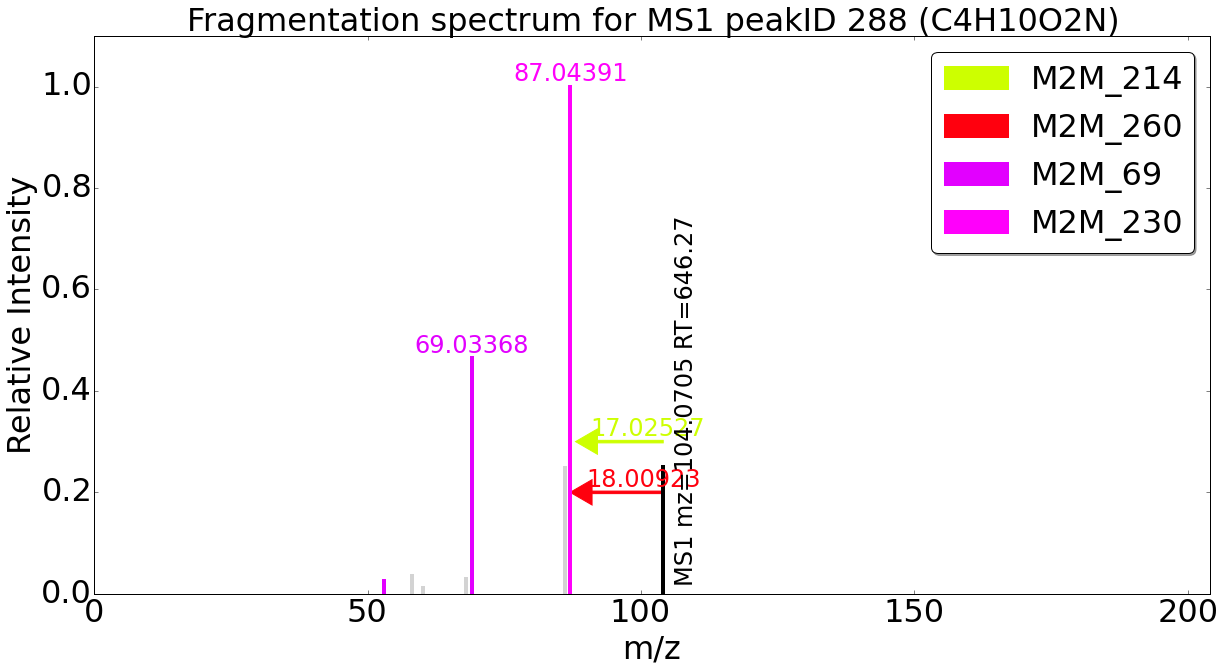

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0   87.043861       1.000000   fragment_87.04391             230   
1   69.033653       0.464266   fragment_69.03368              69   
2   86.060127       0.247173   fragment_86.06016             NaN   
3  104.071075       0.040227  fragment_104.07105             NaN   
4   58.065491       0.035022   fragment_58.06552             NaN   
5   68.049789       0.028956   fragment_68.04977             NaN   
6   53.002575       0.025035   fragment_53.00259              69   
7  104.107376       0.024224  fragment_104.10738             NaN   
8   60.080967       0.010841   fragment_60.08102             NaN   

       loss_word  loss_motif                ef  
0  loss_17.02527         214            C4H7O2  
1  loss_35.03689         NaN             C4H5O  
2  loss_18.00923         260            C4H8ON  
3            NaN         NaN          C4H10O2N  
4  loss_46.00539         NaN  C3H8N,loss_CH2O2  
5  loss_36.01851         NaN             C4H6N  
6            NaN         NaN              C3HO  
7            NaN         NaN           C5H14ON  
8  loss_43.98915         NaN            C3H10N

 - M2M_174	: Pyroglutamic acid (pyroglutamate) substructure
		  fragment_84.0442 (0.854),fragment_56.04977 (0.102),

(32485, 'C12H35O5N6P2S')


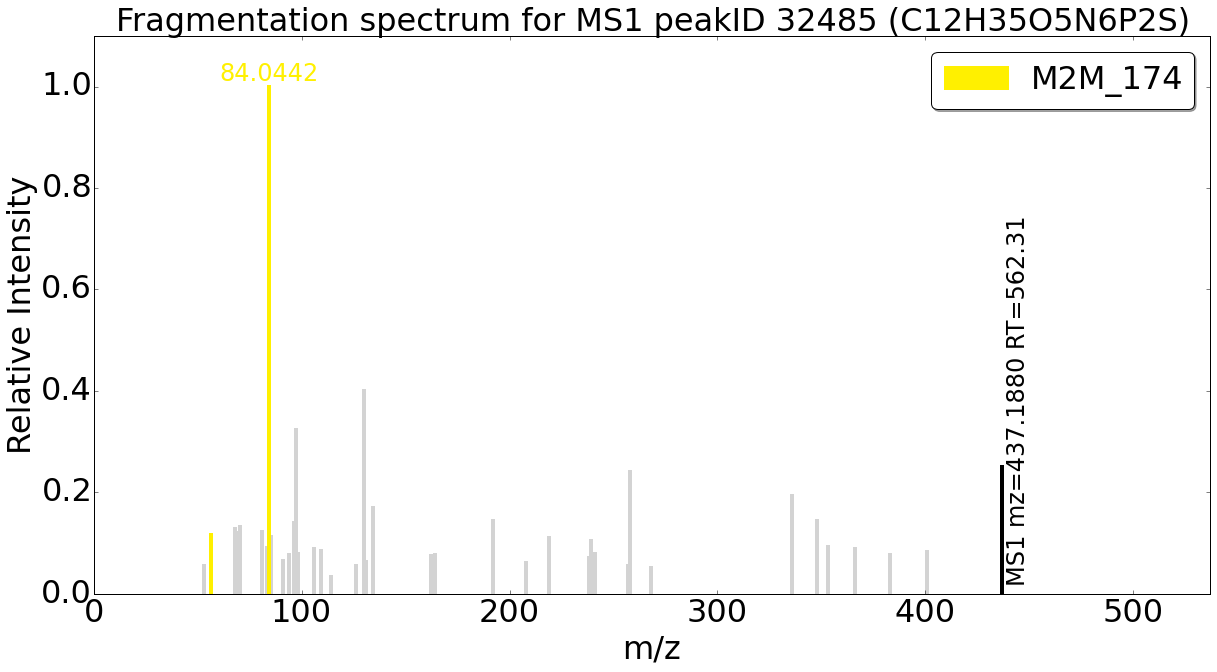

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0    84.044235       1.000000    fragment_84.0442             174   
1   130.050659       0.399133  fragment_130.05051             NaN   
2    97.028419       0.322021   fragment_97.02839             NaN   
3   258.109131       0.240180  fragment_258.10965             NaN   
4   437.166351       0.239602  fragment_437.16635             NaN   
5   336.119171       0.192385   fragment_336.1197             NaN   
6   134.060394       0.170030  fragment_134.06003             NaN   
7   192.064606       0.143326  fragment_192.06433             NaN   
8   348.122467       0.142562  fragment_348.12239             NaN   
9    96.044060       0.138625   fragment_96.04413             NaN   
10   70.065163       0.131478   fragment_70.06514             NaN   
11   68.049927       0.127144   fragment_68.04977             NaN   
12   81.033432       0.121143   fragment_81.03334             NaN   
13   69.033852       0.120646   fragment_69.03368             NaN   
14   56.049931       0.116501   fragment_56.04977             174   
15   85.028488       0.111526   fragment_85.02832             NaN   
16  219.077454       0.110679  fragment_219.07777             NaN   
17  239.074921       0.103764  fragment_239.07487             NaN   
18  353.147919       0.091426  fragment_353.14781             NaN   
19   83.060455       0.090961   fragment_83.06041             NaN   
20  106.065094       0.087454  fragment_106.06503             NaN   
21  366.128387       0.087365  fragment_366.12827             NaN   
22  109.028931       0.085078  fragment_109.02882             NaN   
23  401.163300       0.083285   fragment_401.1633             NaN   
24   98.031525       0.079302   fragment_98.03152             NaN   
25  241.082214       0.078769  fragment_241.08168             NaN   
26   94.028488       0.076401   fragment_94.02842             NaN   
27  383.159454       0.076149  fragment_383.15935             NaN   
28  164.070709       0.075797  fragment_164.07055             NaN   
29  162.054306       0.074087  fragment_162.05448             NaN   
30  238.071579       0.071062  fragment_238.07132             NaN   
31   91.054184       0.065190   fragment_91.05413             NaN   
32  131.053772       0.062332  fragment_131.05381             NaN   
33  208.061218       0.061296  fragment_208.06126             NaN   
34  126.054436       0.055729  fragment_126.05438             NaN   
35  257.086426       0.055372  fragment_257.08635             NaN   
36  240.098236       0.055127  fragment_240.09821             NaN   
37   53.038857       0.053967   fragment_53.03888             NaN   
38  268.093567       0.051444  fragment_268.09357             NaN   
39   85.047707       0.034692   fragment_85.04762             NaN   
40  114.055481       0.032267   fragment_114.0554             NaN   

         loss_word  loss_motif                         ef  
0              NaN         NaN                     C4H6ON  
1              NaN         NaN                    C5H8O3N  
2              NaN         NaN                     C5H5O2  
3   loss_179.07913         NaN   C10H16O5N3,loss_C6H13O5N  
4              NaN         NaN                        NaN  
5   loss_101.06807         NaN                        NaN  
6              NaN         NaN                     C8H8ON  
7              NaN         NaN                 C4H11O2N5P  
8              NaN         NaN                        NaN  
9              NaN         NaN                     C5H6ON  
10             NaN         NaN                      C4H8N  
11             NaN         NaN                      C4H6N  
12             NaN         NaN                      C5H5O  
13             NaN         NaN                      C4H5O  
14             NaN         NaN                      C3H6N  
15             NaN         NaN                     C4H5O2  
16             NaN         NaN                   C9H16O4P  
17   loss_198.1107         Na

 - M2M_129	: fragments from [hexose-H2O] substructure (a hexose conjugation, e.g. glucose)
		  fragment_145.04997 (0.260),fragment_127.03868 (0.188),fragment_85.02832 (0.152),fragment_163.06064 (0.079),fragment_97.02839 (0.055),fragment_81.03334 (0.041),fragment_69.03368 (0.037),fragment_103.03863 (0.036),fragment_109.02882 (0.032),fragment_99.04454 (0.021),fragment_99.04377 (0.017),fragment_53.03888 (0.013),fragment_325.11195 (0.011),
 - M2M_131	: fragments from [hexose-H2O] substructure (a hexose conjugation, e.g. glucose)
		  fragment_85.02832 (0.566),fragment_69.03368 (0.105),fragment_97.02839 (0.088),fragment_61.02854 (0.070),fragment_57.0337 (0.045),fragment_91.03925 (0.022),fragment_127.03868 (0.021),fragment_73.0285 (0.019),fragment_55.01824 (0.019),

(30326, 'C18H29O4P2')


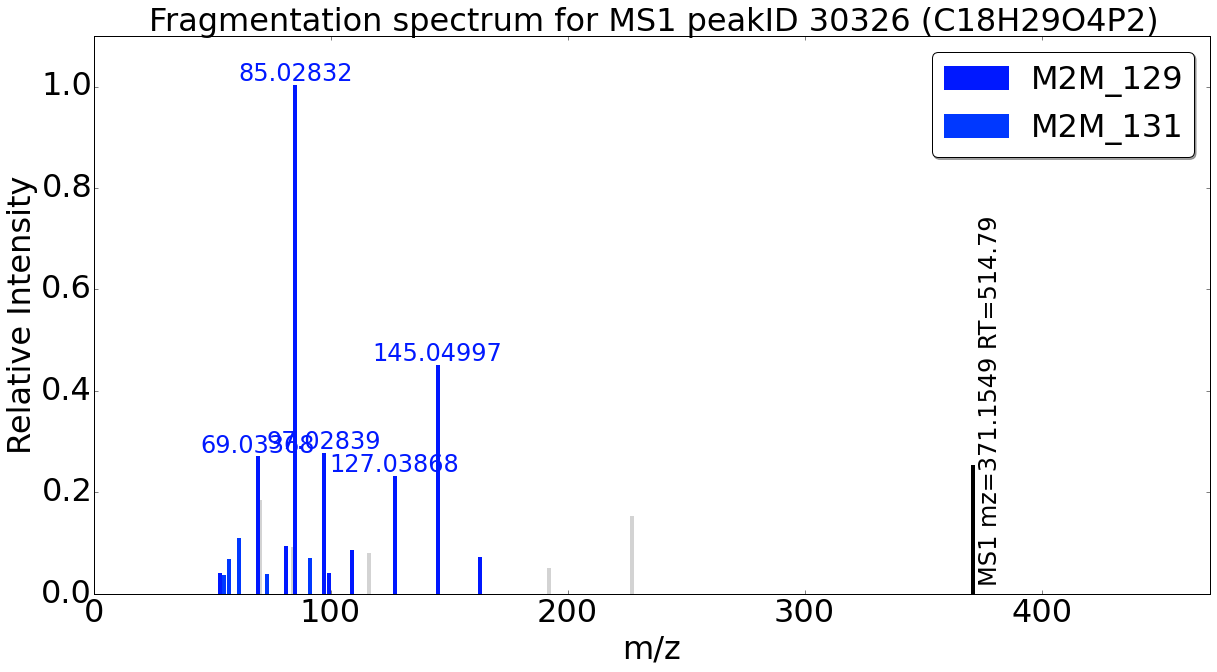

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0    85.028358       1.000000   fragment_85.02832             129   
1   145.050110       0.448061  fragment_145.04997             129   
2    97.028381       0.274189   fragment_97.02839             129   
3    69.033699       0.267968   fragment_69.03368             129   
4   127.038818       0.229060  fragment_127.03868             129   
5    70.065224       0.180046   fragment_70.06514             NaN   
6   227.103760       0.148976  fragment_227.10379             NaN   
7    61.028580       0.105354   fragment_61.02854             131   
8    81.033440       0.091030   fragment_81.03334             129   
9    84.044174       0.087955    fragment_84.0442             NaN   
10  109.029152       0.082735  fragment_109.02882             129   
11  116.070961       0.077397  fragment_116.07116             NaN   
12  163.060226       0.068370  fragment_163.06064             129   
13   91.039062       0.066027   fragment_91.03925             131   
14   57.033779       0.064105    fragment_57.0337             131   
15  192.066895       0.046581  fragment_192.06671             NaN   
16   99.043655       0.037940   fragment_99.04377             129   
17   53.038841       0.037781   fragment_53.03888             129   
18   73.028511       0.035036    fragment_73.0285             131   
19   55.018230       0.032460   fragment_55.01824             131   

         loss_word  loss_motif                      ef  
0              NaN         NaN                  C4H5O2  
1              NaN         NaN                  C6H9O4  
2              NaN         NaN                  C5H5O2  
3              NaN         NaN                   C4H5O  
4              NaN         NaN                  C6H7O3  
5              NaN         NaN                   C4H8N  
6   loss_144.05287         NaN  C11H11N6,loss_C5H8O3N2  
7              NaN         NaN                  C2H5O2  
8              NaN         NaN                   C5H5O  
9              NaN         NaN                  C4H6ON  
10             NaN         NaN                  C6H5O2  
11             NaN         NaN                C5H10O2N  
12             NaN         NaN                 C6H11O5  
13             NaN         NaN                  C3H7O3  
14             NaN         NaN                   C3H5O  
15             NaN         NaN                     NaN  
16             NaN         NaN                  C5H7O2  
17             NaN         NaN                    C4H5  
18             NaN         NaN                  C3H5O2  
19             NaN         NaN                   C3H3O

 - M2M_131	: fragments from [hexose-H2O] substructure (a hexose conjugation, e.g. glucose)
		  fragment_85.02832 (0.566),fragment_69.03368 (0.105),fragment_97.02839 (0.088),fragment_61.02854 (0.070),fragment_57.0337 (0.045),fragment_91.03925 (0.022),fragment_127.03868 (0.021),fragment_73.0285 (0.019),fragment_55.01824 (0.019),

(34219, 'C20H36O19P')


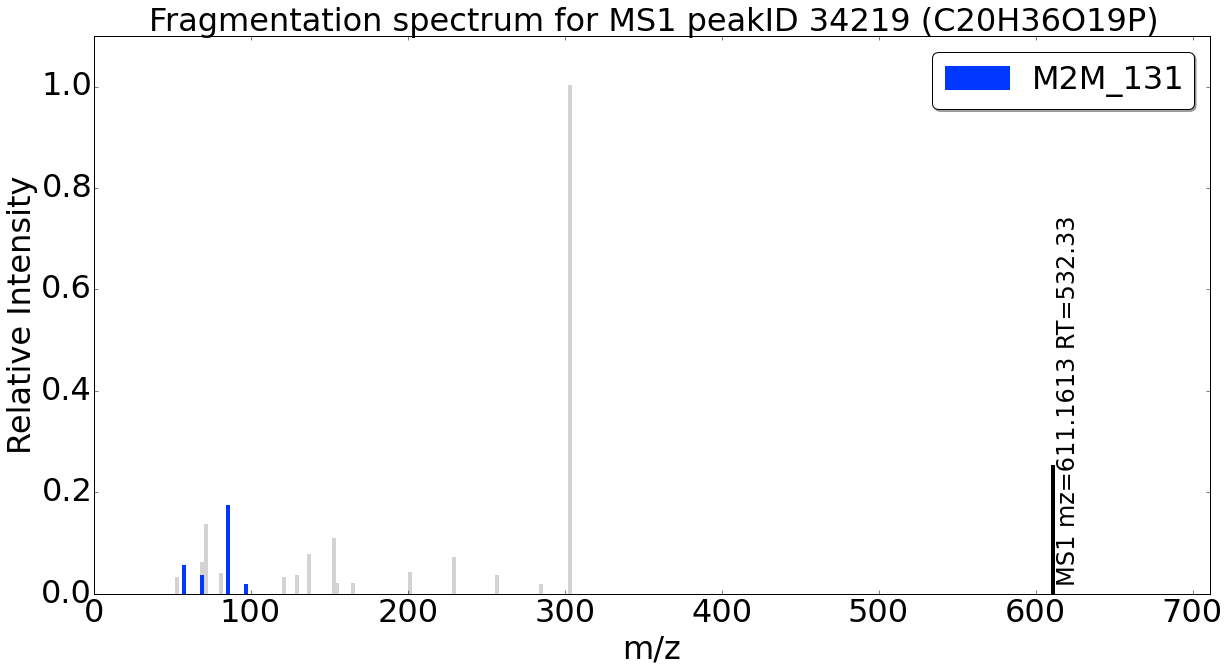

ms2_mz  ms2_intensity       fragment_word  fragment_motif  loss_word  \
0   303.049927       1.000000  fragment_303.05017             NaN        NaN   
1    85.028358       0.171375   fragment_85.02832             131        NaN   
2    71.049423       0.132743   fragment_71.04937             NaN        NaN   
3   153.019073       0.106547    fragment_153.019             NaN        NaN   
4   137.023514       0.075240  fragment_137.02343             NaN        NaN   
5   229.050583       0.068475  fragment_229.05091             NaN        NaN   
6    68.997086       0.058706   fragment_68.99719             NaN        NaN   
7    57.033749       0.053719    fragment_57.0337             131        NaN   
8   201.055511       0.039453  fragment_201.05555             NaN        NaN   
9    81.033310       0.038024   fragment_81.03334             NaN        NaN   
10  129.054672       0.033264  fragment_129.05464             NaN        NaN   
11   69.033623       0.033119   fragment_69.03368             131        NaN   
12  257.043213       0.032395  fragment_257.04329             NaN        NaN   
13   70.065094       0.031216   fragment_70.06514             NaN        NaN   
14   53.038815       0.029793   fragment_53.03888             NaN        NaN   
15  121.028252       0.029787  fragment_121.02828             NaN        NaN   
16  155.049911       0.017151  fragment_155.04991             NaN        NaN   
17  165.019592       0.016957  fragment_165.01959             NaN        NaN   
18  285.035736       0.015485  fragment_285.03574             NaN        NaN   
19   97.028374       0.014449   fragment_97.02839             131        NaN   

    loss_motif           ef  
0          NaN          NaN  
1          NaN       C4H5O2  
2          NaN        C4H7O  
3          NaN      H5O2N6S  
4          NaN       C7H5O3  
5          NaN  C5H15O4N2P2  
6          NaN        C3HO2  
7          NaN        C3H5O  
8          NaN      C12H9O3  
9          NaN        C5H5O  
10         NaN       C6H9O3  
11         NaN        C4H5O  
12         NaN     C7H14O8P  
13         NaN        C4H8N  
14         NaN         C4H5  
15         NaN       C7H5O2  
16         NaN       C11H7O  
17         NaN        C9HN4  
18         NaN          NaN  
19         NaN       C5H5O2

 - M2M_2	: Small nitrogen containing fragment ion - often proline or ornithine derived
		  fragment_70.06514 (0.979),
 - M2M_174	: Pyroglutamic acid (pyroglutamate) substructure
		  fragment_84.0442 (0.854),fragment_56.04977 (0.102),

(28213, 'C20H21O2P2')


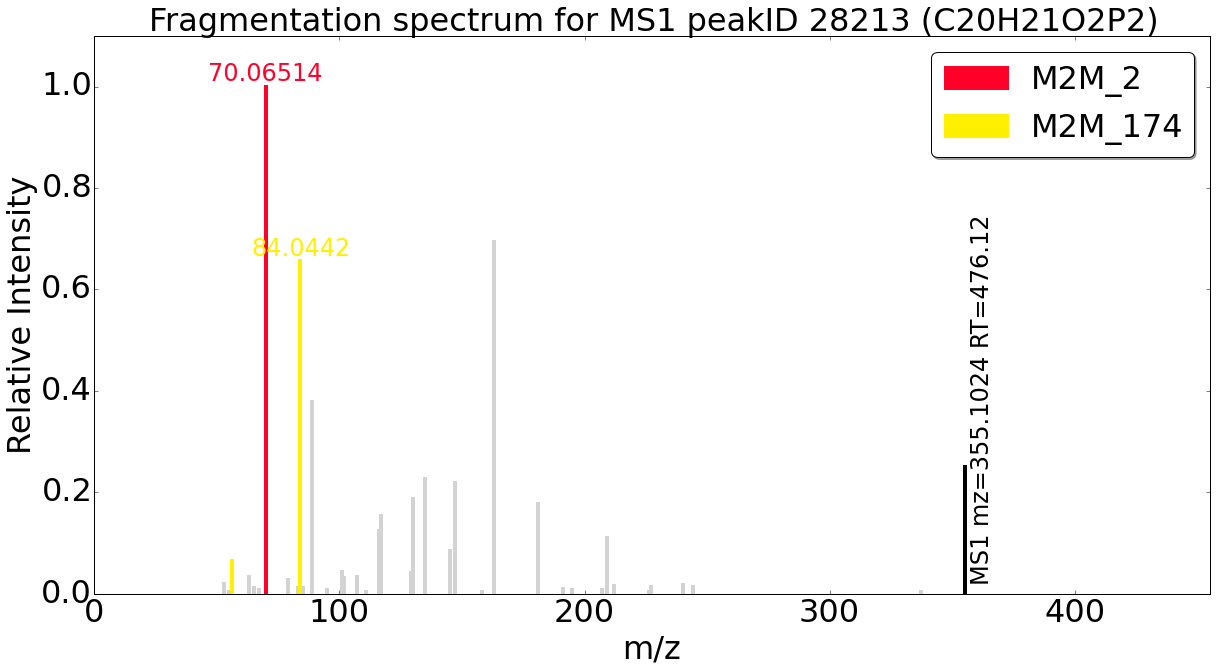

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0    70.065163       1.000000   fragment_70.06514               2   
1   163.039078       0.693673  fragment_163.03896             NaN   
2    84.044167       0.655379    fragment_84.0442             174   
3    89.038620       0.377939   fragment_89.03864             NaN   
4   135.044510       0.225494   fragment_135.0444             NaN   
5   147.075974       0.217836  fragment_147.07588             NaN   
6   130.050644       0.186870  fragment_130.05051             NaN   
7   181.098038       0.177725  fragment_181.09786             NaN   
8   117.033195       0.152439  fragment_117.03316             NaN   
9   116.071220       0.124534  fragment_116.07116             NaN   
10  209.092545       0.110006  fragment_209.09231             NaN   
11  145.028488       0.083818  fragment_145.02839             NaN   
12   56.049782       0.064154   fragment_56.04977             174   
13  101.071266       0.043104  fragment_101.07126             NaN   
14  129.065842       0.041434  fragment_129.06581             NaN   
15  107.048782       0.033929  fragment_107.04883             NaN   
16   63.023277       0.032962   fragment_63.02327             NaN   
17  102.054581       0.030859   fragment_102.0547             NaN   
18   79.054138       0.026864   fragment_79.05416             NaN   
19   53.038960       0.019047   fragment_53.03888             NaN   
20  240.098251       0.017461  fragment_240.09821             NaN   
21  212.104248       0.016356  fragment_212.10437             NaN   
22   53.002590       0.014314   fragment_53.00259             NaN   
23  244.128769       0.014202  fragment_244.12872             NaN   
24  227.103806       0.012847  fragment_227.10379             NaN   
25   83.048958       0.012339   fragment_83.04894             NaN   
26   65.038765       0.011236   fragment_65.03878             NaN   
27   85.028320       0.010713   fragment_85.02832             NaN   
28  191.080978       0.010372  fragment_191.08122             NaN   
29  207.099472       0.007422  fragment_207.09952             NaN   
30   95.049362       0.007394   fragment_95.04936             NaN   
31   67.054527       0.007241   fragment_67.05454             NaN   
32  195.075943       0.007123  fragment_195.07582             NaN   
33   55.054619       0.003902   fragment_55.05466             NaN   
34  111.044296       0.003638  fragment_111.04428             NaN   
35  337.151459       0.003359  fragment_337.15148             NaN   
36  158.061600       0.003016   fragment_158.0616             NaN   
37   83.060410       0.002865   fragment_83.06041             NaN   
38  226.116974       0.002802  fragment_226.11697             NaN   

         loss_word  loss_motif                   ef  
0              NaN         NaN                C4H8N  
1   loss_192.06323         NaN  C9H7O3,loss_C7H12O6  
2              NaN         NaN               C4H6ON  
3              NaN         NaN                 C7H5  
4              NaN         NaN               C8H7O2  
5              NaN         NaN            C5H11O3N2  
6              NaN         NaN              C5H8O3N  
7              NaN         NaN            C9H13O2N2  
8              NaN         NaN                C8H5O  
9              NaN         NaN             C5H10O2N  
10  loss_146.01014         NaN           C10H13O3N2  
11             NaN         NaN               C9H5O2  
12             NaN         NaN                C3H6N  
13             NaN         NaN              C4H9ON2  
14             NaN         NaN             C5H9O2N2  
15             NaN         NaN                C7H7O  
16             NaN         NaN                 C5H3  
17             NaN         NaN              C4H8O2N  
18             NaN         NaN                 C6H7  
19             NaN         NaN                 C4H5  
20             NaN         NaN            C12H19NPS  
21             NaN         NaN            C7H19O4NP  
22   

 - M2M_220	: Adenine substructure
		  fragment_136.06239 (0.688),loss_162.03528 (0.049),fragment_119.03518 (0.039),loss_153.04184 (0.027),fragment_137.04626 (0.020),

(29587, 'C18H18ON6P')


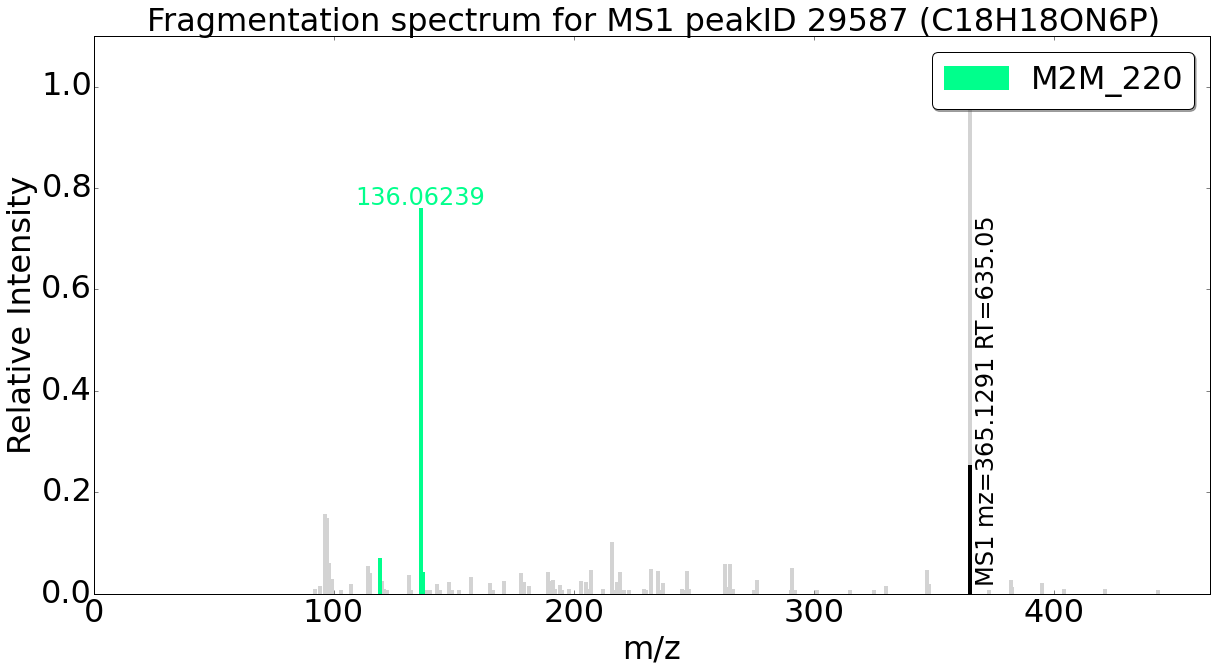

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0   365.106995       1.000000  fragment_365.10697             NaN   
1   136.062408       0.756757  fragment_136.06239             220   
2    96.044128       0.152688   fragment_96.04413             NaN   
3    97.028366       0.145982   fragment_97.02839             NaN   
4   216.028198       0.097443   fragment_216.0282             NaN   
5   119.035240       0.066735  fragment_119.03518             220   
6   534.278687       0.059468  fragment_534.27864             NaN   
7    98.059975       0.055982   fragment_98.06001             NaN   
8   265.083801       0.054731  fragment_265.08376             NaN   
9   263.069427       0.053979  fragment_263.06912             NaN   
10  114.102715       0.051211  fragment_114.10279             NaN   
11  291.063538       0.047363  fragment_291.06354             NaN   
12  232.083221       0.044436  fragment_232.08279             NaN   
13  347.095062       0.043649  fragment_347.09548             NaN   
14  207.080200       0.042239  fragment_207.07981             NaN   
15  247.074982       0.040632  fragment_247.07445             NaN   
16  235.075394       0.040547  fragment_235.07587             NaN   
17  189.070587       0.039084  fragment_189.07017             NaN   
18  137.046661       0.038940  fragment_137.04626             220   
19  219.080612       0.038270  fragment_219.08066             NaN   
20  115.054245       0.037719  fragment_115.05435             NaN   
21  178.076599       0.037400   fragment_178.0764             NaN   
22  131.129318       0.033625  fragment_131.12915             NaN   
23   97.076561       0.029401   fragment_97.07643             NaN   
24  157.108215       0.028465  fragment_157.10838             NaN   
25   98.983955       0.024995   fragment_98.98385             NaN   
26  382.164795       0.023660  fragment_382.16485             NaN   
27  137.067184       0.022876  fragment_137.06711             NaN   
28  191.085403       0.022840   fragment_191.0857             NaN   
29  276.155243       0.022516  fragment_276.15583             NaN   
..         ...            ...                 ...             ...   
69  373.158325       0.004366  fragment_373.15862             NaN   
70  246.633224       0.004360  fragment_246.63322             NaN   
71  144.057663       0.004310  fragment_144.05767             NaN   
72  220.083969       0.004296  fragment_220.08397             NaN   
73  132.065598       0.004207  fragment_132.06554             NaN   
74  195.081131       0.004144  fragment_195.08114             NaN   
75  139.050720       0.004035  fragment_139.05068             NaN   
76  131.048019       0.004008  fragment_131.04802             NaN   
77  325.128784       0.003967  fragment_325.12878             NaN   
78  517.266724       0.003891  fragment_517.26672             NaN   
79  954.190247       0.003751  fragment_954.19025             NaN   
80  778.524292       0.003685  fragment_778.52429             NaN   
81  230.043961       0.003616  fragment_230.04396             NaN   
82  301.167572       0.003492  fragment_301.16757             NaN   
83  236.077255       0.003482  fragment_236.07726             NaN   
84  221.059601       0.003470  fragment_221.05945             NaN   
85  290.391083       0.003443  fragment_290.39108             NaN   
86  223.074646       0.003409  fragment_223.07461             NaN   
87  166.078293       0.003213  fragment_166.07828             NaN   
88  122.070534       0.003153   fragment_122.0705             NaN   
89  217.065048       0.003045  fragment_217.06505             NaN   
90  443.544312       0.003018  fragment_443.54431             NaN   
91  121.029556       0.002987  fragment_121.02956             NaN   
92  275.075897       0.002970  fragment_275.07594             NaN   
93  140.081299       0.002928  fragment_140.08128             NaN   
94  120.040497       0.002907   fragment_120.0405             NaN   
95  14

 - No M2M for this MS1 peak at the specified thresholding levels



None

 - M2M_220	: Adenine substructure
		  fragment_136.06239 (0.688),loss_162.03528 (0.049),fragment_119.03518 (0.039),loss_153.04184 (0.027),fragment_137.04626 (0.020),

(33896, nan)


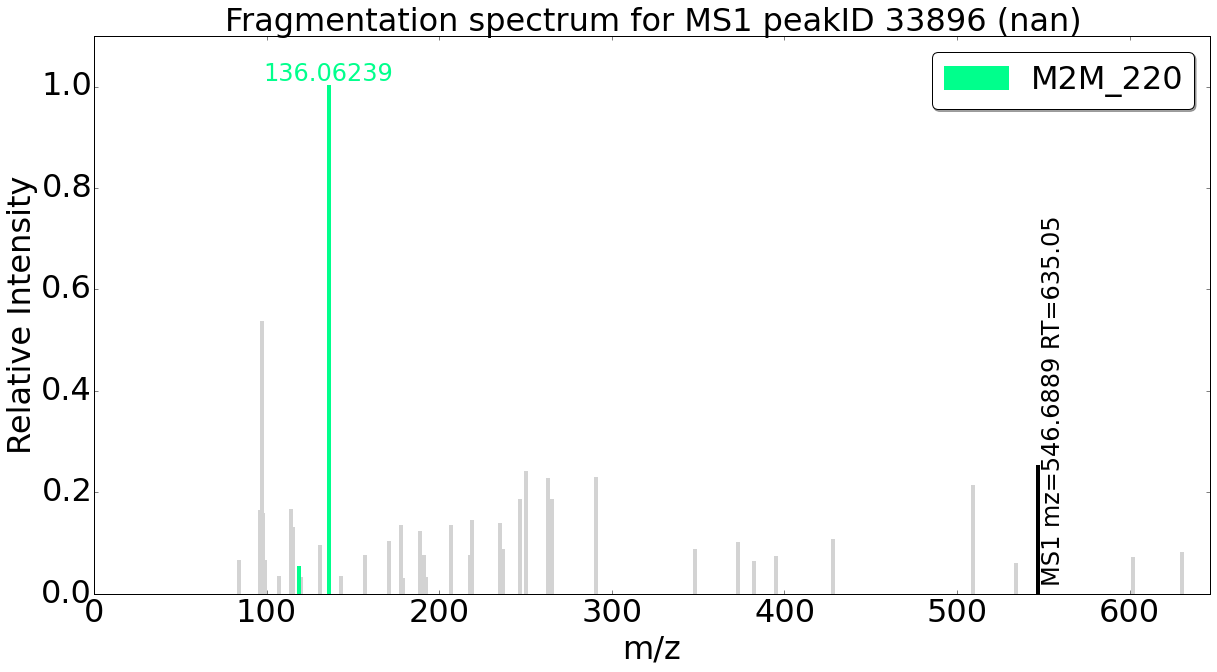

ms2_mz  ms2_intensity       fragment_word  fragment_motif  loss_word  \
0   136.062424       1.000000  fragment_136.06239             220        NaN   
1    97.028328       0.533287   fragment_97.02839             NaN        NaN   
2   250.093277       0.238523  fragment_250.09297             NaN        NaN   
3   291.063416       0.225533  fragment_291.06354             NaN        NaN   
4   263.068909       0.223904  fragment_263.06912             NaN        NaN   
5   509.283813       0.210097  fragment_509.28381             NaN        NaN   
6   247.074158       0.183022  fragment_247.07445             NaN        NaN   
7   265.083618       0.182364  fragment_265.08376             NaN        NaN   
8   114.103127       0.162579  fragment_114.10279             NaN        NaN   
9    96.044197       0.161850   fragment_96.04413             NaN        NaN   
10   98.059853       0.154594   fragment_98.06001             NaN        NaN   
11  219.080948       0.140568  fragment_219.08066             NaN        NaN   
12  235.076324       0.134887  fragment_235.07587             NaN        NaN   
13  207.079514       0.132319  fragment_207.07981             NaN        NaN   
14  178.078171       0.131588  fragment_178.07822             NaN        NaN   
15  115.054298       0.128276  fragment_115.05435             NaN        NaN   
16  189.070023       0.120097  fragment_189.07017             NaN        NaN   
17  428.034058       0.103619  fragment_428.03409             NaN        NaN   
18  171.045181       0.101067  fragment_171.04482             NaN        NaN   
19  373.159790       0.097579  fragment_373.15862             NaN        NaN   
20  131.129074       0.093000  fragment_131.12915             NaN        NaN   
21  237.091843       0.085083  fragment_237.09191             NaN        NaN   
22  348.066681       0.084353  fragment_348.06668             NaN        NaN   
23  630.303711       0.078064  fragment_630.30371             NaN        NaN   
24  218.072418       0.073389  fragment_218.07273             NaN        NaN   
25  157.108368       0.073298  fragment_157.10838             NaN        NaN   
26  191.085892       0.072664   fragment_191.0857             NaN        NaN   
27  395.209412       0.070331  fragment_395.20961             NaN        NaN   
28  602.304993       0.069541  fragment_602.30499             NaN        NaN   
29   98.983772       0.063620   fragment_98.98385             NaN        NaN   
30   84.080666       0.062267   fragment_84.08071             NaN        NaN   
31  190.077728       0.061632  fragment_190.07853             NaN        NaN   
32  382.165070       0.061108  fragment_382.16485             NaN        NaN   
33   97.075500       0.059081   fragment_97.07555             NaN        NaN   
34  534.278442       0.057484  fragment_534.27864             NaN        NaN   
35  119.035103       0.050525  fragment_119.03518             220        NaN   
36  143.049408       0.030926  fragment_143.04944             NaN        NaN   
37  107.048782       0.030536  fragment_107.04883             NaN        NaN   
38  120.056641       0.030125   fragment_120.0564             NaN        NaN   
39  192.112198       0.030061   fragment_192.1124             NaN        NaN   
40   84.044113       0.029435    fragment_84.0442             NaN        NaN   
41  179.085312       0.028136   fragment_179.0854             NaN        NaN   

    loss_motif           ef  
0          NaN       C5H6N5  
1          NaN       C5H5O2  
2          NaN     C9H16O7N  
3          NaN          NaN  
4          NaN    C10H16O6P  
5          NaN          NaN  
6          NaN  C3H16O3N6PS  
7          NaN   C13H17N2S2  
8          NaN      C5H12N3  
9          NaN       C5H6ON  
10         NaN       C5H8ON  
11         NaN   C8H15O3N2S  
12         NaN   C8H15O4N2S  
13         NaN     C9H12N4P  
14         NaN     C10H13NP  
15         NaN         C9H7  
16         NaN        C15H9  
17         NaN          NaN

 - M2M_129	: fragments from [hexose-H2O] substructure (a hexose conjugation, e.g. glucose)
		  fragment_145.04997 (0.260),fragment_127.03868 (0.188),fragment_85.02832 (0.152),fragment_163.06064 (0.079),fragment_97.02839 (0.055),fragment_81.03334 (0.041),fragment_69.03368 (0.037),fragment_103.03863 (0.036),fragment_109.02882 (0.032),fragment_99.04454 (0.021),fragment_99.04377 (0.017),fragment_53.03888 (0.013),fragment_325.11195 (0.011),
 - M2M_131	: fragments from [hexose-H2O] substructure (a hexose conjugation, e.g. glucose)
		  fragment_85.02832 (0.566),fragment_69.03368 (0.105),fragment_97.02839 (0.088),fragment_61.02854 (0.070),fragment_57.0337 (0.045),fragment_91.03925 (0.022),fragment_127.03868 (0.021),fragment_73.0285 (0.019),fragment_55.01824 (0.019),

(31406, 'C18H32O4NP2')


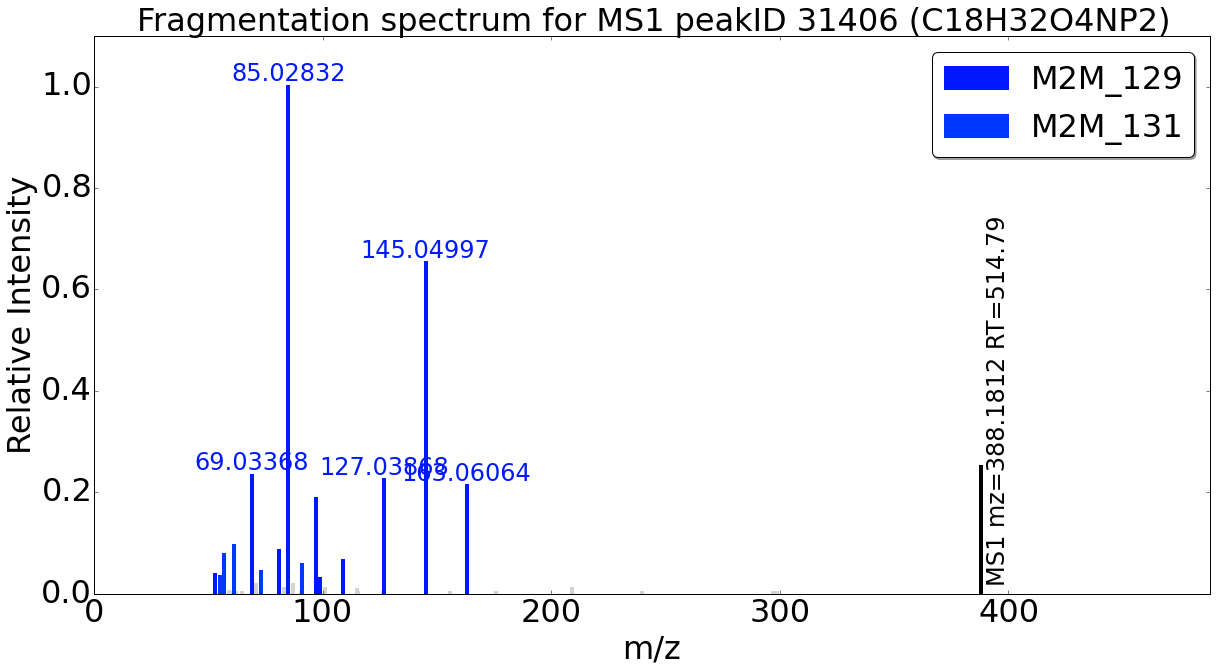

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0    85.028297       1.000000   fragment_85.02832             129   
1   145.049957       0.651447  fragment_145.04997             129   
2    69.033676       0.233090   fragment_69.03368             129   
3   127.038673       0.223450  fragment_127.03868             129   
4   163.060608       0.212252  fragment_163.06064             129   
5    97.028351       0.187485   fragment_97.02839             129   
6    61.028530       0.093568   fragment_61.02854             131   
7    81.033295       0.084695   fragment_81.03334             129   
8    57.033665       0.077080    fragment_57.0337             131   
9   109.028732       0.065393  fragment_109.02882             129   
10   91.039345       0.056276   fragment_91.03925             131   
11   73.028580       0.042964    fragment_73.0285             131   
12   53.038918       0.037633   fragment_53.03888             129   
13   55.018227       0.033248   fragment_55.01824             131   
14   99.044571       0.028618   fragment_99.04454             129   
15   87.043839       0.017809   fragment_87.04391             NaN   
16   71.049332       0.017807   fragment_71.04937             NaN   
17   53.002552       0.012665   fragment_53.00259             NaN   
18   71.013016       0.011022   fragment_71.01303             NaN   
19  209.101028       0.010280  fragment_209.10103             NaN   
20  101.023064       0.008875  fragment_101.02307             NaN   
21   83.012291       0.008554   fragment_83.01229             NaN   
22   70.065079       0.008006   fragment_70.06514             NaN   
23  115.039093       0.007957  fragment_115.03913             NaN   
24   84.044853       0.004164   fragment_84.04486             NaN   
25   59.049335       0.003701    fragment_59.0494             NaN   
26  155.615448       0.002366  fragment_155.61545             NaN   
27   73.024910       0.002311   fragment_73.02491             NaN   
28  298.728485       0.002253  fragment_298.72849             NaN   
29  239.597702       0.002163   fragment_239.5977             NaN   
30  126.433716       0.002086  fragment_126.43372             NaN   
31   62.268867       0.002031   fragment_62.26887             NaN   
32  176.029053       0.002007  fragment_176.02905             NaN   
33   90.415497       0.001996    fragment_90.4155             NaN   
34   64.756584       0.001871   fragment_64.75658             NaN   
35  115.352196       0.001870   fragment_115.3522             NaN   
36  297.026703       0.001831   fragment_297.0267             NaN   
37   56.049698       0.001797   fragment_56.04977             NaN   
38   60.022678       0.001756   fragment_60.02268             NaN   

         loss_word  loss_motif                     ef  
0              NaN         NaN                 C4H5O2  
1              NaN         NaN                 C6H9O4  
2              NaN         NaN                  C4H5O  
3              NaN         NaN                 C6H7O3  
4              NaN         NaN                C6H11O5  
5              NaN         NaN                 C5H5O2  
6              NaN         NaN                 C2H5O2  
7              NaN         NaN                  C5H5O  
8              NaN         NaN                  C3H5O  
9              NaN         NaN                 C6H5O2  
10             NaN         NaN                 C3H7O3  
11             NaN         NaN                 C3H5O2  
12             NaN         NaN                   C4H5  
13             NaN         NaN                  C3H3O  
14             NaN         NaN                 C5H7O2  
15             NaN         NaN                 C4H7O2  
16             NaN         NaN                  C4H7O  
17             NaN         NaN                   C3HO  
18             NaN         NaN                 C3H3O2  
19  loss_179.07913         NaN  C8H17O6,loss_C6H13O5N  
20             NaN         NaN                 C4H5O3  
21             

 - M2M_129	: fragments from [hexose-H2O] substructure (a hexose conjugation, e.g. glucose)
		  fragment_145.04997 (0.260),fragment_127.03868 (0.188),fragment_85.02832 (0.152),fragment_163.06064 (0.079),fragment_97.02839 (0.055),fragment_81.03334 (0.041),fragment_69.03368 (0.037),fragment_103.03863 (0.036),fragment_109.02882 (0.032),fragment_99.04454 (0.021),fragment_99.04377 (0.017),fragment_53.03888 (0.013),fragment_325.11195 (0.011),
 - M2M_131	: fragments from [hexose-H2O] substructure (a hexose conjugation, e.g. glucose)
		  fragment_85.02832 (0.566),fragment_69.03368 (0.105),fragment_97.02839 (0.088),fragment_61.02854 (0.070),fragment_57.0337 (0.045),fragment_91.03925 (0.022),fragment_127.03868 (0.021),fragment_73.0285 (0.019),fragment_55.01824 (0.019),

(32140, 'C14H36O5N3P2S')


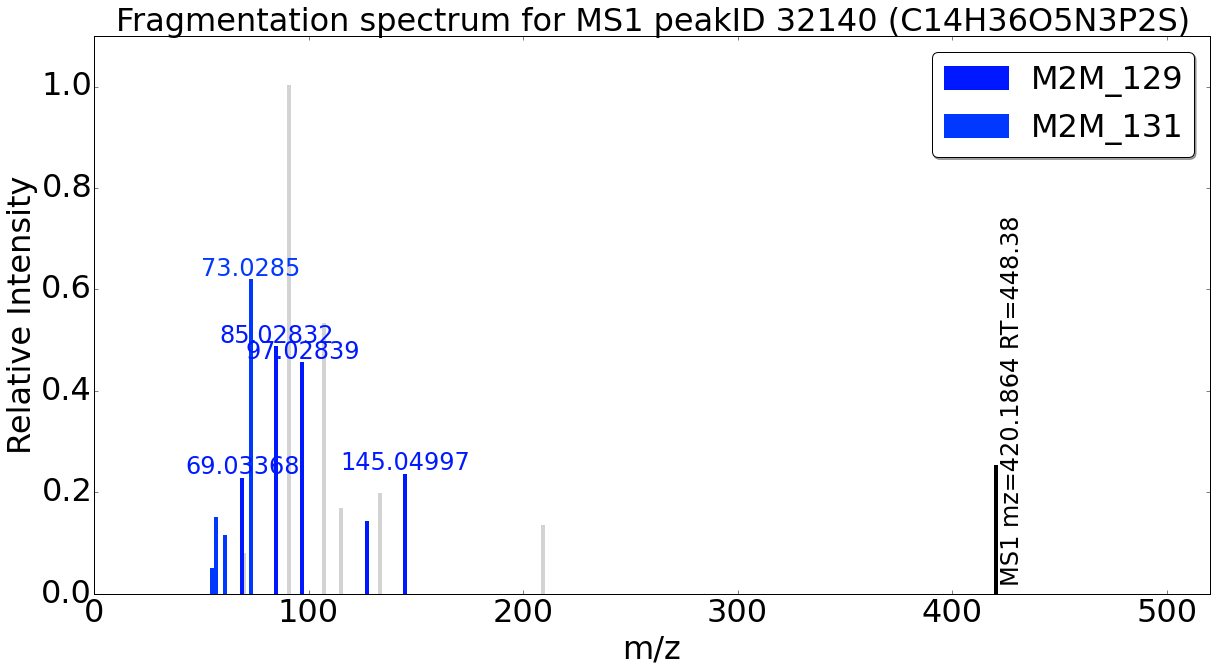

ms2_mz  ms2_intensity       fragment_word  fragment_motif  loss_word  \
0    91.054184       1.000000   fragment_91.05413             NaN        NaN   
1    73.028572       0.616002    fragment_73.0285             131        NaN   
2   107.048943       0.529810  fragment_107.04883             NaN        NaN   
3    85.028366       0.484769   fragment_85.02832             129        NaN   
4    97.028442       0.452117   fragment_97.02839             129        NaN   
5   145.050079       0.233152  fragment_145.04997             129        NaN   
6    69.033714       0.225232   fragment_69.03368             129        NaN   
7   133.049789       0.194361   fragment_133.0498             NaN        NaN   
8   115.039436       0.165906  fragment_115.03913             NaN        NaN   
9    57.033680       0.146790    fragment_57.0337             131        NaN   
10  127.039085       0.139410  fragment_127.03868             129        NaN   
11  209.081085       0.130790  fragment_209.08095             NaN        NaN   
12   61.028465       0.111051   fragment_61.02854             131        NaN   
13   70.065125       0.075795   fragment_70.06514             NaN        NaN   
14   55.018223       0.047297   fragment_55.01824             131        NaN   

    loss_motif        ef  
0          NaN      C7H7  
1          NaN    C3H5O2  
2          NaN     C7H7O  
3          NaN    C4H5O2  
4          NaN    C5H5O2  
5          NaN    C6H9O4  
6          NaN     C4H5O  
7          NaN    C5H9O4  
8          NaN    C5H7O3  
9          NaN     C3H5O  
10         NaN    C6H7O3  
11         NaN  C11H13O4  
12         NaN    C2H5O2  
13         NaN     C4H8N  
14         NaN     C3H3O

 - M2M_220	: Adenine substructure
		  fragment_136.06239 (0.688),loss_162.03528 (0.049),fragment_119.03518 (0.039),loss_153.04184 (0.027),fragment_137.04626 (0.020),

(29911, nan)


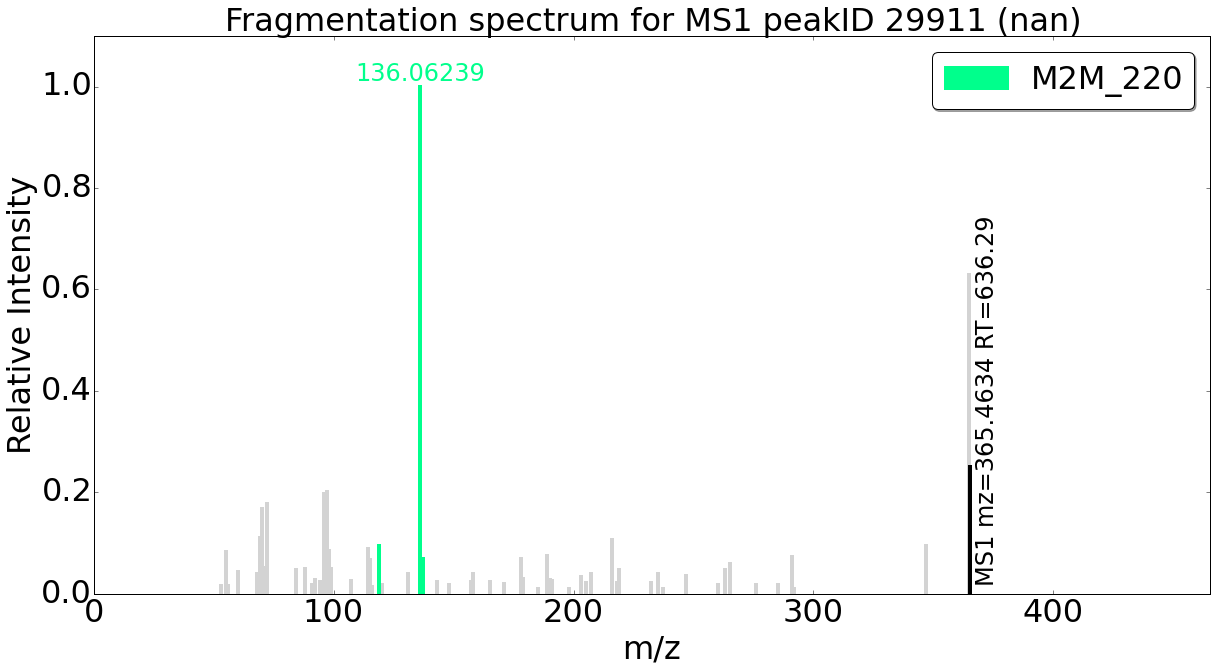

ms2_mz  ms2_intensity       fragment_word  fragment_motif  loss_word  \
0   136.062241       1.000000  fragment_136.06239             220        NaN   
1   365.106537       0.628589  fragment_365.10697             NaN        NaN   
2    97.028275       0.200067   fragment_97.02839             NaN        NaN   
3    96.044044       0.196509   fragment_96.04413             NaN        NaN   
4    72.080627       0.177729    fragment_72.0807             NaN        NaN   
5   365.205231       0.167626  fragment_365.20523             NaN        NaN   
6    70.065079       0.166856   fragment_70.06514             NaN        NaN   
7    69.033623       0.110051   fragment_69.03368             NaN        NaN   
8   216.027878       0.105511   fragment_216.0282             NaN        NaN   
9   347.095093       0.094526  fragment_347.09548             NaN        NaN   
10  119.034988       0.094491  fragment_119.03518             220        NaN   
11  114.102715       0.087532  fragment_114.10279             NaN        NaN   
12   98.059921       0.084278   fragment_98.06001             NaN        NaN   
13   55.054638       0.082976   fragment_55.05466             NaN        NaN   
14  189.070099       0.073630  fragment_189.07017             NaN        NaN   
15  291.064087       0.073162  fragment_291.06354             NaN        NaN   
16  137.046448       0.068559  fragment_137.04626             220        NaN   
17  178.076477       0.068133   fragment_178.0764             NaN        NaN   
18  115.054077       0.066703  fragment_115.05435             NaN        NaN   
19  265.088196       0.058783  fragment_265.08814             NaN        NaN   
20  137.066544       0.057413  fragment_137.06614             NaN        NaN   
21   71.060745       0.050772   fragment_71.06057             NaN        NaN   
22   98.984566       0.048774   fragment_98.98469             NaN        NaN   
23   88.086662       0.048131   fragment_88.08676             NaN        NaN   
24  219.080383       0.047552  fragment_219.08066             NaN        NaN   
25  263.068787       0.046382  fragment_263.06912             NaN        NaN   
26   84.080582       0.046171   fragment_84.08071             NaN        NaN   
27   60.055779       0.042468   fragment_60.05587             NaN        NaN   
28   97.076210       0.041269   fragment_97.07643             NaN        NaN   
29  207.079453       0.039766  fragment_207.07981             NaN        NaN   
..         ...            ...                 ...             ...        ...   
39  190.074631       0.026899  fragment_190.07509             NaN        NaN   
40  191.085831       0.025007   fragment_191.0857             NaN        NaN   
41  107.048752       0.024368  fragment_107.04883             NaN        NaN   
42  165.069778       0.023939  fragment_165.07004             NaN        NaN   
43   55.018169       0.023232   fragment_55.01824             NaN        NaN   
44   94.039604       0.023160    fragment_94.0397             NaN        NaN   
45  157.108322       0.022567  fragment_157.10838             NaN        NaN   
46  143.049362       0.022547  fragment_143.04944             NaN        NaN   
47  218.072357       0.021430  fragment_218.07273             NaN        NaN   
48  205.064987       0.021021  fragment_205.06529             NaN        NaN   
49  232.082535       0.020678  fragment_232.08279             NaN        NaN   
50   71.049332       0.020643   fragment_71.04937             NaN        NaN   
51  114.055321       0.019986   fragment_114.0554             NaN        NaN   
52  171.044632       0.019061  fragment_171.04482             NaN        NaN   
53  260.111359       0.018032  fragment_260.11143             NaN        NaN   
54   55.029396       0.017996   fragment_55.02948             NaN        NaN   
55   91.054054       0.017036   fragment_91.05413             NaN        NaN   
56  148.061920       0.016904  fragment_148.06201             NaN        NaN   
57  120.

 - No M2M for this MS1 peak at the specified thresholding levels



None

 - M2M_156	: [Pentose-H2O] loss, e.g. ribose
		  loss_132.04207 (0.683),loss_160.03691 (0.038),loss_149.06869 (0.037),fragment_102.06629 (0.030),loss_131.05794 (0.018),fragment_74.07118 (0.011),

(17207, 'C5H16O4N6P')


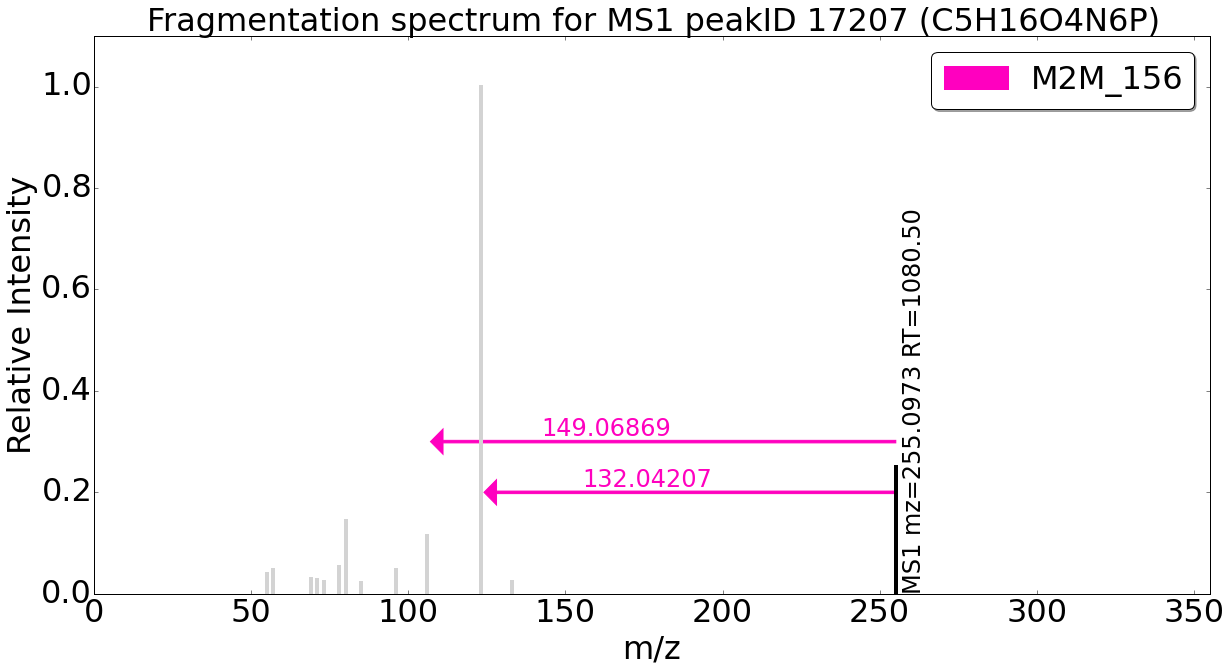

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0   123.055038       1.000000  fragment_123.05502             NaN   
1    80.049538       0.144116   fragment_80.04949             NaN   
2   106.028778       0.114573  fragment_106.02877             NaN   
3    78.034126       0.052336   fragment_78.03411             NaN   
4    57.033749       0.047839    fragment_57.0337             NaN   
5    96.044182       0.047299   fragment_96.04413             NaN   
6    55.018288       0.039860   fragment_55.01824             NaN   
7    69.033623       0.029809   fragment_69.03368             NaN   
8    71.013214       0.028085   fragment_71.01303             NaN   
9   133.049896       0.023199   fragment_133.0498             NaN   
10   73.028481       0.022976    fragment_73.0285             NaN   
11   85.028313       0.021743   fragment_85.02832             NaN   

         loss_word  loss_motif                     ef  
0   loss_132.04207         156    C6H7ON2,loss_C5H8O4  
1   loss_175.04802         NaN     C5H6N,loss_C6H9O5N  
2   loss_149.06869         156   C6H4ON,loss_C5H11O4N  
3    loss_177.0635         NaN    C5H4N,loss_C6H11O5N  
4   loss_198.06389         NaN   C3H5O,loss_C8H10O4N2  
5   loss_159.05302         NaN    C5H6ON,loss_C6H9O4N  
6              NaN         NaN                  C3H3O  
7   loss_186.06392         NaN   C4H5O,loss_C7H10O4N2  
8              NaN         NaN                 C3H3O2  
9              NaN         NaN                 C5H9O4  
10             NaN         NaN                 C3H5O2  
11  loss_170.06884         NaN  C4H5O2,loss_C7H10O3N2

 - M2M_280	: Loss possibly indicative of carboxylic acid group with 1-carbon attached
		  loss_60.02094 (0.741),loss_106.02643 (0.053),fragment_158.11806 (0.052),
 - M2M_158	: Leucine substructure
		  fragment_86.09652 (0.794),fragment_132.10154 (0.048),fragment_219.90121 (0.031),fragment_293.3515 (0.031),fragment_189.12428 (0.012),

(3661, 'C7H16O2N')


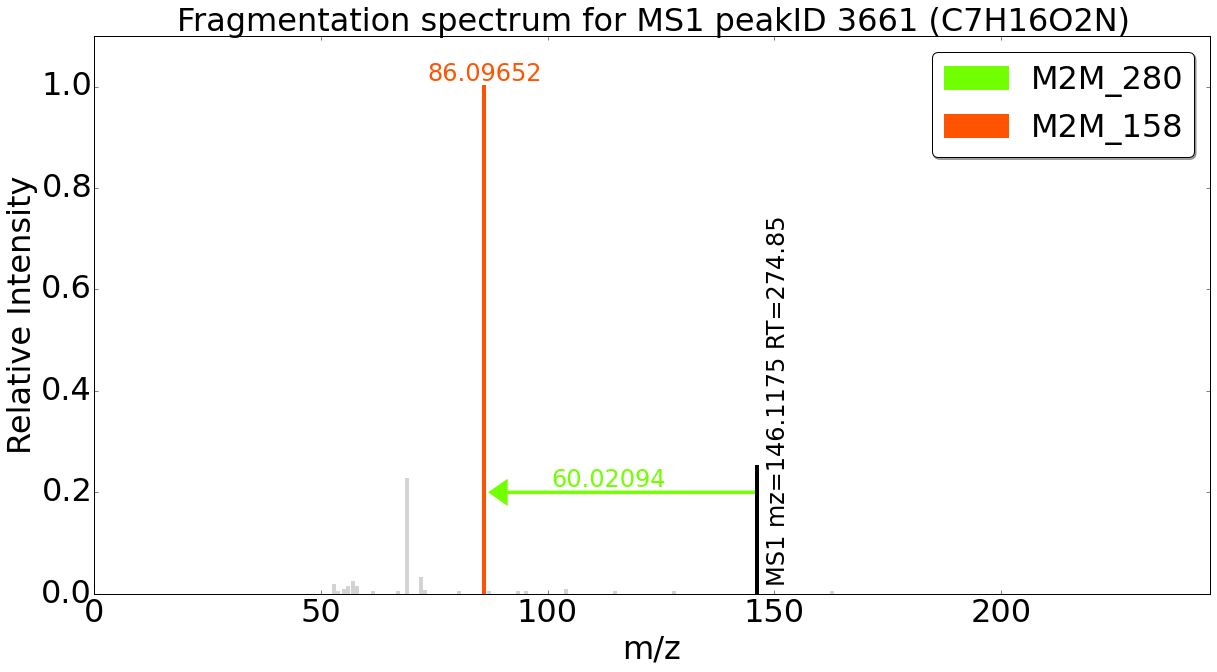

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0    86.096535       1.000000   fragment_86.09652             158   
1    69.070168       0.224988   fragment_69.07013             NaN   
2    72.080681       0.028643    fragment_72.0807             NaN   
3    57.057880       0.022176   fragment_57.05774             NaN   
4   146.117889       0.020063  fragment_146.11798             NaN   
5    53.002697       0.015558   fragment_53.00259             NaN   
6    58.065498       0.012176   fragment_58.06552             NaN   
7    56.049728       0.012087   fragment_56.04977             NaN   
8    55.054626       0.005469   fragment_55.05466             NaN   
9   104.071129       0.005084  fragment_104.07105             NaN   
10   73.064621       0.002896   fragment_73.06466             NaN   
11   67.054535       0.002468   fragment_67.05454             NaN   
12  162.648743       0.002434  fragment_162.64874             NaN   
13   61.464443       0.002293   fragment_61.46444             NaN   
14  128.001587       0.002237  fragment_128.00159             NaN   
15  114.787949       0.002161  fragment_114.78795             NaN   
16   87.120209       0.002135   fragment_87.12021             NaN   
17   93.534004       0.002087     fragment_93.534             NaN   
18   95.355988       0.001967   fragment_95.35599             NaN   
19   53.713093       0.001816   fragment_53.71309             NaN   
20   80.408745       0.001758   fragment_80.40874             NaN   

        loss_word  loss_motif                  ef  
0   loss_60.02094         280  C5H12N,loss_C2H4O2  
1   loss_77.04757         NaN   C5H9,loss_C2H7O2N  
2   loss_74.03681         NaN  C4H10N,loss_C3H6O2  
3    loss_89.0597         NaN        loss_C2H7ON3  
4             NaN         NaN            C7H16O2N  
5             NaN         NaN                C3HO  
6   loss_88.05232         NaN   C3H8N,loss_C4H8O2  
7   loss_90.06784         NaN  C3H6N,loss_C4H10O2  
8   loss_91.06316         NaN   C4H7,loss_C3H9O2N  
9             NaN         NaN            C4H10O2N  
10  loss_73.05269         NaN   C4H9O,loss_C3H7ON  
11  loss_79.06303         NaN                C5H7  
12            NaN         NaN                 NaN  
13            NaN         NaN                 NaN  
14            NaN         NaN                 NaN  
15            NaN         NaN                 NaN  
16            NaN         NaN                 NaN  
17            NaN         NaN                 NaN  
18            NaN         NaN                 NaN  
19            NaN         NaN                 NaN  
20            NaN         NaN                 NaN

 - No M2M for this MS1 peak at the specified thresholding levels



None

 - M2M_202	: Tryptophan related substructure
		  fragment_118.06544 (0.155),fragment_146.05935 (0.129),fragment_188.07061 (0.106),fragment_130.06468 (0.061),fragment_91.05413 (0.049),fragment_146.06086 (0.046),fragment_115.05435 (0.045),fragment_144.08061 (0.034),fragment_143.07379 (0.033),fragment_117.05719 (0.032),fragment_261.09335 (0.027),fragment_170.06037 (0.026),fragment_132.08143 (0.023),fragment_128.04963 (0.018),fragment_142.06476 (0.014),
 - M2M_211	: N-acetylputrescine substructure
		  loss_59.037 (0.567),fragment_114.09123 (0.097),loss_101.04757 (0.042),loss_59.00065 (0.030),fragment_131.11777 (0.029),fragment_425.1355 (0.029),fragment_72.04466 (0.023),fragment_60.04477 (0.014),
 - M2M_214	: Amine loss - suggests free NH2 group in fragmented molecule
		  loss_17.02527 (0.883),fragment_366.10831 (0.021),

(10364, 'C11H13O2N2')


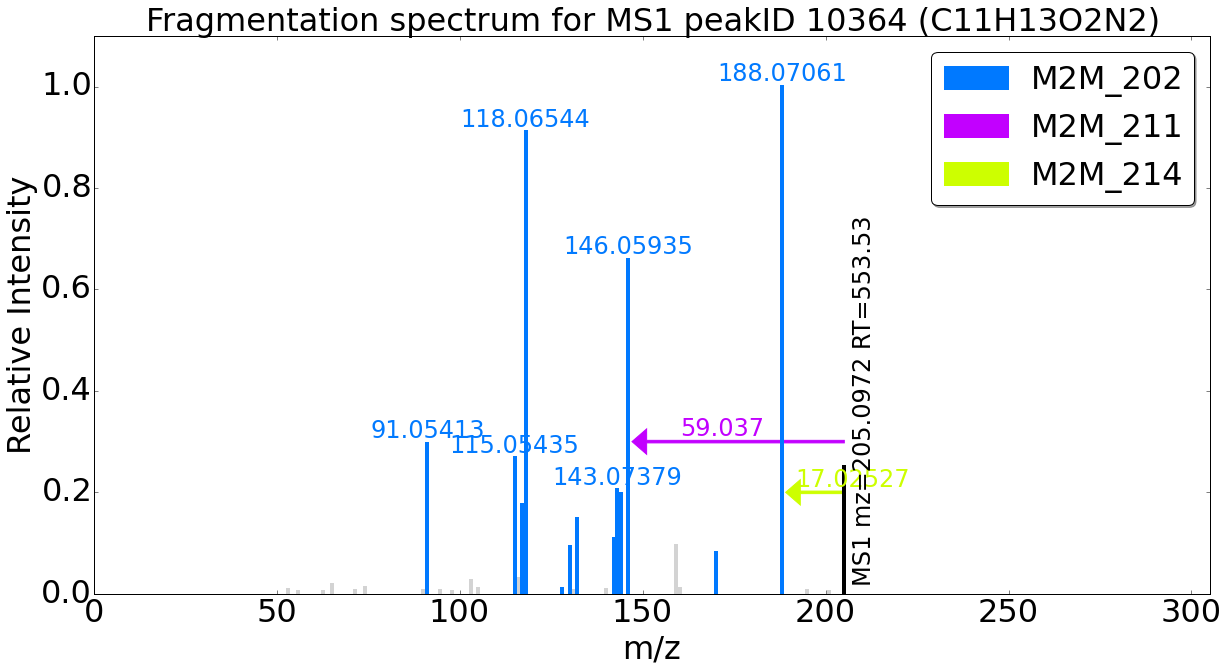

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0   188.070572       1.000000  fragment_188.07061             202   
1   118.065468       0.910780  fragment_118.06544             202   
2   146.059402       0.658810  fragment_146.05935             202   
3    91.054146       0.296194   fragment_91.05413             202   
4   115.054367       0.268003  fragment_115.05435             202   
5   143.073792       0.204197  fragment_143.07379             202   
6   144.080597       0.196105  fragment_144.08061             202   
7   117.057220       0.174524  fragment_117.05719             202   
8   132.081421       0.148421  fragment_132.08143             202   
9   142.064621       0.107717  fragment_142.06476             202   
10  159.092072       0.093365  fragment_159.09194             NaN   
11  130.064926       0.092998  fragment_130.06468             202   
12  170.060287       0.079957  fragment_170.06037             202   
13  117.070213       0.049186  fragment_117.07032             NaN   
14  116.061714       0.029525  fragment_116.06168             NaN   
15  103.054504       0.025196  fragment_103.05448             NaN   
16   65.038757       0.018240   fragment_65.03878             NaN   
17  144.044510       0.011550  fragment_144.04451             NaN   
18   74.023506       0.011242   fragment_74.02353             NaN   
19  128.049652       0.010137  fragment_128.04963             202   
20  160.074738       0.009748  fragment_160.07487             NaN   
21  105.070190       0.008810  fragment_105.07019             NaN   
22  140.049820       0.006626  fragment_140.04987             NaN   
23   53.038822       0.006565   fragment_53.03888             NaN   
24  194.995819       0.005492  fragment_194.99582             NaN   
25  131.073608       0.004939  fragment_131.07361             NaN   
26  116.049858       0.004885  fragment_116.04983             NaN   
27   94.437073       0.004633   fragment_94.43707             NaN   
28   90.046448       0.004632   fragment_90.04643             NaN   
29   71.331963       0.004574   fragment_71.33196             NaN   
30  200.874496       0.004374   fragment_200.8745             NaN   
31   62.521790       0.004293   fragment_62.52179             NaN   
32   97.889832       0.004228   fragment_97.88983             NaN   
33   55.876587       0.003906   fragment_55.87659             NaN   

         loss_word  loss_motif                   ef  
0    loss_17.02527         214            C11H10O2N  
1    loss_87.03196         NaN   C8H8N,loss_C3H5O2N  
2      loss_59.037         211  C3H9N5P,loss_C2H5ON  
3   loss_114.04263         NaN   C7H7,loss_C4H6O2N2  
4    loss_90.04283         NaN   C9H7,loss_C2H6O2N2  
5              NaN         NaN             C6H12N2P  
6    loss_61.01619         NaN  C10H10N,loss_CH3O2N  
7              NaN         NaN             C4H10N2P  
8    loss_73.01611         NaN  C9H10N,loss_C2H3O2N  
9    loss_63.03191         NaN   C10H8N,loss_CH5O2N  
10   loss_46.00539         NaN  C10H11N2,loss_CH2O2  
11   loss_75.03184         NaN   C9H8N,loss_C2H5O2N  
12   loss_35.03689         NaN              C11H8ON  
13   loss_88.02701         NaN   C9H9,loss_C2H4O2N2  
14             NaN         NaN                  NaN  
15  loss_102.04259         NaN   C8H7,loss_C3H6O2N2  
16  loss_140.05793         NaN     C5H5,loss_H9ON6P  
17   loss_61.05259         NaN   C9H6ON,loss_C2H7ON  
18             NaN         NaN              C2H4O2N  
19   loss_77.04757         NaN   C9H6N,loss_C2H7O2N  
20             NaN         NaN             C4H11N5P  
21  loss_100.02691         NaN   C8H9,loss_C3H4O2N2  
22   loss_65.04759         NaN               C10H6N  
23   loss_152.0579         NaN   C4H5,loss_C7H8O2N2  
24             NaN         NaN            C7H4O3N2P  
25   loss_74.02423         NaN             C5H12N2P  
26   loss_89.04752         NaN   C8H6N,loss_C3H7O2N  
27             NaN         NaN                  NaN  
28             NaN        

 - M2M_226	: Loss of [hexose-H2O] - suggests hexose conjugation (e.g. glucose) substructure
		  loss_162.05262 (0.797),fragment_317.064 (0.028),
 - M2M_131	: fragments from [hexose-H2O] substructure (a hexose conjugation, e.g. glucose)
		  fragment_85.02832 (0.566),fragment_69.03368 (0.105),fragment_97.02839 (0.088),fragment_61.02854 (0.070),fragment_57.0337 (0.045),fragment_91.03925 (0.022),fragment_127.03868 (0.021),fragment_73.0285 (0.019),fragment_55.01824 (0.019),

(33145, 'C15H28O15P')


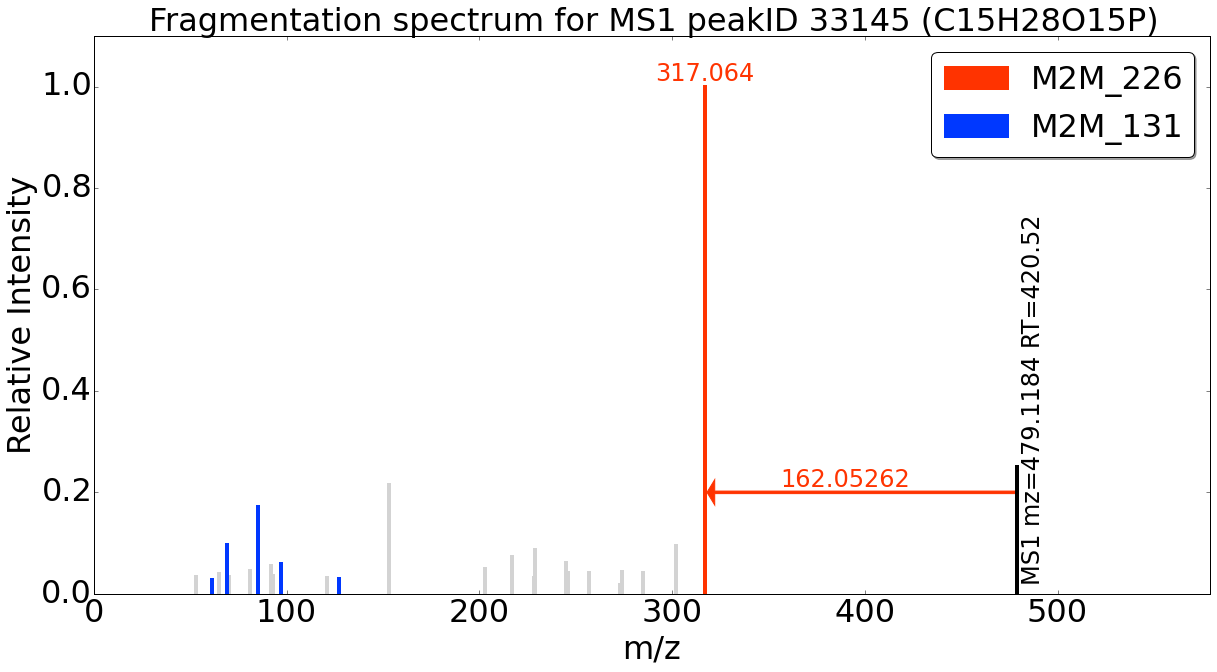

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0   317.063995       1.000000    fragment_317.064             226   
1   153.019180       0.213741    fragment_153.019             NaN   
2    85.028450       0.171488   fragment_85.02832             131   
3    69.033760       0.095460   fragment_69.03368             131   
4   302.042053       0.093837  fragment_302.04205             NaN   
5   229.050964       0.085711  fragment_229.05091             NaN   
6   217.051315       0.072029  fragment_217.05132             NaN   
7   245.042679       0.061531  fragment_245.04268             NaN   
8    97.028419       0.059057   fragment_97.02839             131   
9    92.026161       0.055226   fragment_92.02608             NaN   
10  203.033188       0.049476  fragment_203.03319             NaN   
11   81.033348       0.045536   fragment_81.03334             NaN   
12  274.048950       0.043472  fragment_274.04895             NaN   
13  285.040466       0.041462  fragment_285.04045             NaN   
14  257.043335       0.041420  fragment_257.04329             NaN   
15  246.053848       0.040869  fragment_246.05385             NaN   
16   65.038780       0.038728   fragment_65.03878             NaN   
17   93.033257       0.034560   fragment_93.03322             NaN   
18   53.038845       0.033923   fragment_53.03888             NaN   
19   70.065132       0.033623   fragment_70.06514             NaN   
20   68.997223       0.033247   fragment_68.99719             NaN   
21  121.028313       0.030711  fragment_121.02828             NaN   
22  228.041672       0.030277  fragment_228.04167             NaN   
23  127.038712       0.028840  fragment_127.03868             131   
24   61.028473       0.026914   fragment_61.02854             131   
25  273.040558       0.017061  fragment_273.04056             NaN   

         loss_word  loss_motif            ef  
0   loss_162.05262         226  loss_C6H10O5  
1              NaN         NaN       H5O2N6S  
2              NaN         NaN        C4H5O2  
3              NaN         NaN         C4H5O  
4              NaN         NaN           NaN  
5              NaN         NaN   C5H15O4N2P2  
6              NaN         NaN       C13H5N4  
7              NaN         NaN      C9H5O3N6  
8              NaN         NaN        C5H5O2  
9              NaN         NaN       C2H7ONP  
10             NaN         NaN     C5H8O3N4P  
11             NaN         NaN         C5H5O  
12             NaN         NaN   C11H17ONPS2  
13  loss_194.07849         NaN  loss_C7H14O6  
14             NaN         NaN      C7H14O8P  
15             NaN         NaN    C10H17NPS2  
16             NaN         NaN          C5H5  
17             NaN         NaN         C6H5O  
18             NaN         NaN          C4H5  
19             NaN         NaN         C4H8N  
20             NaN         NaN         C3HO2  
21             NaN         NaN        C7H5O2  
22             NaN         NaN   C3H12O3N5P2  
23             NaN         NaN        C6H7O3  
24             NaN         NaN        C2H5O2  
25             NaN         NaN    C9H14N4PS2

 - M2M_45	: Pipecolic acid (pipecolate) substructure
		  fragment_84.08071 (0.757),fragment_56.04977 (0.059),fragment_130.08587 (0.059),loss_91.06316 (0.022),fragment_67.05454 (0.015),
 - M2M_230	: N/O-acetylation loss
		  fragment_87.04391 (0.782),fragment_187.88232 (0.031),fragment_210.89943 (0.017),

(28111, 'C14H24O8P')


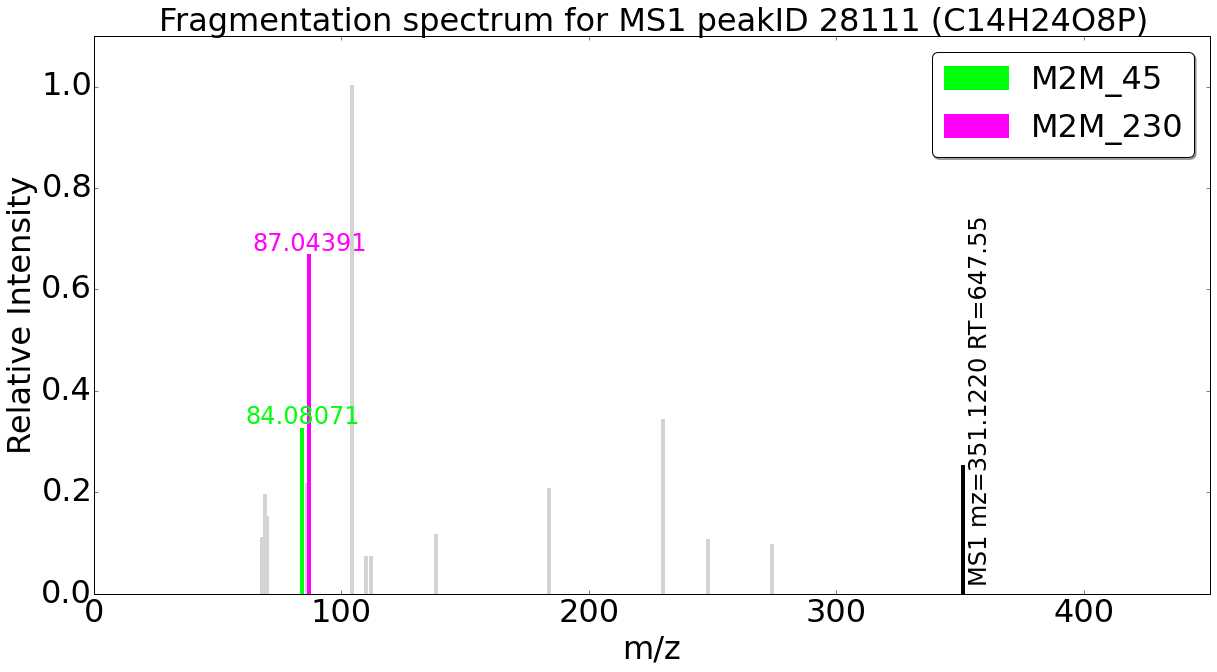

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0   104.071045       1.000000  fragment_104.07105             NaN   
1    87.043854       0.665415   fragment_87.04391             230   
2   230.047302       0.340197  fragment_230.04728             NaN   
3    84.080757       0.323888   fragment_84.08071              45   
4    86.060036       0.213617   fragment_86.06016             NaN   
5   184.043549       0.204206  fragment_184.04371             NaN   
6    69.033630       0.193476   fragment_69.03368             NaN   
7    70.065132       0.148881   fragment_70.06514             NaN   
8   138.037567       0.112986  fragment_138.03762             NaN   
9    68.049774       0.107138   fragment_68.04977             NaN   
10  248.057327       0.103800  fragment_248.05733             NaN   
11  274.126282       0.095038  fragment_274.12643             NaN   
12  112.021820       0.070264  fragment_112.02189             NaN   
13  110.059746       0.069649  fragment_110.05978             NaN   

         loss_word  loss_motif                         ef  
0              NaN         NaN                   C4H10O2N  
1              NaN         NaN                     C4H7O2  
2   loss_121.07393         NaN  C3H13O3N5PS,loss_C4H11O3N  
3              NaN         NaN                     C5H10N  
4              NaN         NaN                     C4H8ON  
5   loss_167.07941         NaN     C8H12NP2,loss_C5H13O5N  
6              NaN         NaN                      C4H5O  
7              NaN         NaN                      C4H8N  
8              NaN         NaN                     C7H8NS  
9              NaN         NaN                      C4H6N  
10  loss_103.06338         NaN     C13H14NS2,loss_C4H9O2N  
11             NaN         NaN                  C16H20ONS  
12             NaN         NaN                     C5H6NS  
13             NaN         NaN                     C6H8ON

 - No M2M for this MS1 peak at the specified thresholding levels



None

 - M2M_58	: Ethylphenol substructure (e.g. resulting from Tyramine - MzCloud)
		  fragment_121.06489 (0.412),fragment_103.05448 (0.103),fragment_93.06981 (0.082),fragment_53.03888 (0.080),fragment_91.05413 (0.071),fragment_152.10755 (0.027),loss_68.02601 (0.026),fragment_138.05067 (0.023),fragment_166.12292 (0.023),fragment_95.04936 (0.013),

(33516, 'C26H29O9N2')


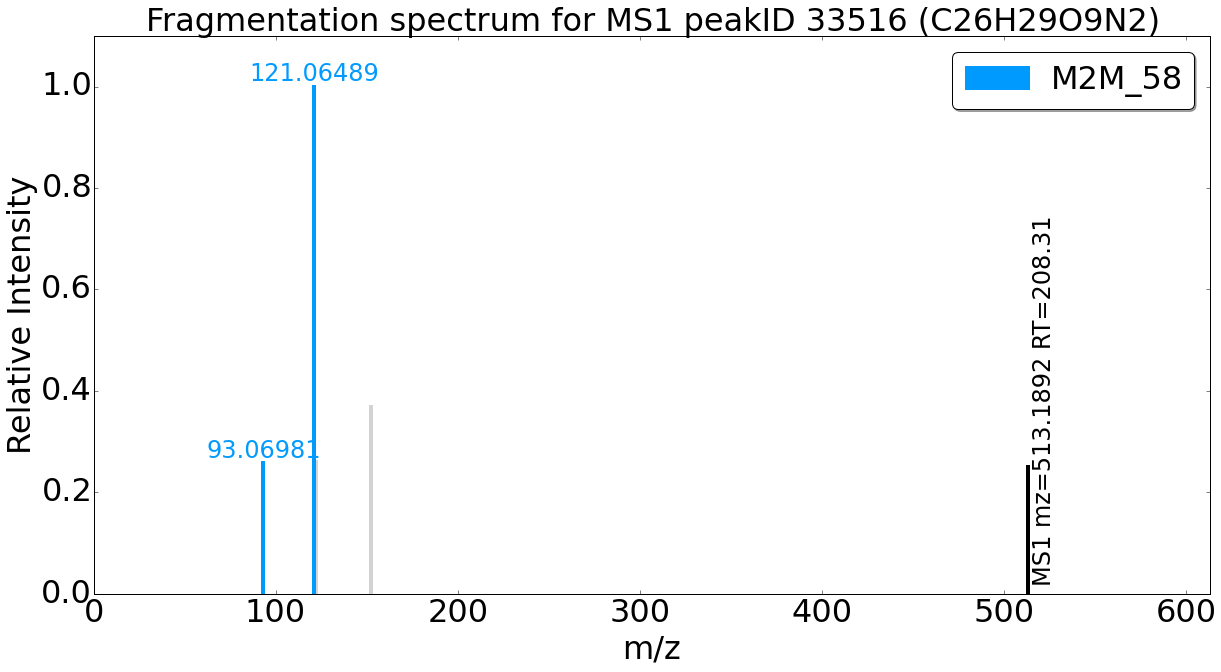

ms2_mz  ms2_intensity       fragment_word  fragment_motif  loss_word  \
0  121.064819       1.000000  fragment_121.06489              58        NaN   
1  152.105896       0.367560  fragment_152.10585             NaN        NaN   
2  122.067993       0.260767  fragment_122.06806             NaN        NaN   
3   93.069862       0.257240   fragment_93.06981              58        NaN   

   loss_motif        ef  
0         NaN     C8H9O  
1         NaN  C3H15N5P  
2         NaN       NaN  
3         NaN      C7H9

 - M2M_19	: Ferulic acid substructure
		  fragment_177.05475 (0.191),fragment_89.03864 (0.146),fragment_145.02839 (0.137),fragment_117.03316 (0.115),fragment_364.22203 (0.035),fragment_149.05998 (0.028),fragment_307.17496 (0.027),loss_137.08402 (0.024),loss_130.12154 (0.024),loss_193.07267 (0.016),loss_176.10859 (0.016),fragment_100.07536 (0.013),fragment_171.1487 (0.012),fragment_134.03657 (0.012),fragment_78.04655 (0.011),fragment_234.11111 (0.011),

(33851, 'C27H46O8N3')


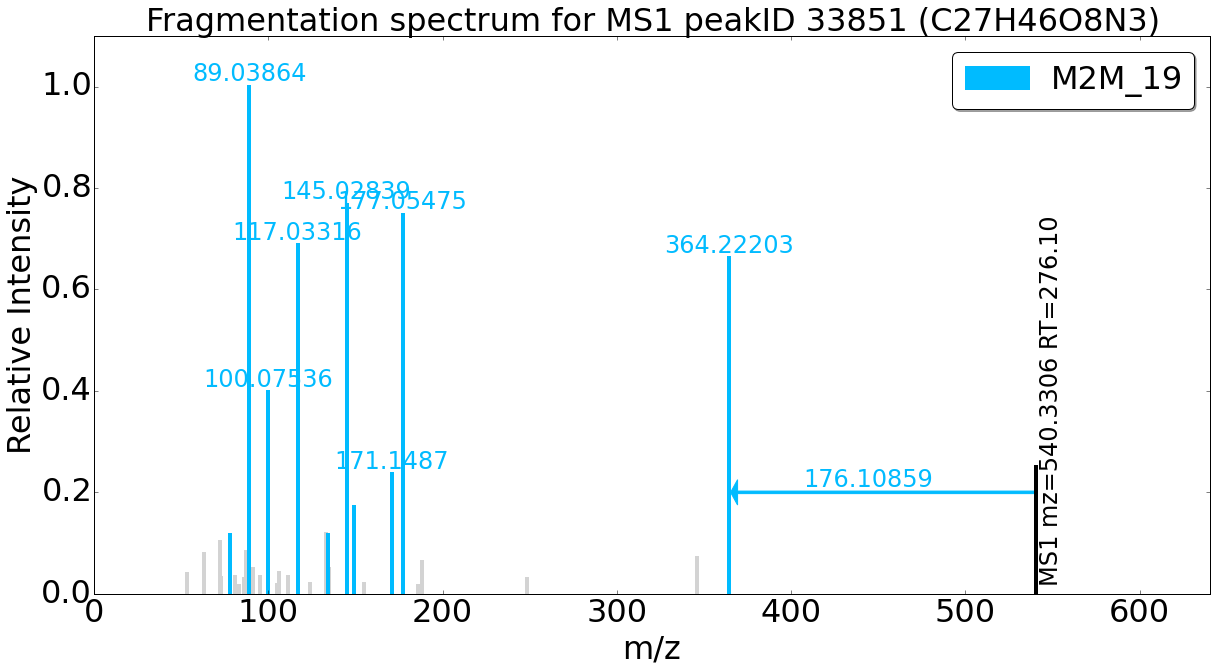

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0    89.038673       1.000000   fragment_89.03864              19   
1   145.028503       0.767045  fragment_145.02839              19   
2   177.054855       0.747576  fragment_177.05475              19   
3   117.033287       0.687655  fragment_117.03316              19   
4   364.222107       0.661516  fragment_364.22203              19   
5   100.075432       0.398203  fragment_100.07536              19   
6    89.060211       0.279273   fragment_89.06006             NaN   
7   171.148941       0.235758   fragment_171.1487              19   
8   149.060150       0.170191  fragment_149.05998              19   
9   133.086472       0.118651  fragment_133.08631             NaN   
10   78.046524       0.116408   fragment_78.04655              19   
11  134.036530       0.116124  fragment_134.03657              19   
12   72.080826       0.102249    fragment_72.0807             NaN   
13   87.043869       0.081501   fragment_87.04391             NaN   
14   63.023247       0.077501   fragment_63.02327             NaN   
15  346.214386       0.070115  fragment_346.21475             NaN   
16  188.176239       0.062870  fragment_188.17606             NaN   
17   91.054176       0.049781   fragment_91.05413             NaN   
18  135.044510       0.048300   fragment_135.0444             NaN   
19  177.112976       0.041589  fragment_177.11278             NaN   
20  106.041260       0.041452  fragment_106.04123             NaN   
21   53.038857       0.039535   fragment_53.03888             NaN   
22   95.049416       0.033723   fragment_95.04936             NaN   
23   81.033371       0.033109   fragment_81.03334             NaN   
24  111.044350       0.033047  fragment_111.04428             NaN   
25   72.044731       0.031109   fragment_72.04466             NaN   
26   73.028526       0.030869    fragment_73.0285             NaN   
27  248.127930       0.028480  fragment_248.12782             NaN   
28   86.096558       0.028205   fragment_86.09652             NaN   
29  155.070175       0.018773  fragment_155.07011             NaN   
30  124.051659       0.018750  fragment_124.05166             NaN   
31  105.033493       0.016652  fragment_105.03345             NaN   
32  186.054184       0.015946  fragment_186.05402             NaN   
33   83.048965       0.015664   fragment_83.04894             NaN   

         loss_word  loss_motif              ef  
0              NaN         NaN            C7H5  
1              NaN         NaN          C9H5O2  
2              NaN         NaN         C10H9O3  
3              NaN         NaN           C8H5O  
4   loss_176.10859          19  loss_C7H17ON2P  
5              NaN         NaN         C5H10ON  
6              NaN         NaN          C4H9O2  
7              NaN         NaN        C9H19ON2  
8              NaN         NaN          C9H9O2  
9              NaN         NaN         C6H13O3  
10             NaN         NaN          C2H9NP  
11             NaN         NaN        C4H9O2NP  
12             NaN         NaN          C4H10N  
13             NaN         NaN          C4H7O2  
14             NaN         NaN            C5H3  
15  loss_194.11521         NaN    loss_C8H18O5  
16             NaN         NaN        C9H22ON3  
17             NaN         NaN            C7H7  
18             NaN         NaN          C8H7O2  
19             NaN         NaN         C8H17O4  
20             NaN         NaN         C3H9ONP  
21             NaN         NaN            C4H5  
22             NaN         NaN           C6H7O  
23             NaN         NaN           C5H5O  
24             NaN         NaN          C6H7O2  
25             NaN         NaN          C3H6ON  
26             NaN         NaN          C3H5O2  
27             NaN         NaN      C8H19O2N5P  
28             NaN         NaN          C5H12N  
29             NaN         NaN         C8H11O3  
30             NaN         NaN       C3H11O2NP  
31             NaN      

 - No M2M for this MS1 peak at the specified thresholding levels



None

 - M2M_241	: Histidine substructure
		  fragment_110.07176 (0.384),fragment_83.06041 (0.112),fragment_93.04509 (0.070),fragment_156.07684 (0.049),loss_167.08599 (0.045),loss_191.06155 (0.035),fragment_363.17581 (0.023),fragment_56.04977 (0.023),loss_27.01101 (0.023),fragment_143.11757 (0.017),fragment_81.04501 (0.017),fragment_95.06076 (0.012),
 - M2M_262	: Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure
		  loss_46.00539 (0.854),loss_74.0003 (0.058),loss_47.0087 (0.017),fragment_100.11239 (0.016),

(4779, 'C6H10O2N3')


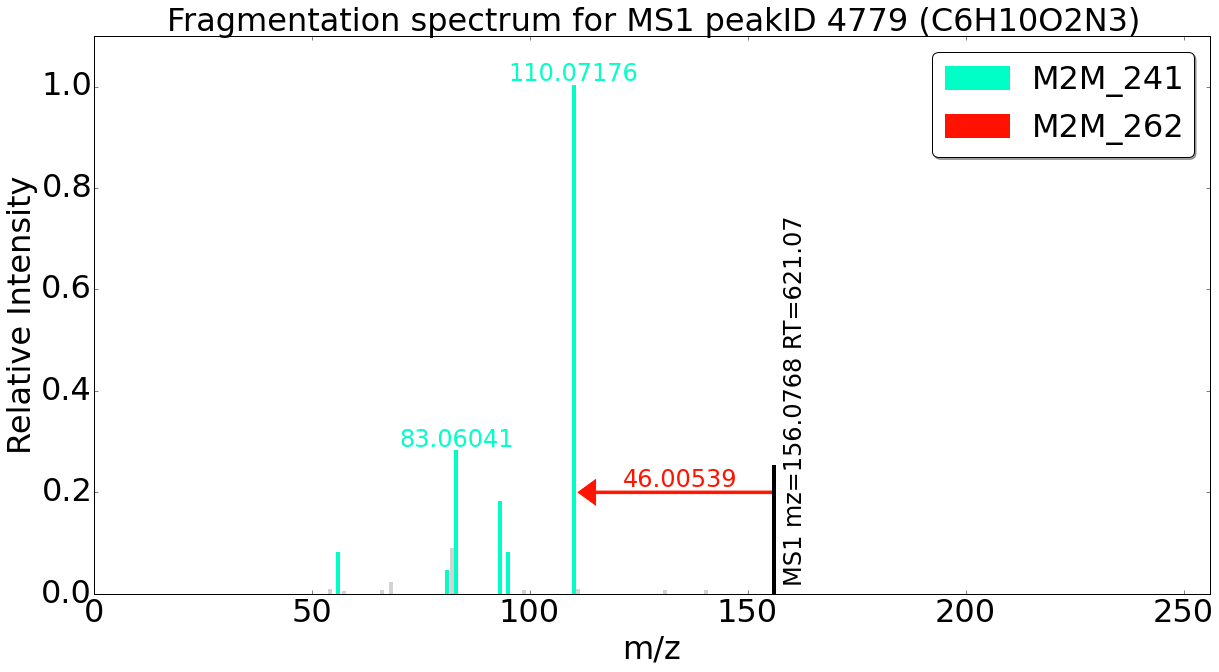

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0   110.071732       1.000000  fragment_110.07176             241   
1    83.060387       0.278632   fragment_83.06041             241   
2    93.045082       0.179380   fragment_93.04509             241   
3   156.076859       0.126547  fragment_156.07684             241   
4    82.052292       0.086159   fragment_82.05232             NaN   
5    56.049751       0.079081   fragment_56.04977             241   
6    95.060745       0.078197   fragment_95.06076             241   
7    81.045174       0.043758   fragment_81.04501             241   
8    68.050003       0.019948   fragment_68.04977             NaN   
9    54.034096       0.005103   fragment_54.03418             NaN   
10  111.055321       0.005010  fragment_111.05547             NaN   
11   66.034050       0.003564   fragment_66.03408             NaN   
12  140.476730       0.003301  fragment_140.47673             NaN   
13  130.999557       0.003083  fragment_130.99956             NaN   
14   98.749725       0.003005   fragment_98.74973             NaN   
15   81.040886       0.002932   fragment_81.04089             NaN   
16   57.255665       0.002342   fragment_57.25566             NaN   

         loss_word  loss_motif                   ef  
0    loss_46.00539         262    C5H8N3,loss_CH2O2  
1    loss_73.01611         NaN  C4H7N2,loss_C2H3O2N  
2    loss_63.03191         NaN   C5H5N2,loss_CH5O2N  
3              NaN         NaN            C6H10O2N3  
4    loss_74.02423         NaN                  NaN  
5   loss_100.02691         NaN  C3H6N,loss_C3H4O2N2  
6    loss_61.01619         NaN   C5H7N2,loss_CH3O2N  
7    loss_75.03184         NaN  C4H5N2,loss_C2H5O2N  
8    loss_88.02701         NaN  C4H6N,loss_C2H4O2N2  
9   loss_102.04259         NaN  C3H4N,loss_C3H6O2N2  
10   loss_45.02125         NaN   C5H7ON2,loss_CH3ON  
11   loss_90.04283         NaN  C4H4N,loss_C2H6O2N2  
12             NaN         NaN                  NaN  
13             NaN         NaN                  NaN  
14             NaN         NaN                  NaN  
15             NaN         NaN                  NaN  
16             NaN         NaN                  NaN

 - M2M_158	: Leucine substructure
		  fragment_86.09652 (0.794),fragment_132.10154 (0.048),fragment_219.90121 (0.031),fragment_293.3515 (0.031),fragment_189.12428 (0.012),

(34352, 'C41H74ONS2')


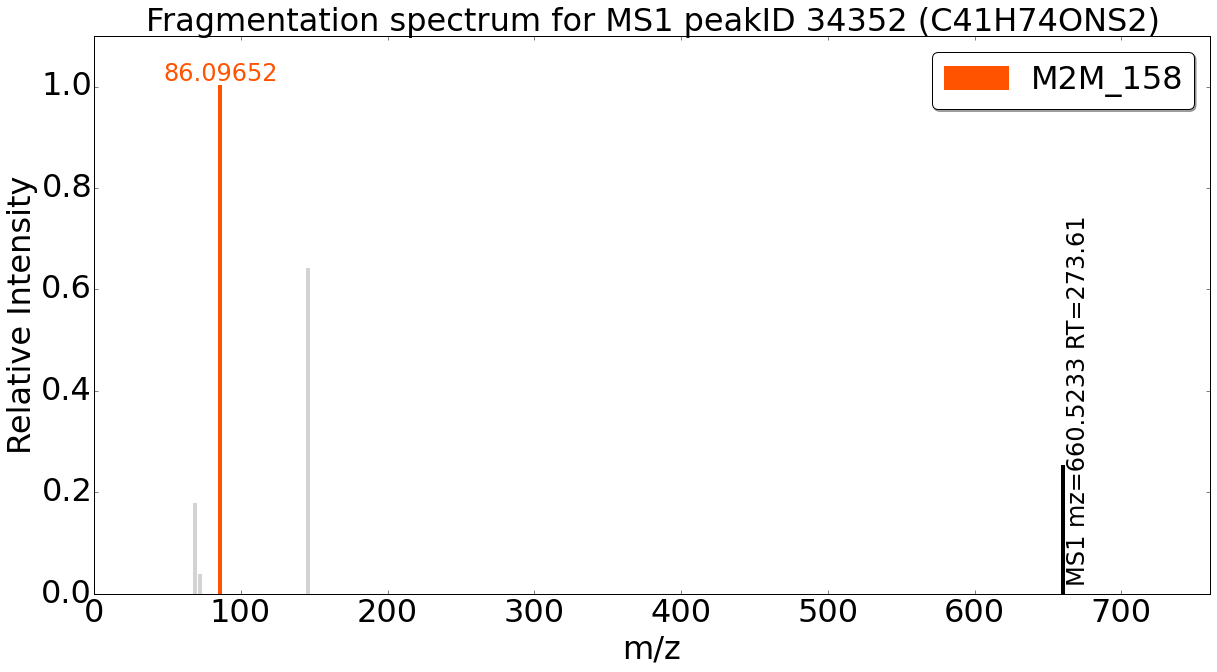

ms2_mz  ms2_intensity       fragment_word  fragment_motif  loss_word  \
0   86.096680       1.000000   fragment_86.09652             158        NaN   
1  146.118179       0.638728  fragment_146.11798             NaN        NaN   
2   69.070251       0.175771   fragment_69.07013             NaN        NaN   
3   72.080711       0.035805    fragment_72.0807             NaN        NaN   

   loss_motif        ef  
0         NaN    C5H12N  
1         NaN  C7H16O2N  
2         NaN      C5H9  
3         NaN    C4H10N

 - M2M_69	: Possibly suggests 2-OH-4-oxo-pentanoic acid substructure
		  fragment_69.03368 (0.633),fragment_57.0337 (0.190),fragment_99.04377 (0.025),fragment_55.01824 (0.024),fragment_53.03888 (0.019),fragment_53.00259 (0.019),fragment_99.04454 (0.011),
 - M2M_230	: N/O-acetylation loss
		  fragment_87.04391 (0.782),fragment_187.88232 (0.031),fragment_210.89943 (0.017),

(34211, 'C26H42O13NS')


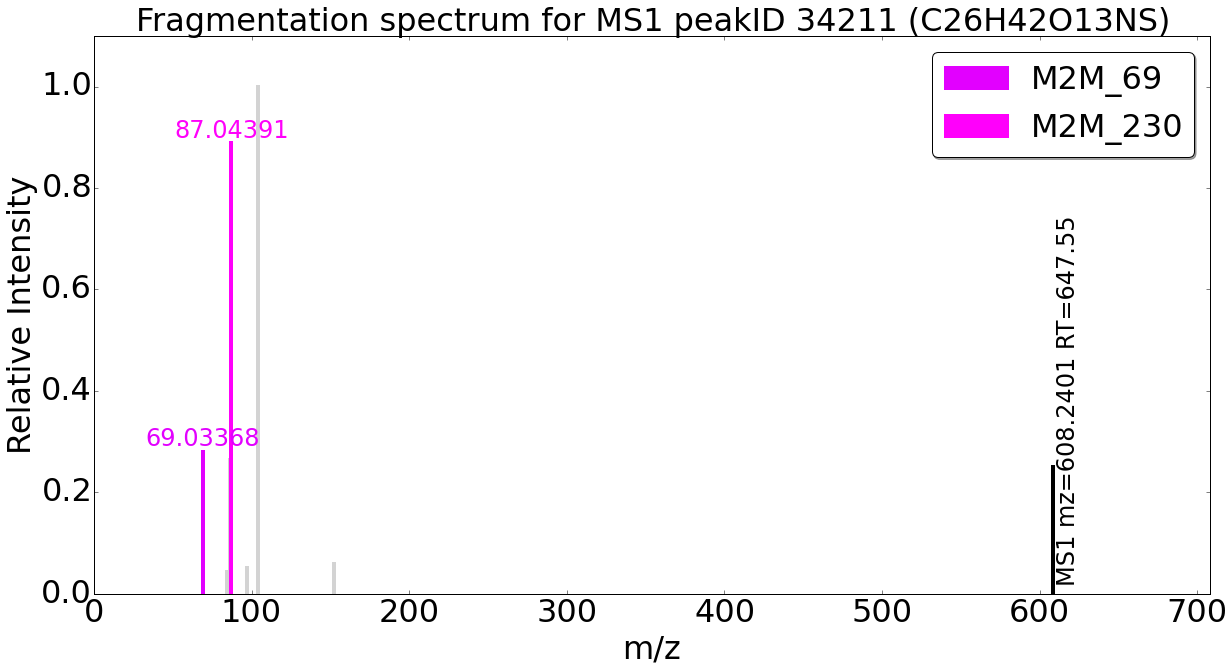

ms2_mz  ms2_intensity       fragment_word  fragment_motif  loss_word  \
0  104.070999       1.000000  fragment_104.07105             NaN        NaN   
1   87.043823       0.888749   fragment_87.04391             230        NaN   
2   69.033653       0.280470   fragment_69.03368              69        NaN   
3   86.060059       0.264726   fragment_86.06016             NaN        NaN   
4  152.055954       0.059535  fragment_152.05609             NaN        NaN   
5   97.028336       0.050036   fragment_97.02839             NaN        NaN   
6   84.080658       0.043620   fragment_84.08071             NaN        NaN   

   loss_motif        ef  
0         NaN  C4H10O2N  
1         NaN    C4H7O2  
2         NaN     C4H5O  
3         NaN    C4H8ON  
4         NaN  C4H10O5N  
5         NaN    C5H5O2  
6         NaN    C5H10N

 - M2M_131	: fragments from [hexose-H2O] substructure (a hexose conjugation, e.g. glucose)
		  fragment_85.02832 (0.566),fragment_69.03368 (0.105),fragment_97.02839 (0.088),fragment_61.02854 (0.070),fragment_57.0337 (0.045),fragment_91.03925 (0.022),fragment_127.03868 (0.021),fragment_73.0285 (0.019),fragment_55.01824 (0.019),

(16934, 'C9H17O8')


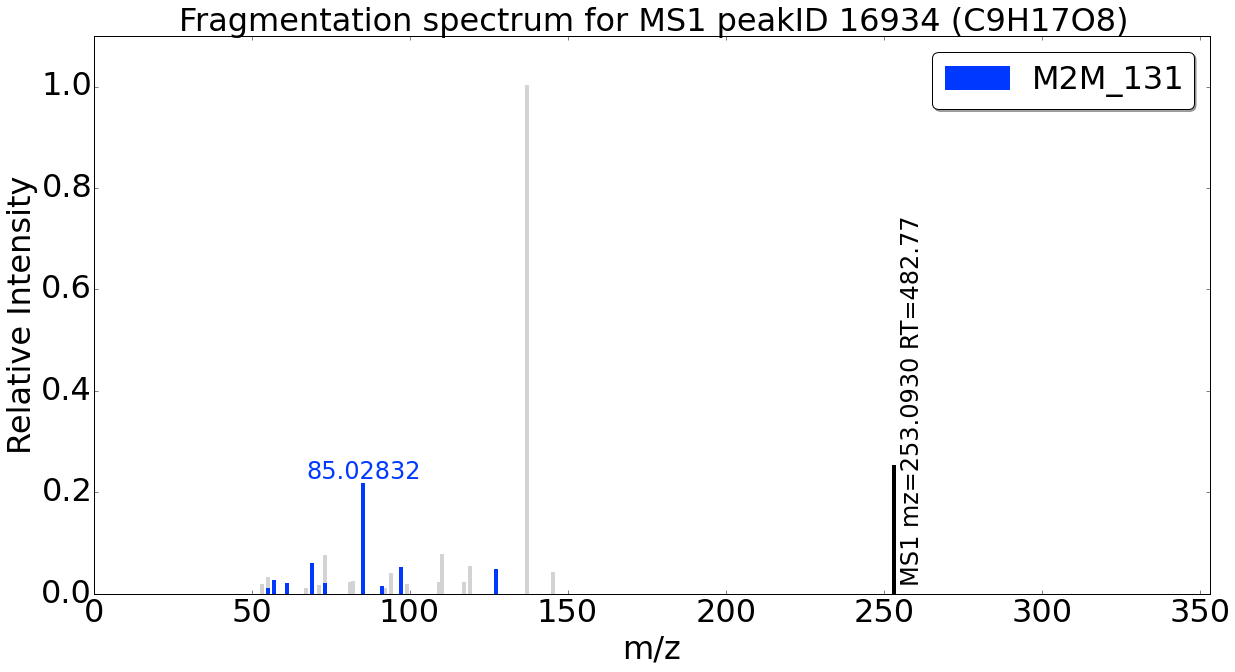

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0   137.046188       1.000000  fragment_137.04626             NaN   
1    85.028358       0.215218   fragment_85.02832             131   
2   110.034615       0.075151  fragment_110.03458             NaN   
3    73.064690       0.073162   fragment_73.06466             NaN   
4    69.033699       0.057387   fragment_69.03368             131   
5   119.035179       0.051025  fragment_119.03518             NaN   
6    97.028442       0.048887   fragment_97.02839             131   
7   127.038818       0.045624  fragment_127.03868             131   
8   145.050140       0.039821  fragment_145.04997             NaN   
9    94.039696       0.037138    fragment_94.0397             NaN   
10   55.054718       0.028857   fragment_55.05466             NaN   
11   57.033768       0.024014    fragment_57.0337             131   
12   55.029484       0.022148   fragment_55.02948             NaN   
13   82.040283       0.021178   fragment_82.04025             NaN   
14   81.033356       0.020041   fragment_81.03334             NaN   
15  117.054893       0.019986  fragment_117.05474             NaN   
16  109.028839       0.018403  fragment_109.02882             NaN   
17   73.028465       0.017620    fragment_73.0285             131   
18   61.028591       0.017015   fragment_61.02854             131   
19   99.044548       0.016163   fragment_99.04454             NaN   
20   53.038898       0.014469   fragment_53.03888             NaN   
21   71.049316       0.012583   fragment_71.04937             NaN   
22   91.039169       0.011231   fragment_91.03925             131   
23   55.018215       0.008360   fragment_55.01824             131   
24   67.029015       0.008082   fragment_67.02909             NaN   
25   92.024361       0.007284   fragment_92.02437             NaN   
26   53.002575       0.006727   fragment_53.00259             NaN   

         loss_word  loss_motif                     ef  
0   loss_116.04688         NaN    C5H5ON4,loss_C5H8O3  
1   loss_168.06319         NaN    C4H5O2,loss_C5H12O6  
2   loss_143.05783         NaN   C4H4ON3,loss_C6H9O3N  
3    loss_180.0276         NaN   C4H9O,loss_C6H12O2S2  
4   loss_184.05838         NaN     C4H5O,loss_C5H12O7  
5   loss_134.05766         NaN    C5H3N4,loss_C5H10O4  
6   loss_156.06317         NaN   C5H5O2,loss_C5H8O2N4  
7    loss_126.0526         NaN                 C6H7O3  
8    loss_108.0422         NaN     C6H9O4,loss_C3H8O4  
9   loss_159.05302         NaN    C4H4N3,loss_C6H9O4N  
10  loss_198.03757         NaN      C4H7,loss_C5H10O8  
11  loss_196.05793         NaN     C3H5O,loss_C6H12O7  
12  loss_198.06389         NaN  C2H3N2,loss_C8H10O4N2  
13  loss_171.05283         NaN    C3H4N3,loss_C7H9O4N  
14  loss_172.05826         NaN     C5H5O,loss_C8H14P2  
15  loss_136.03725         NaN     C5H9O3,loss_C4H8O5  
16             NaN         NaN                 C6H5O2  
17  loss_180.06318         NaN    C3H5O2,loss_C6H12O6  
18  loss_192.06323         NaN    C2H5O2,loss_C7H12O6  
19  loss_154.04768         NaN    C5H7O2,loss_C4H10O6  
20             NaN         NaN                   C4H5  
21  loss_182.04282         NaN     C4H7O,loss_C5H10O7  
22  loss_162.05262         NaN    C3H7O3,loss_C6H10O5  
23  loss_198.07403         NaN     C3H3O,loss_C6H14O7  
24  loss_186.06392         NaN  C3H3N2,loss_C7H10O4N2  
25  loss_161.06841         NaN   C4H2N3,loss_C6H11O4N  
26             NaN         NaN                   C3HO

 - M2M_162	: Xanthine substructure
		  fragment_152.05609 (0.327),fragment_153.04074 (0.126),loss_115.06303 (0.067),loss_151.04878 (0.045),fragment_110.03458 (0.040),fragment_135.02953 (0.036),loss_116.06671 (0.031),loss_197.05414 (0.020),fragment_128.04551 (0.020),fragment_314.11224 (0.016),loss_114.07908 (0.016),

(23726, 'C9H15O6N6')


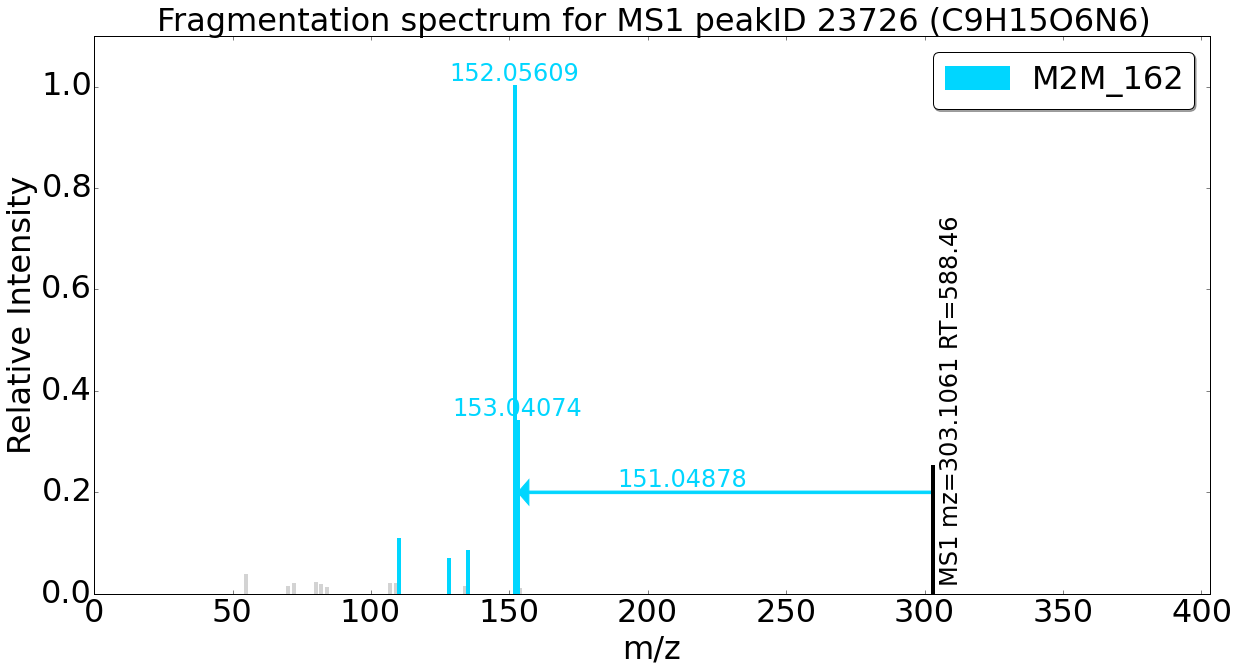

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0   152.055954       1.000000  fragment_152.05609             162   
1   153.040619       0.339539  fragment_153.04074             162   
2   110.034569       0.105750  fragment_110.03458             162   
3   135.029480       0.082875  fragment_135.02953             162   
4   128.045578       0.067552  fragment_128.04551             162   
5    55.029514       0.034106   fragment_55.02948             NaN   
6    80.024353       0.018481   fragment_80.02432             NaN   
7   109.050369       0.016571  fragment_109.05053             NaN   
8   107.035431       0.016434   fragment_107.0353             NaN   
9    72.080605       0.016415    fragment_72.0807             NaN   
10   82.040146       0.014423   fragment_82.04025             NaN   
11   70.065056       0.011606   fragment_70.06514             NaN   
12  134.046646       0.011588  fragment_134.04671             NaN   
13   84.080643       0.009860   fragment_84.08071             NaN   
14  154.023972       0.007827  fragment_154.02397             NaN   

         loss_word  loss_motif                       ef  
0   loss_151.04878         162   C4H10O5N,loss_C5H13NS2  
1              NaN         NaN                 C5H13OS2  
2   loss_193.07267         NaN  C4H4ON3,loss_C4H12O2N5P  
3   loss_168.07692         NaN  C5H11S2,loss_C3H13O2N4P  
4    loss_175.0595         NaN   C4H6O2N3,loss_C5H9O4N3  
5              NaN         NaN                   C2H3N2  
6              NaN         NaN                   C3H2N3  
7              NaN         NaN                   C4H5N4  
8   loss_196.06899         NaN    C4H3N4,loss_C7H17O2PS  
9              NaN         NaN                   C4H10N  
10             NaN         NaN                   C3H4N3  
11             NaN         NaN                    C4H8N  
12  loss_169.05873         NaN     C5H4N5,loss_C4H11O6N  
13             NaN         NaN                   C5H10N  
14  loss_149.08142         NaN  C5H4O3N3,loss_C4H11O3N3

 - No M2M for this MS1 peak at the specified thresholding levels



None

 - M2M_241	: Histidine substructure
		  fragment_110.07176 (0.384),fragment_83.06041 (0.112),fragment_93.04509 (0.070),fragment_156.07684 (0.049),loss_167.08599 (0.045),loss_191.06155 (0.035),fragment_363.17581 (0.023),fragment_56.04977 (0.023),loss_27.01101 (0.023),fragment_143.11757 (0.017),fragment_81.04501 (0.017),fragment_95.06076 (0.012),
 - M2M_115	: [phenylalanine-COOH] substructure
		  fragment_120.0804 (0.513),fragment_103.05448 (0.153),fragment_166.08631 (0.070),loss_45.99208 (0.048),fragment_93.06981 (0.020),fragment_91.05413 (0.020),fragment_53.03888 (0.018),
 - M2M_158	: Leucine substructure
		  fragment_86.09652 (0.794),fragment_132.10154 (0.048),fragment_219.90121 (0.031),fragment_293.3515 (0.031),fragment_189.12428 (0.012),

(20242, 'C14H22N4P')


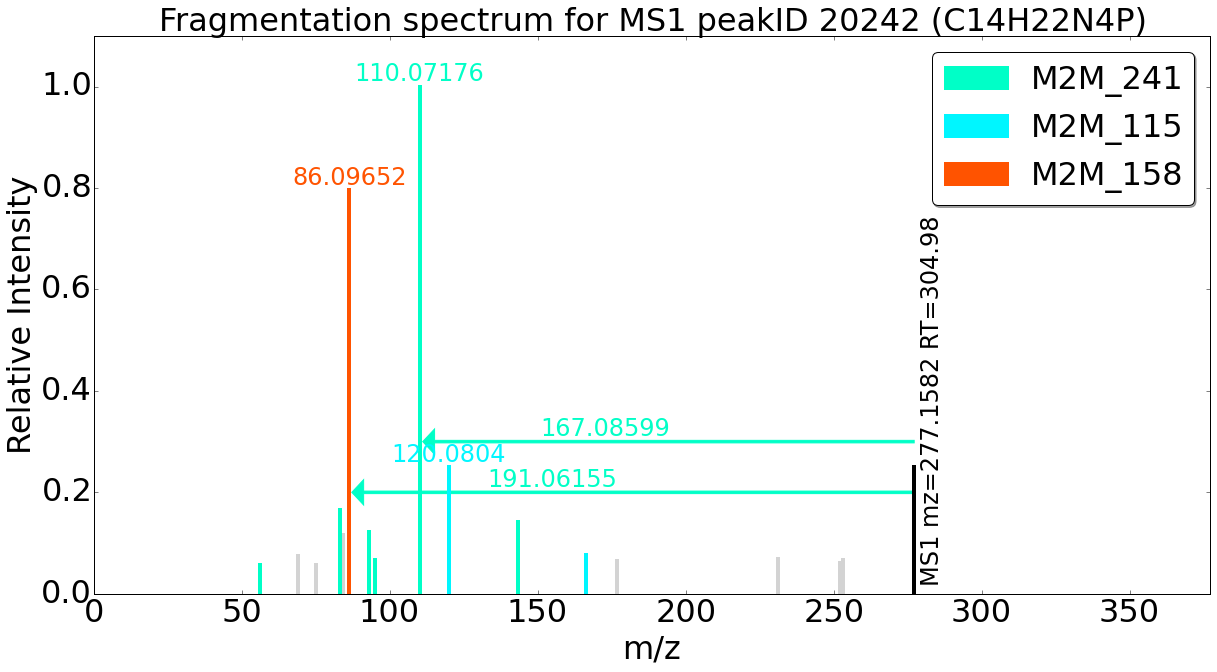

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0   110.071754       1.000000  fragment_110.07176             241   
1    86.096474       0.796268   fragment_86.09652             158   
2   120.080391       0.249161   fragment_120.0804             115   
3    83.060364       0.165243   fragment_83.06041             241   
4   143.117523       0.140728  fragment_143.11757             241   
5    93.045067       0.122521   fragment_93.04509             241   
6    84.043983       0.115356    fragment_84.0442             NaN   
7   166.086273       0.076998  fragment_166.08631             115   
8    69.070053       0.075184   fragment_69.07013             NaN   
9   231.113113       0.069172  fragment_231.11317             NaN   
10   95.060730       0.067388   fragment_95.06076             241   
11  253.090622       0.066788  fragment_253.09062             NaN   
12  176.876022       0.064931  fragment_176.87617             NaN   
13  252.108200       0.060339  fragment_252.10822             NaN   
14   56.049686       0.057397   fragment_56.04977             241   
15   75.055046       0.056338   fragment_75.05505             NaN   

         loss_word  loss_motif                     ef  
0   loss_167.08599         241    C5H8N3,loss_C9H14NP  
1   loss_191.06155         241  C5H12N,loss_C7H13O3NS  
2              NaN         NaN                 C8H10N  
3   loss_194.09798         NaN   C4H7N2,loss_C8H18O3S  
4              NaN         NaN               C7H15ON2  
5              NaN         NaN                 C5H5N2  
6              NaN         NaN                 C4H6ON  
7              NaN         NaN               C9H12O2N  
8              NaN         NaN                   C5H9  
9              NaN         NaN             C13H15O2N2  
10             NaN         NaN                 C5H7N2  
11             NaN         NaN             C6H17ON6S2  
12             NaN         NaN                    NaN  
13             NaN         NaN               C9H18O7N  
14             NaN         NaN                  C3H6N  
15             NaN         NaN                C2H7ON2

 - M2M_162	: Xanthine substructure
		  fragment_152.05609 (0.327),fragment_153.04074 (0.126),loss_115.06303 (0.067),loss_151.04878 (0.045),fragment_110.03458 (0.040),fragment_135.02953 (0.036),loss_116.06671 (0.031),loss_197.05414 (0.020),fragment_128.04551 (0.020),fragment_314.11224 (0.016),loss_114.07908 (0.016),
 - M2M_2	: Small nitrogen containing fragment ion - often proline or ornithine derived
		  fragment_70.06514 (0.979),

(18500, 'C9H19O7N2')


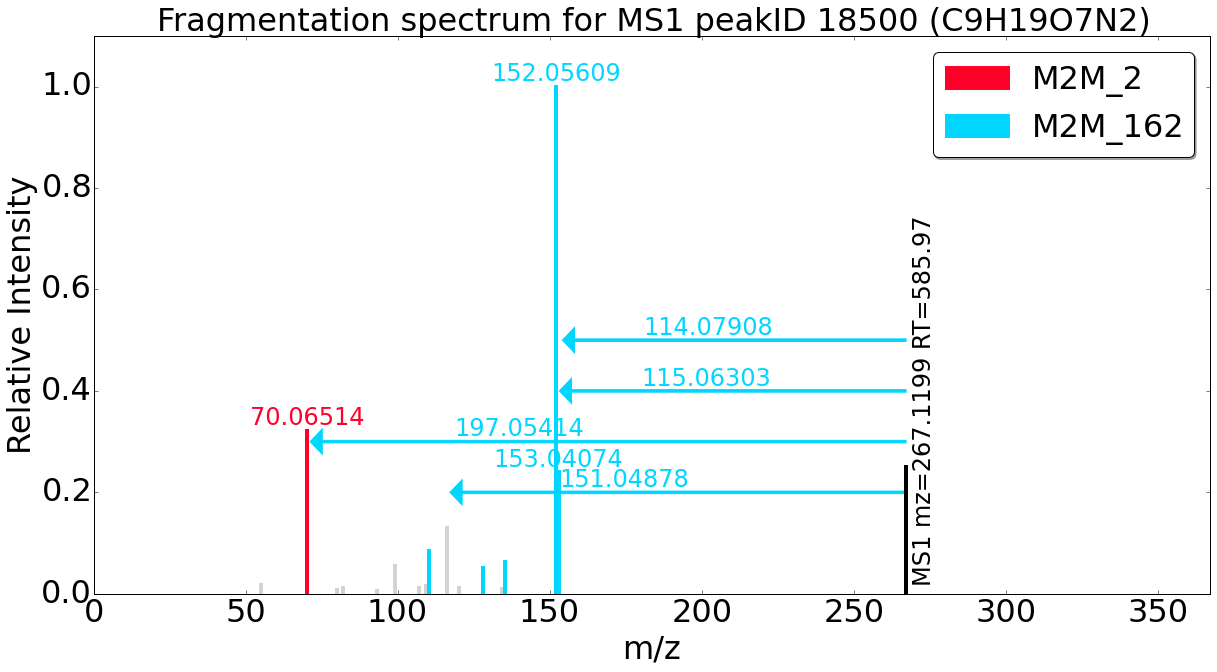

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0   152.056046       1.000000  fragment_152.05609             162   
1    70.065208       0.321892   fragment_70.06514               2   
2   153.040680       0.239134  fragment_153.04074             162   
3   116.071243       0.129606  fragment_116.07116             NaN   
4   110.034637       0.083660  fragment_110.03458             162   
5   135.029541       0.063122  fragment_135.02953             162   
6    98.983894       0.055744   fragment_98.98385             NaN   
7   128.045502       0.051102  fragment_128.04551             162   
8    55.029579       0.016861   fragment_55.02948             NaN   
9   109.050385       0.015613  fragment_109.05053             NaN   
10  107.035156       0.012378   fragment_107.0353             NaN   
11   82.040283       0.012228   fragment_82.04025             NaN   
12  120.044197       0.010728  fragment_120.04414             NaN   
13  134.046738       0.010415  fragment_134.04671             NaN   
14   80.024338       0.008123   fragment_80.02432             NaN   
15   93.008530       0.004807   fragment_93.00853             NaN   

         loss_word  loss_motif                      ef  
0   loss_115.06303         162   C4H10O5N,loss_C5H9O2N  
1   loss_197.05414         162   C4H8N,loss_C6H15O2NS2  
2   loss_114.07908         162  C5H13OS2,loss_C5H10ON2  
3   loss_151.04878         162  C5H10O2N,loss_C5H13NS2  
4   loss_157.08486         NaN  C4H4ON3,loss_C6H11O2N3  
5   loss_132.08964         NaN  C5H11S2,loss_C5H12O2N2  
6              NaN         NaN                   H4O4P  
7              NaN         NaN                C4H6O2N3  
8              NaN         NaN                  C2H3N2  
9   loss_158.06888         NaN   C4H5N4,loss_C6H10O3N2  
10  loss_160.08466         NaN   C4H3N4,loss_C6H12O3N2  
11  loss_185.08026         NaN   C3H4N3,loss_C7H11O3N3  
12             NaN         NaN                  C7H6ON  
13  loss_133.07377         NaN    C5H4N5,loss_C5H11O3N  
14             NaN         NaN                  C3H2N3  
15  loss_174.11207         NaN   C4HON2,loss_C6H14O2N4

 - M2M_260	: Water loss - indicative of a free hydroxyl group
		  loss_18.00923 (0.942),fragment_176.09136 (0.015),
 - M2M_60	: Double water loss - indicative for metabolites containing multiple OH groups and aliphatic chain, e.g. as in sugars
		  loss_36.01851 (0.913),

(24306, 'C17H28NP2')


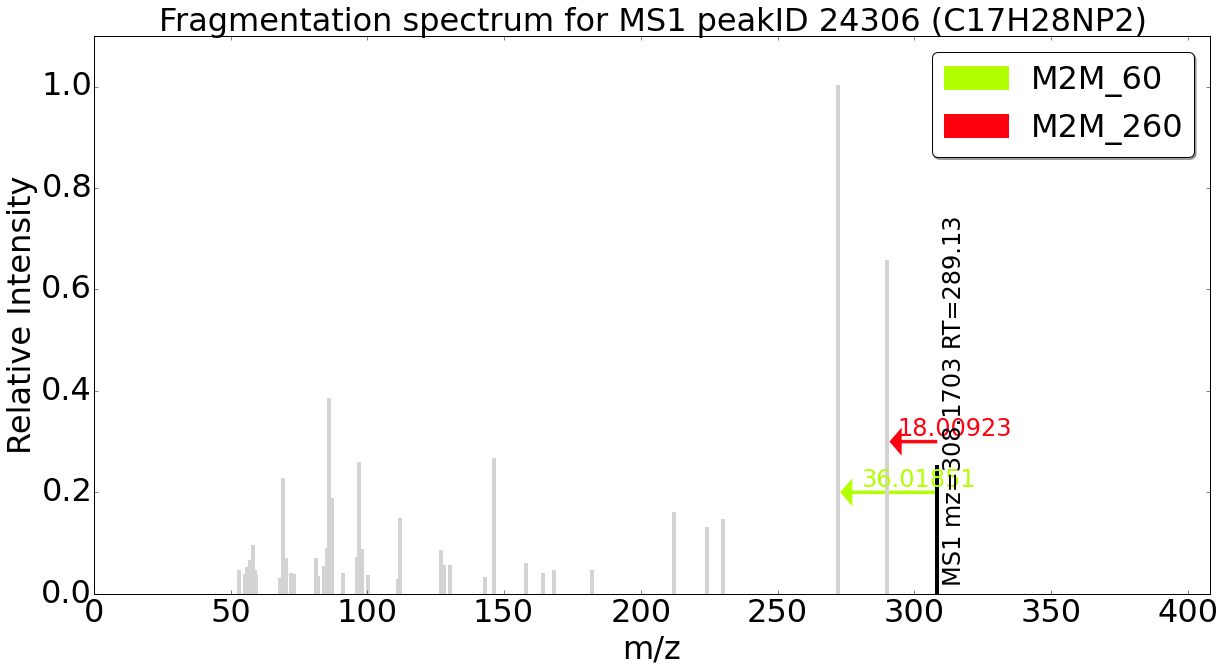

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0   272.148071       1.000000  fragment_272.14812             NaN   
1   290.160919       0.654807    fragment_290.161             NaN   
2    86.096451       0.382278   fragment_86.09652             NaN   
3   146.117783       0.263129  fragment_146.11798             NaN   
4    97.028267       0.256105   fragment_97.02839             NaN   
5    69.070076       0.224801   fragment_69.07013             NaN   
6    87.031425       0.185492   fragment_87.03155             NaN   
7    69.033630       0.165199   fragment_69.03368             NaN   
8   212.127533       0.156615  fragment_212.12758             NaN   
9   112.039787       0.145419  fragment_112.03981             NaN   
10  230.139709       0.144452  fragment_230.13972             NaN   
11  224.127304       0.128154  fragment_224.12746             NaN   
12   58.029022       0.092069   fragment_58.02903             NaN   
13   85.028381       0.085656   fragment_85.02832             NaN   
14   98.096680       0.083499   fragment_98.09683             NaN   
15  127.038261       0.082030  fragment_127.03868             NaN   
16   96.044075       0.068092   fragment_96.04413             NaN   
17   70.065201       0.067412   fragment_70.06514             NaN   
18   81.033318       0.066076   fragment_81.03334             NaN   
19   57.033657       0.063362    fragment_57.0337             NaN   
20  158.118256       0.056509  fragment_158.11806             NaN   
21  130.122147       0.053406  fragment_130.12227             NaN   
22  128.107132       0.052169  fragment_128.10733             NaN   
23   84.044052       0.050923    fragment_84.0442             NaN   
24   56.049831       0.048792   fragment_56.04977             NaN   
25  182.116943       0.043846  fragment_182.11721             NaN   
26   59.036816       0.043754   fragment_59.03687             NaN   
27  168.102051       0.042482   fragment_168.1022             NaN   
28   53.002518       0.042197   fragment_53.00259             NaN   
29   72.044037       0.037978   fragment_72.04409             NaN   
30   91.054031       0.036249   fragment_91.05413             NaN   
31  164.106415       0.036202  fragment_164.10654             NaN   
32   55.054558       0.035921   fragment_55.05466             NaN   
33   73.028412       0.035355    fragment_73.0285             NaN   
34  100.039169       0.034026  fragment_100.03925             NaN   
35   55.018154       0.033966   fragment_55.01824             NaN   
36   59.049294       0.033201    fragment_59.0494             NaN   
37   70.028893       0.032184   fragment_70.02895             NaN   
38  100.111336       0.030574  fragment_100.11134             NaN   
39   82.064880       0.030490   fragment_82.06499             NaN   
40  143.057434       0.029371  fragment_143.05755             NaN   
41  308.147064       0.026624  fragment_308.14726             NaN   
42   68.049721       0.026425   fragment_68.04977             NaN   
43  111.044174       0.025388  fragment_111.04428             NaN   
44   53.039135       0.021430   fragment_53.03888             NaN   

         loss_word  loss_motif                     ef  
0    loss_36.01851          60             C7H23O4N5P  
1    loss_18.00923         260                    NaN  
2              NaN         NaN                 C5H12N  
3   loss_162.05262         NaN  C7H16O2N,loss_C6H10O5  
4              NaN         NaN                 C5H5O2  
5              NaN         NaN                   C5H9  
6              NaN         NaN                    NaN  
7              NaN         NaN                  C4H5O  
8    loss_96.04225         NaN             C5H19O2N5P  
9              NaN         NaN                C5H6O2N  
10   loss_78.03031         NaN              C11H20O4N  
11   loss_84.04274         NaN             C6H19O2N5P  
12             NaN         NaN                 C2H4ON  
13             NaN         NaN                 C4

 - M2M_241	: Histidine substructure
		  fragment_110.07176 (0.384),fragment_83.06041 (0.112),fragment_93.04509 (0.070),fragment_156.07684 (0.049),loss_167.08599 (0.045),loss_191.06155 (0.035),fragment_363.17581 (0.023),fragment_56.04977 (0.023),loss_27.01101 (0.023),fragment_143.11757 (0.017),fragment_81.04501 (0.017),fragment_95.06076 (0.012),
 - M2M_202	: Tryptophan related substructure
		  fragment_118.06544 (0.155),fragment_146.05935 (0.129),fragment_188.07061 (0.106),fragment_130.06468 (0.061),fragment_91.05413 (0.049),fragment_146.06086 (0.046),fragment_115.05435 (0.045),fragment_144.08061 (0.034),fragment_143.07379 (0.033),fragment_117.05719 (0.032),fragment_261.09335 (0.027),fragment_170.06037 (0.026),fragment_132.08143 (0.023),fragment_128.04963 (0.018),fragment_142.06476 (0.014),
 - M2M_158	: Leucine substructure
		  fragment_86.09652 (0.794),fragment_132.10154 (0.048),fragment_219.90121 (0.031),fragment_293.3515 (0.031),fragment_189.12428 (0.012),

(20259, 'C14H22N4P')


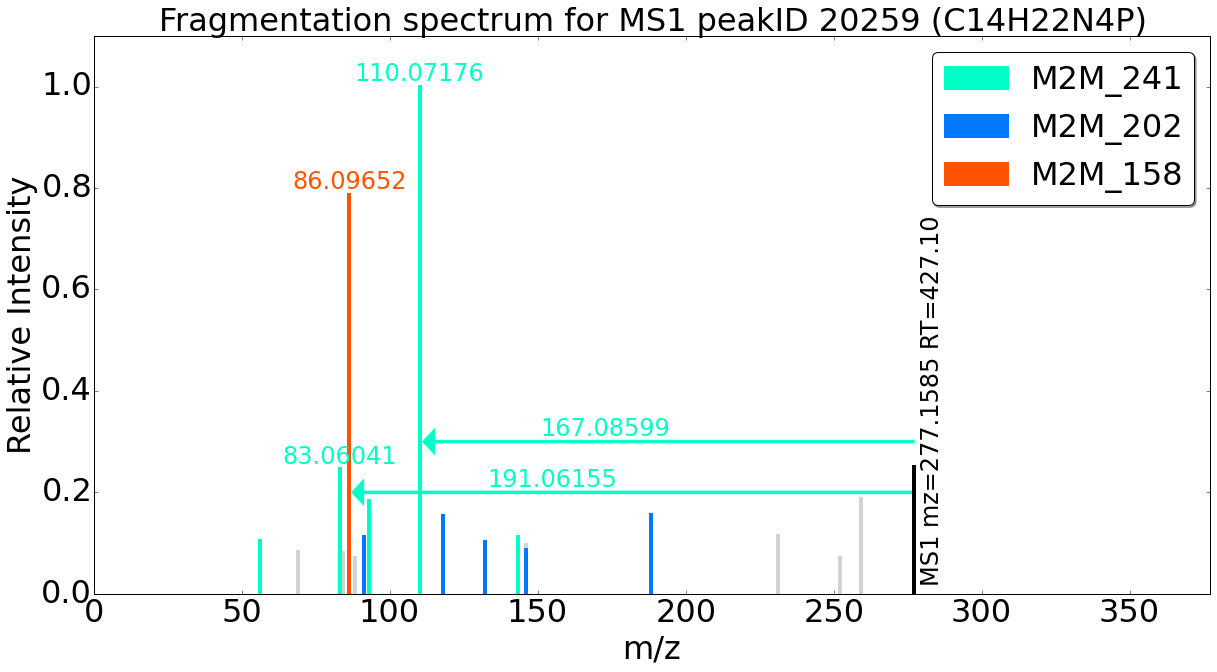

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0   110.071663       1.000000  fragment_110.07176             241   
1    86.096443       0.786891   fragment_86.09652             158   
2    83.060303       0.245350   fragment_83.06041             241   
3   259.136200       0.187194  fragment_259.13595             NaN   
4    93.044960       0.182310   fragment_93.04509             241   
5   188.070389       0.155427  fragment_188.07061             202   
6   118.065384       0.153206  fragment_118.06544             202   
7   231.143066       0.114169   fragment_231.1431             NaN   
8    91.053848       0.111245   fragment_91.05413             202   
9   143.117538       0.111168  fragment_143.11757             241   
10   56.049675       0.104228   fragment_56.04977             241   
11  132.081299       0.101629  fragment_132.08143             202   
12  146.080994       0.095839  fragment_146.08111             NaN   
13  277.151489       0.091094  fragment_277.15149             NaN   
14  146.059235       0.086843  fragment_146.05935             202   
15   69.070045       0.082191   fragment_69.07013             NaN   
16   84.044815       0.081280   fragment_84.04486             NaN   
17  252.108170       0.070896  fragment_252.10822             NaN   
18   88.039764       0.069873   fragment_88.03919             NaN   

         loss_word  loss_motif                     ef  
0   loss_167.08599         241    C5H8N3,loss_C9H14NP  
1   loss_191.06155         241  C5H12N,loss_C7H13O3NS  
2   loss_194.09798         NaN   C4H7N2,loss_C8H18O3S  
3              NaN         NaN              C15H20N2P  
4              NaN         NaN                 C5H5N2  
5              NaN         NaN              C11H10O2N  
6              NaN         NaN                  C8H8N  
7              NaN         NaN               C12H25P2  
8              NaN         NaN                   C7H7  
9              NaN         NaN               C7H15ON2  
10             NaN         NaN                  C3H6N  
11             NaN         NaN                 C9H10N  
12             NaN         NaN               C6H12O3N  
13             NaN         NaN             C10H21O5N4  
14             NaN         NaN                C3H9N5P  
15             NaN         NaN                   C5H9  
16             NaN         NaN                    NaN  
17             NaN         NaN               C9H18O7N  
18  loss_189.12028         NaN  C3H6O2N,loss_C9H19ONS

 - No M2M for this MS1 peak at the specified thresholding levels



None

 - M2M_82	: Possibly suggests agmatine based substructure (C5H15N4), with unknown conjugation
		  fragment_98.06001 (0.073),fragment_131.12915 (0.069),fragment_114.10279 (0.059),fragment_278.05564 (0.052),fragment_157.10838 (0.051),fragment_60.05587 (0.049),fragment_55.05466 (0.043),fragment_97.07643 (0.036),fragment_165.07004 (0.035),fragment_425.2164 (0.028),fragment_321.07496 (0.026),fragment_207.07981 (0.019),fragment_235.07587 (0.017),fragment_295.09907 (0.016),fragment_273.10905 (0.016),fragment_293.08022 (0.015),fragment_178.07822 (0.015),fragment_189.07017 (0.013),fragment_205.06529 (0.012),fragment_291.10614 (0.012),fragment_194.07199 (0.012),
 - M2M_220	: Adenine substructure
		  fragment_136.06239 (0.688),loss_162.03528 (0.049),fragment_119.03518 (0.039),loss_153.04184 (0.027),fragment_137.04626 (0.020),

(30475, nan)


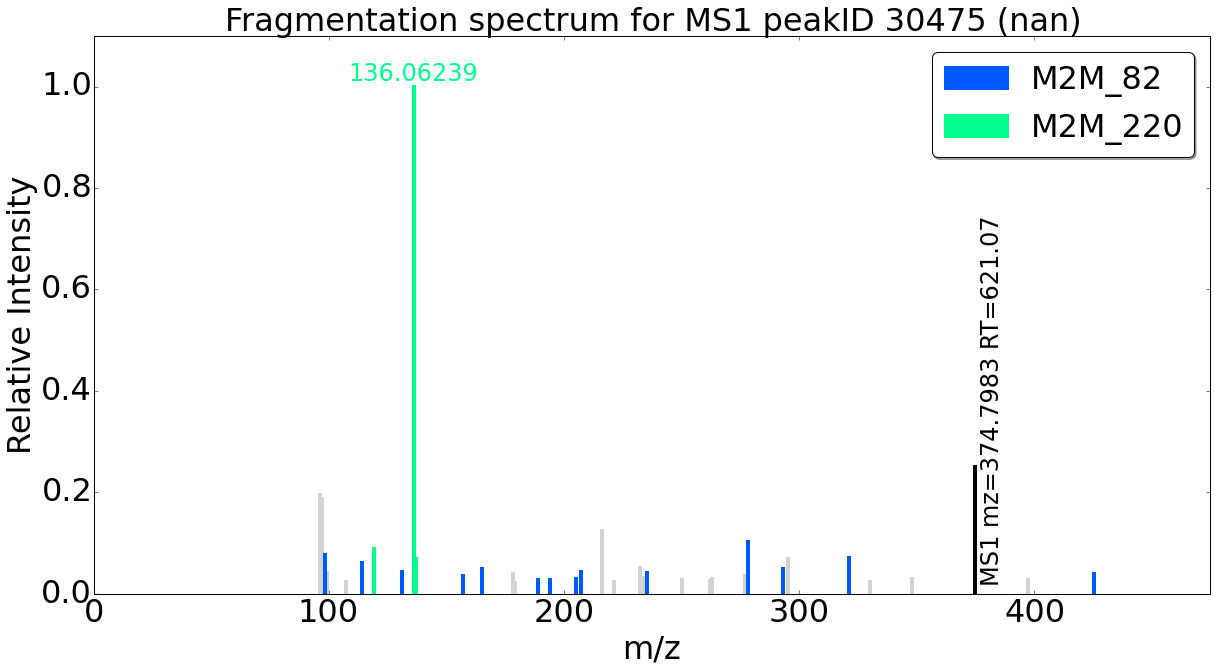

ms2_mz  ms2_intensity       fragment_word  fragment_motif  loss_word  \
0   136.062561       1.000000  fragment_136.06239             220        NaN   
1    96.044250       0.195402   fragment_96.04413             NaN        NaN   
2    97.028450       0.187013   fragment_97.02839             NaN        NaN   
3   216.028778       0.123553   fragment_216.0282             NaN        NaN   
4   278.055267       0.101901  fragment_278.05564              82        NaN   
5   564.292358       0.087922  fragment_564.29015             NaN        NaN   
6   119.035324       0.087803  fragment_119.03518             220        NaN   
7    98.060028       0.076200   fragment_98.06001              82        NaN   
8   321.075562       0.071250  fragment_321.07496              82        NaN   
9   295.094482       0.069065  fragment_295.09452             NaN        NaN   
10  137.046295       0.067944  fragment_137.04626             220        NaN   
11  114.102997       0.060361  fragment_114.10279              82        NaN   
12  232.082458       0.050560  fragment_232.08279             NaN        NaN   
13  293.080627       0.049669  fragment_293.08022              82        NaN   
14  165.070404       0.048935  fragment_165.07004              82        NaN   
15  207.080109       0.043863  fragment_207.07981              82        NaN   
16  131.129333       0.043053  fragment_131.12915              82        NaN   
17   98.983765       0.041568   fragment_98.98385             NaN        NaN   
18  235.075897       0.041542  fragment_235.07587              82        NaN   
19  425.216309       0.039664   fragment_425.2164              82        NaN   
20  178.075897       0.038635   fragment_178.0764             NaN        NaN   
21  157.108459       0.035018  fragment_157.10838              82        NaN   
22  277.086121       0.034517  fragment_277.08605             NaN        NaN   
23   97.075554       0.033998   fragment_97.07555             NaN        NaN   
24  234.067200       0.030667  fragment_234.06738             NaN        NaN   
25  348.073029       0.030001  fragment_348.07307             NaN        NaN   
26  263.069061       0.029991  fragment_263.06912             NaN        NaN   
27  205.065155       0.029018  fragment_205.06529              82        NaN   
28  189.070236       0.028152  fragment_189.07017              82        NaN   
29  250.063080       0.027816  fragment_250.06296             NaN        NaN   
30  397.169281       0.027232  fragment_397.16953             NaN        NaN   
31  194.071976       0.026394  fragment_194.07199              82        NaN   
32  262.060211       0.025396  fragment_262.06083             NaN        NaN   
33  330.060699       0.023753  fragment_330.06072             NaN        NaN   
34  221.059586       0.023253  fragment_221.05945             NaN        NaN   
35  107.048843       0.022656  fragment_107.04883             NaN        NaN   
36  565.295410       0.021585  fragment_565.29541             NaN        NaN   
37  179.085419       0.020715   fragment_179.0854             NaN        NaN   

    loss_motif           ef  
0          NaN       C5H6N5  
1          NaN       C5H6ON  
2          NaN       C5H5O2  
3          NaN  C5H15O2NPS2  
4          NaN  C9H17ON3PS2  
5          NaN          NaN  
6          NaN       C5H3N4  
7          NaN       C5H8ON  
8          NaN          NaN  
9          NaN          NaN  
10         NaN      C5H5ON4  
11         NaN      C5H12N3  
12         NaN   C10H18ONS2  
13         NaN          NaN  
14         NaN   C5H13O2N2S  
15         NaN     C9H12N4P  
16         NaN      C5H15N4  
17         NaN        H4O4P  
18         NaN   C8H15O4N2S  
19         NaN          NaN  
20         NaN    C4H12ON5S  
21         NaN     C6H13ON4  
22         NaN  C12H14O2N4P  
23         NaN       C5H9N2  
24         NaN   C6H14ON5P2  
25         NaN          NaN  
26         NaN    C10H16O6P  
27         NaN       C15H9O  
28         NaN   

 - M2M_2	: Small nitrogen containing fragment ion - often proline or ornithine derived
		  fragment_70.06514 (0.979),
 - M2M_174	: Pyroglutamic acid (pyroglutamate) substructure
		  fragment_84.0442 (0.854),fragment_56.04977 (0.102),

(25142, nan)


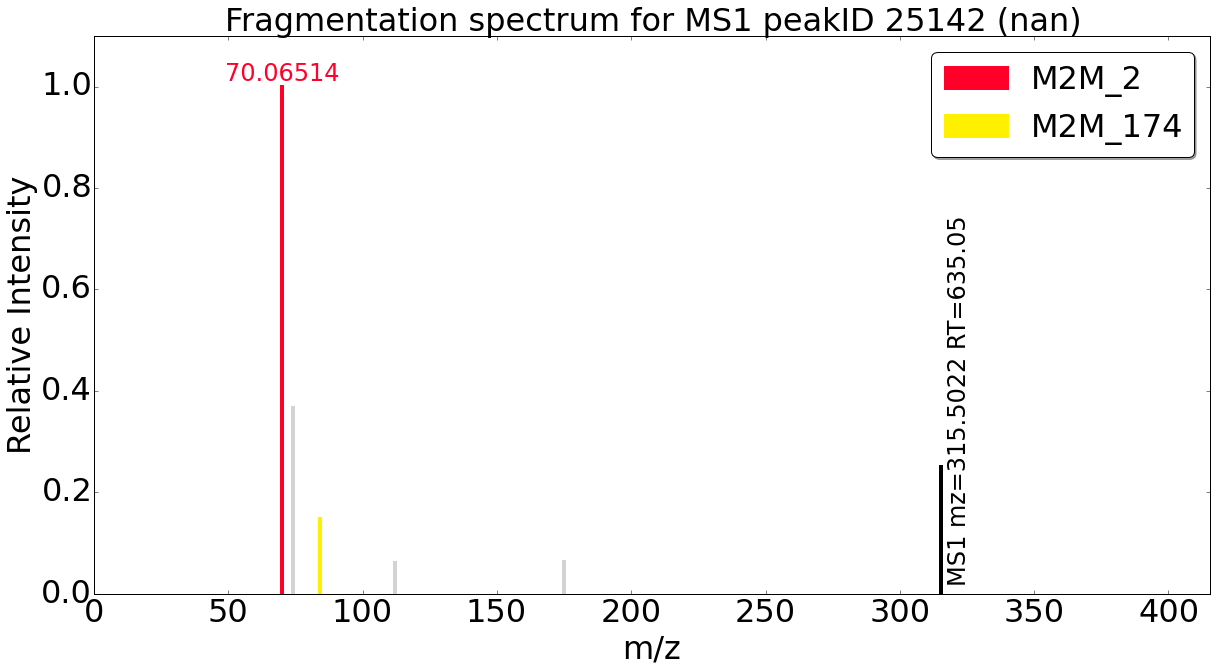

ms2_mz  ms2_intensity       fragment_word  fragment_motif  loss_word  \
0   70.065216       1.000000   fragment_70.06514               2        NaN   
1   74.059898       0.365953   fragment_74.05984             NaN        NaN   
2   84.044167       0.147056    fragment_84.0442             174        NaN   
3  175.120041       0.062342  fragment_175.12007             NaN        NaN   
4  112.087120       0.060875  fragment_112.08704             NaN        NaN   
5   84.080727       0.059054   fragment_84.08071             NaN        NaN   

   loss_motif       ef  
0         NaN    C4H8N  
1         NaN   C3H8ON  
2         NaN   C4H6ON  
3         NaN      NaN  
4         NaN  C5H10N3  
5         NaN   C5H10N

 - M2M_82	: Possibly suggests agmatine based substructure (C5H15N4), with unknown conjugation
		  fragment_98.06001 (0.073),fragment_131.12915 (0.069),fragment_114.10279 (0.059),fragment_278.05564 (0.052),fragment_157.10838 (0.051),fragment_60.05587 (0.049),fragment_55.05466 (0.043),fragment_97.07643 (0.036),fragment_165.07004 (0.035),fragment_425.2164 (0.028),fragment_321.07496 (0.026),fragment_207.07981 (0.019),fragment_235.07587 (0.017),fragment_295.09907 (0.016),fragment_273.10905 (0.016),fragment_293.08022 (0.015),fragment_178.07822 (0.015),fragment_189.07017 (0.013),fragment_205.06529 (0.012),fragment_291.10614 (0.012),fragment_194.07199 (0.012),
 - M2M_55	: Cinnamic acid (cinnamate) substructure
		  fragment_147.04375 (0.281),fragment_119.04874 (0.241),fragment_91.05413 (0.123),loss_130.12154 (0.051),fragment_65.03878 (0.045),loss_186.11136 (0.027),loss_158.11694 (0.026),fragment_114.10279 (0.014),fragment_439.21695 (0.012),loss_163.06342 (0.011),fragment_277.16473 (0.011),

(21

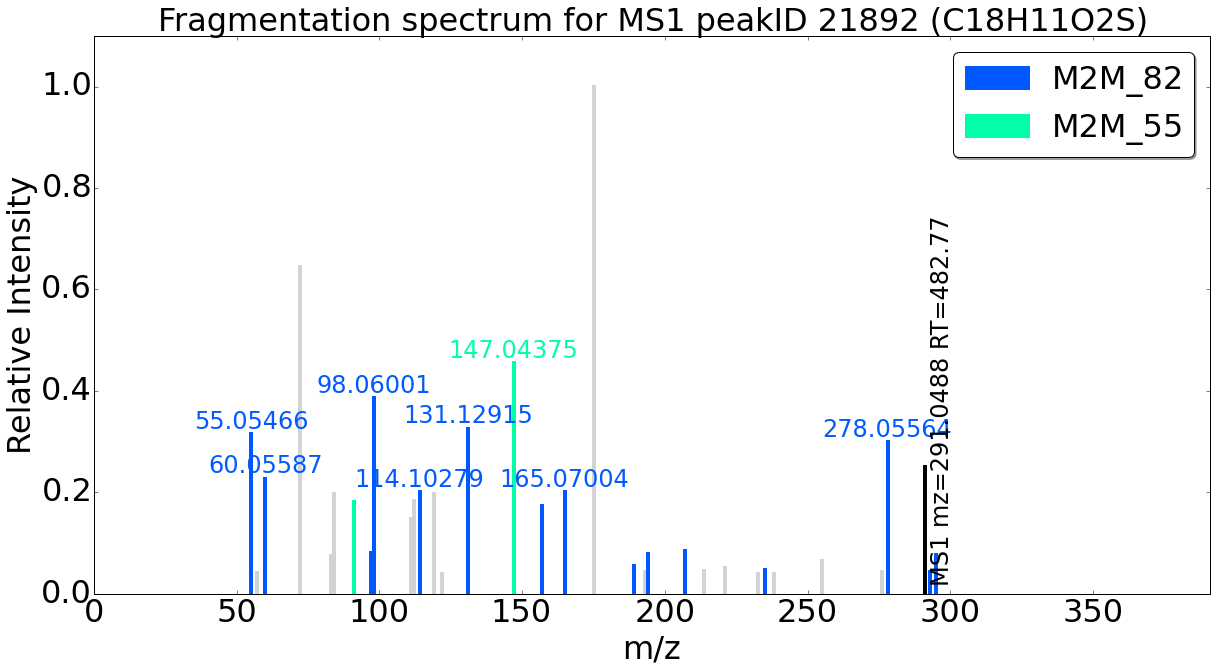

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0   175.001419       1.000000  fragment_175.00156             NaN   
1    72.080742       0.643429    fragment_72.0807             NaN   
2   147.043823       0.454290  fragment_147.04375              55   
3    98.060074       0.385775   fragment_98.06001              82   
4   131.129318       0.325853  fragment_131.12915              82   
5    55.054813       0.315198   fragment_55.05466              82   
6   278.055786       0.299441  fragment_278.05564              82   
7    60.055824       0.227290   fragment_60.05587              82   
8   114.102852       0.200398  fragment_114.10279              82   
9   165.069977       0.200042  fragment_165.07004              82   
10  119.050003       0.197226  fragment_119.04991             NaN   
11   84.080750       0.196715   fragment_84.08071             NaN   
12  112.047768       0.183152  fragment_112.04777             NaN   
13   91.054176       0.180882   fragment_91.05413              55   
14  157.108521       0.172828  fragment_157.10838              82   
15  111.044350       0.147952  fragment_111.04428             NaN   
16  207.079788       0.084948  fragment_207.07981              82   
17   97.076500       0.079917   fragment_97.07643              82   
18  194.072067       0.077912  fragment_194.07199              82   
19  291.049377       0.077738  fragment_291.04938             NaN   
20  295.099091       0.076901  fragment_295.09907              82   
21   83.049683       0.075169   fragment_83.04963             NaN   
22  207.113708       0.068796  fragment_207.11358             NaN   
23   84.052963       0.067980   fragment_84.05296             NaN   
24  255.131012       0.064131  fragment_255.13101             NaN   
25  189.070312       0.054517  fragment_189.07017              82   
26  221.059677       0.049948  fragment_221.05945             NaN   
27  235.075928       0.046500  fragment_235.07587              82   
28  213.680557       0.044305  fragment_213.68056             NaN   
29  291.082367       0.043981  fragment_291.08245             NaN   
30  293.080353       0.043280  fragment_293.08022              82   
31  276.165466       0.042432  fragment_276.16547             NaN   
32  193.027481       0.042076  fragment_193.02748             NaN   
33   56.965084       0.040473    fragment_56.9651             NaN   
34  122.016869       0.039957  fragment_122.01687             NaN   
35  232.532837       0.039274  fragment_232.53284             NaN   
36  238.322601       0.038646   fragment_238.3226             NaN   

         loss_word  loss_motif                     ef  
0   loss_116.04688         NaN  C3H4O3N4P,loss_C5H8O3  
1              NaN         NaN                 C4H10N  
2              NaN         NaN               C3H8ON4P  
3              NaN         NaN                 C5H8ON  
4              NaN         NaN                C5H15N4  
5              NaN         NaN                   C4H7  
6              NaN         NaN            C9H17ON3PS2  
7              NaN         NaN                  CH6N3  
8              NaN         NaN                C5H12N3  
9              NaN         NaN             C5H13O2N2S  
10             NaN         NaN                    NaN  
11             NaN         NaN                 C5H10N  
12             NaN         NaN                    NaN  
13             NaN         NaN                   C7H7  
14             NaN         NaN               C6H13ON4  
15             NaN         NaN                 C6H7O2  
16             NaN         NaN               C9H12N4P  
17             NaN         NaN                 C5H9N2  
18             NaN         NaN                C12H8N3  
19             NaN         NaN                    NaN  
20             NaN         NaN                    NaN  
21             NaN         NaN                    NaN  
22             NaN         NaN             C11H15O2N2  
23             NaN         NaN           

 - M2M_82	: Possibly suggests agmatine based substructure (C5H15N4), with unknown conjugation
		  fragment_98.06001 (0.073),fragment_131.12915 (0.069),fragment_114.10279 (0.059),fragment_278.05564 (0.052),fragment_157.10838 (0.051),fragment_60.05587 (0.049),fragment_55.05466 (0.043),fragment_97.07643 (0.036),fragment_165.07004 (0.035),fragment_425.2164 (0.028),fragment_321.07496 (0.026),fragment_207.07981 (0.019),fragment_235.07587 (0.017),fragment_295.09907 (0.016),fragment_273.10905 (0.016),fragment_293.08022 (0.015),fragment_178.07822 (0.015),fragment_189.07017 (0.013),fragment_205.06529 (0.012),fragment_291.10614 (0.012),fragment_194.07199 (0.012),
 - M2M_220	: Adenine substructure
		  fragment_136.06239 (0.688),loss_162.03528 (0.049),fragment_119.03518 (0.039),loss_153.04184 (0.027),fragment_137.04626 (0.020),

(33982, nan)


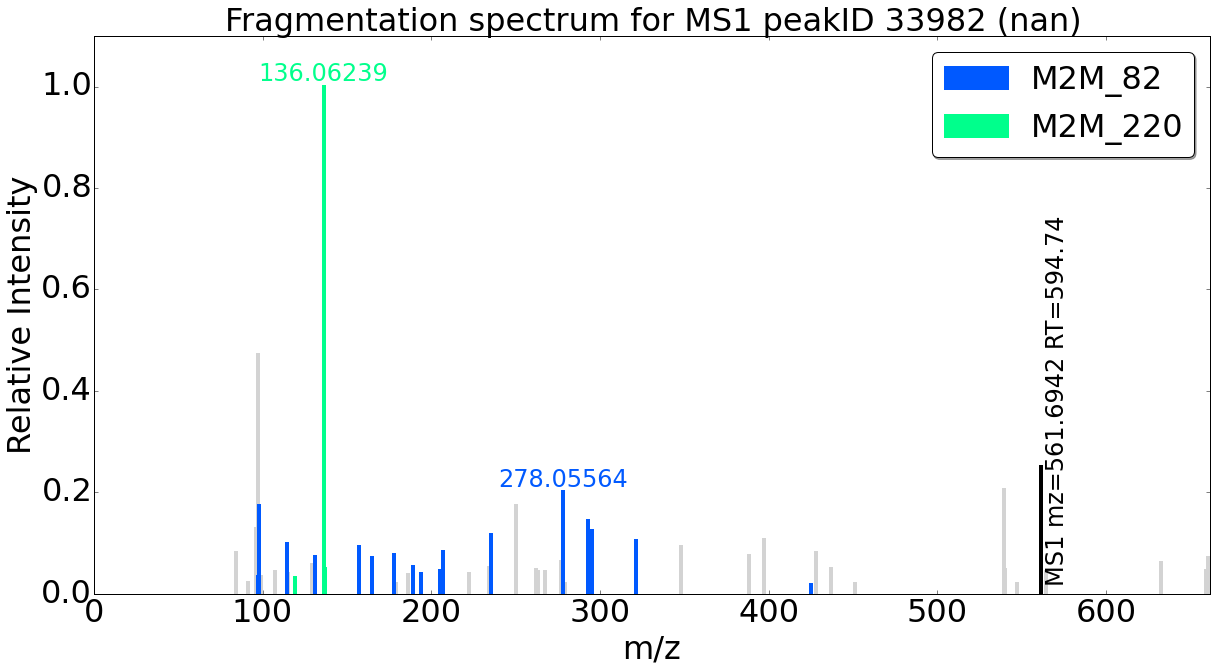

ms2_mz  ms2_intensity       fragment_word  fragment_motif  loss_word  \
0   136.062439       1.000000  fragment_136.06239             220        NaN   
1    97.028397       0.471582   fragment_97.02839             NaN        NaN   
2   539.293274       0.205488  fragment_539.29327             NaN        NaN   
3   278.055115       0.200765  fragment_278.05564              82        NaN   
4   250.092850       0.173679  fragment_250.09297             NaN        NaN   
5    98.060158       0.172222   fragment_98.06001              82        NaN   
6   293.080994       0.144311  fragment_293.08022              82        NaN   
7    96.044113       0.127130   fragment_96.04413             NaN        NaN   
8   295.098846       0.124185  fragment_295.09907              82        NaN   
9   235.076218       0.116022  fragment_235.07587              82        NaN   
10  397.170135       0.105997  fragment_397.16953             NaN        NaN   
11  321.074707       0.104415  fragment_321.07496              82        NaN   
12  114.102859       0.099012  fragment_114.10279              82        NaN   
13  157.108429       0.092544  fragment_157.10838              82        NaN   
14  348.073181       0.091543  fragment_348.07307             NaN        NaN   
15  207.080063       0.081478  fragment_207.07981              82        NaN   
16   84.080574       0.081316   fragment_84.08071             NaN        NaN   
17  428.034119       0.079764  fragment_428.03409             NaN        NaN   
18  178.078369       0.076040  fragment_178.07822              82        NaN   
19  388.159607       0.073656  fragment_388.15961             NaN        NaN   
20  131.129211       0.072833  fragment_131.12915              82        NaN   
21  660.322510       0.071335  fragment_660.32251             NaN        NaN   
22  165.070312       0.071127  fragment_165.07004              82        NaN   
23  277.086029       0.062057  fragment_277.08605             NaN        NaN   
24  632.319946       0.060664  fragment_632.31995             NaN        NaN   
25  129.101959       0.057692  fragment_129.10193             NaN        NaN   
26  189.070190       0.052431  fragment_189.07017              82        NaN   
27  234.067139       0.050826  fragment_234.06738             NaN        NaN   
28  437.146423       0.048195  fragment_437.14642             NaN        NaN   
29  137.046173       0.048058  fragment_137.04626             220        NaN   
30  262.060150       0.046124  fragment_262.06083             NaN        NaN   
31  540.302917       0.046074  fragment_540.30292             NaN        NaN   
32  205.065109       0.045876  fragment_205.06529              82        NaN   
33  659.320740       0.045840  fragment_659.32074             NaN        NaN   
34  564.289551       0.043883  fragment_564.29015             NaN        NaN   
35  267.101044       0.043543  fragment_267.10105             NaN        NaN   
36  107.048813       0.043124  fragment_107.04883             NaN        NaN   
37  263.069000       0.042425  fragment_263.06912             NaN        NaN   
38  137.065948       0.039085  fragment_137.06614             NaN        NaN   
39  115.087112       0.039010  fragment_115.08708             NaN        NaN   
40  194.071930       0.038820  fragment_194.07199              82        NaN   
41  222.066757       0.038331  fragment_222.06679             NaN        NaN   
42  186.029984       0.037433  fragment_186.02997             NaN        NaN   
43  206.074295       0.036461   fragment_206.0743             NaN        NaN   
44   97.076439       0.033574   fragment_97.07643              82        NaN   
45   98.983803       0.032692   fragment_98.98385             NaN        NaN   
46  119.035141       0.031321  fragment_119.03518             220        NaN   
47   91.054115       0.020824   fragment_91.05413             NaN        NaN   
48  179.085373       0.020219   fragment_179.0854             NaN        NaN   
49  279.

 - No M2M for this MS1 peak at the specified thresholding levels



None

 - M2M_156	: [Pentose-H2O] loss, e.g. ribose
		  loss_132.04207 (0.683),loss_160.03691 (0.038),loss_149.06869 (0.037),fragment_102.06629 (0.030),loss_131.05794 (0.018),fragment_74.07118 (0.011),

(14347, 'C10H21ONPS')


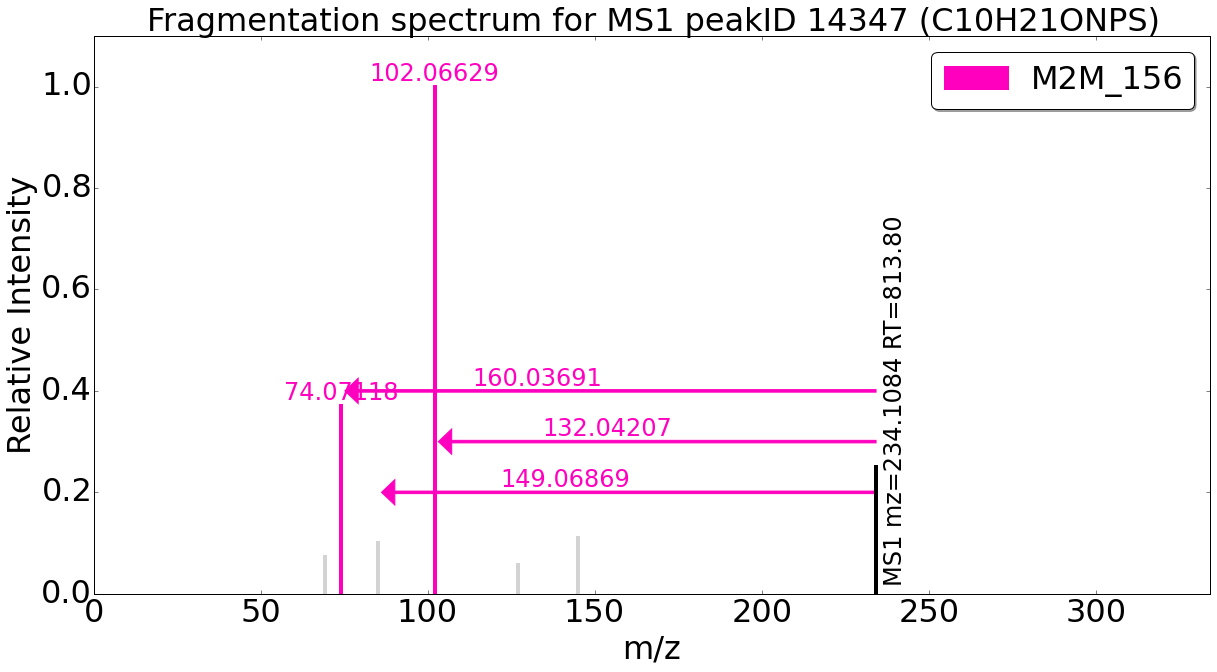

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0  102.066292       1.000000  fragment_102.06629             156   
1   74.071167       0.370886   fragment_74.07118             156   
2  144.993347       0.110808  fragment_144.99346             NaN   
3   85.039452       0.099537   fragment_85.03954             NaN   
4  234.077301       0.073466  fragment_234.07753             NaN   
5   69.033615       0.071596   fragment_69.03368             NaN   
6  234.107880       0.064208  fragment_234.10788             NaN   
7  127.049500       0.057492  fragment_127.04953             NaN   

        loss_word  loss_motif                     ef  
0  loss_132.04207         156    C3H8ON3,loss_C5H8O4  
1  loss_160.03691         156     C2H8N3,loss_C6H8O5  
2             NaN         NaN                    NaN  
3  loss_149.06869         156  C3H5ON2,loss_C5H11O4N  
4             NaN         NaN                C13H8N5  
5  loss_165.07584         NaN   C4H5O,loss_C4H11O4N3  
6             NaN         NaN             C10H21ONPS  
7  loss_107.05827         NaN           loss_C3H9O3N

 - No M2M for this MS1 peak at the specified thresholding levels



None

 - No M2M for this MS1 peak at the specified thresholding levels



None

 - M2M_129	: fragments from [hexose-H2O] substructure (a hexose conjugation, e.g. glucose)
		  fragment_145.04997 (0.260),fragment_127.03868 (0.188),fragment_85.02832 (0.152),fragment_163.06064 (0.079),fragment_97.02839 (0.055),fragment_81.03334 (0.041),fragment_69.03368 (0.037),fragment_103.03863 (0.036),fragment_109.02882 (0.032),fragment_99.04454 (0.021),fragment_99.04377 (0.017),fragment_53.03888 (0.013),fragment_325.11195 (0.011),
 - M2M_131	: fragments from [hexose-H2O] substructure (a hexose conjugation, e.g. glucose)
		  fragment_85.02832 (0.566),fragment_69.03368 (0.105),fragment_97.02839 (0.088),fragment_61.02854 (0.070),fragment_57.0337 (0.045),fragment_91.03925 (0.022),fragment_127.03868 (0.021),fragment_73.0285 (0.019),fragment_55.01824 (0.019),

(25635, 'C16H23O3P2')


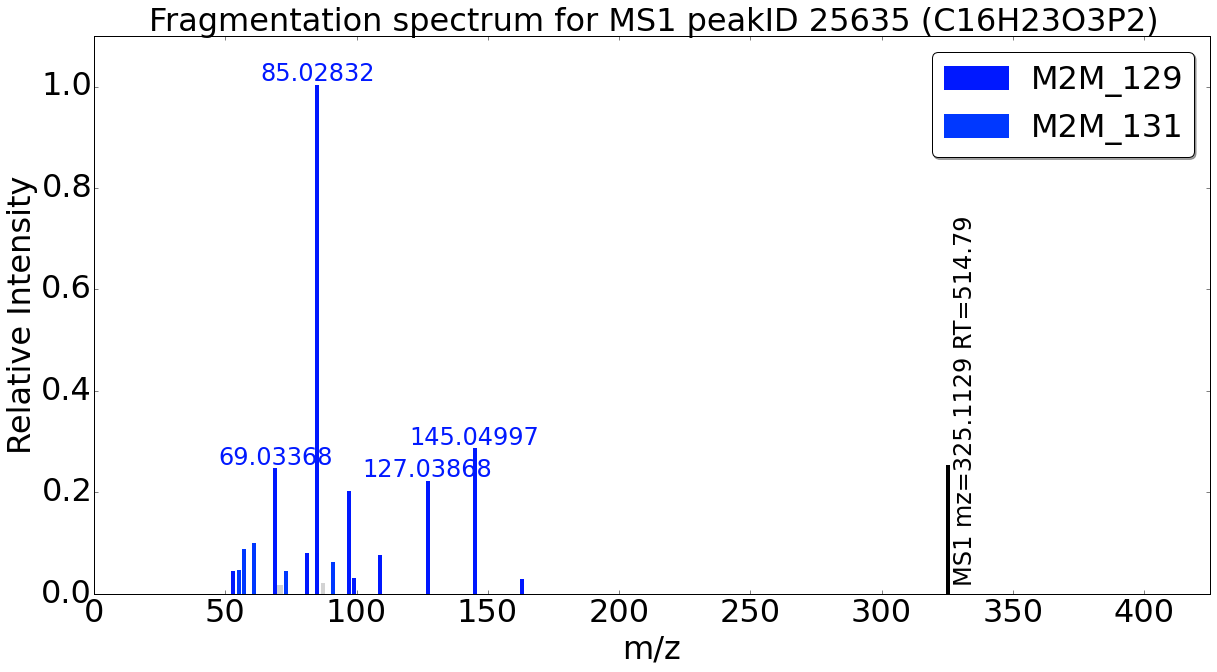

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0    85.028297       1.000000   fragment_85.02832             129   
1   145.049911       0.282837  fragment_145.04997             129   
2    69.033699       0.244426   fragment_69.03368             129   
3   127.038605       0.219297  fragment_127.03868             129   
4    97.028358       0.199447   fragment_97.02839             129   
5    61.028522       0.095313   fragment_61.02854             131   
6    57.033688       0.083772    fragment_57.0337             131   
7    81.033325       0.076132   fragment_81.03334             129   
8   109.028824       0.073513  fragment_109.02882             129   
9    91.039215       0.058931   fragment_91.03925             131   
10   55.018311       0.043952   fragment_55.01824             131   
11   53.038929       0.040810   fragment_53.03888             129   
12   73.028564       0.040155    fragment_73.0285             131   
13   99.044479       0.026844   fragment_99.04454             129   
14  163.060974       0.024552  fragment_163.06064             129   
15   53.002556       0.020411   fragment_53.00259             NaN   
16   87.043861       0.016563   fragment_87.04391             NaN   
17   70.065086       0.013881   fragment_70.06514             NaN   
18   71.049362       0.012959   fragment_71.04937             NaN   

         loss_word  loss_motif                    ef  
0              NaN         NaN                C4H5O2  
1   loss_180.06318         NaN   C6H9O4,loss_C6H12O6  
2              NaN         NaN                 C4H5O  
3   loss_198.07403         NaN   C6H7O3,loss_C6H14O7  
4              NaN         NaN                C5H5O2  
5              NaN         NaN                C2H5O2  
6              NaN         NaN                 C3H5O  
7              NaN         NaN                 C5H5O  
8              NaN         NaN                C6H5O2  
9              NaN         NaN                C3H7O3  
10             NaN         NaN                 C3H3O  
11             NaN         NaN                  C4H5  
12             NaN         NaN                C3H5O2  
13             NaN         NaN                C5H7O2  
14  loss_162.05262         NaN  C6H11O5,loss_C6H10O5  
15             NaN         NaN                  C3HO  
16             NaN         NaN                C4H7O2  
17             NaN         NaN                 C4H8N  
18             NaN         NaN                 C4H7O

 - No M2M for this MS1 peak at the specified thresholding levels



None

 - M2M_220	: Adenine substructure
		  fragment_136.06239 (0.688),loss_162.03528 (0.049),fragment_119.03518 (0.039),loss_153.04184 (0.027),fragment_137.04626 (0.020),

(16422, 'C9H21N4S2')


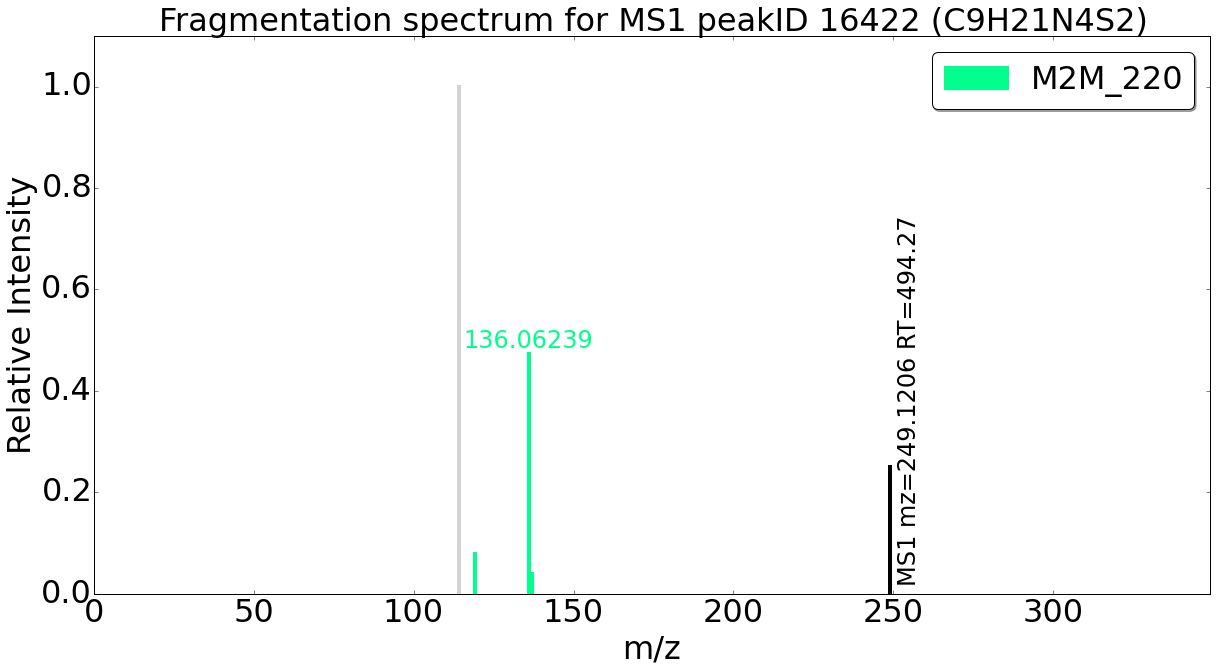

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0  114.065804       1.000000  fragment_114.06581             NaN   
1  136.062347       0.473192  fragment_136.06239             220   
2  119.035286       0.078324  fragment_119.03518             220   
3  249.124268       0.042257  fragment_249.12416             NaN   
4  137.046173       0.038800  fragment_137.04626             220   

        loss_word  loss_motif                    ef  
0  loss_135.05329         NaN  C4H8ON3,loss_C4H9O4N  
1   loss_113.0584         NaN   C5H6N5,loss_C4H7ON3  
2             NaN         NaN                C5H3N4  
3             NaN         NaN            C13H17O3N2  
4  loss_112.07382         NaN   C5H5ON4,loss_C4H8N4

 - M2M_230	: N/O-acetylation loss
		  fragment_87.04391 (0.782),fragment_187.88232 (0.031),fragment_210.89943 (0.017),

(34177, 'C30H56O9NS')


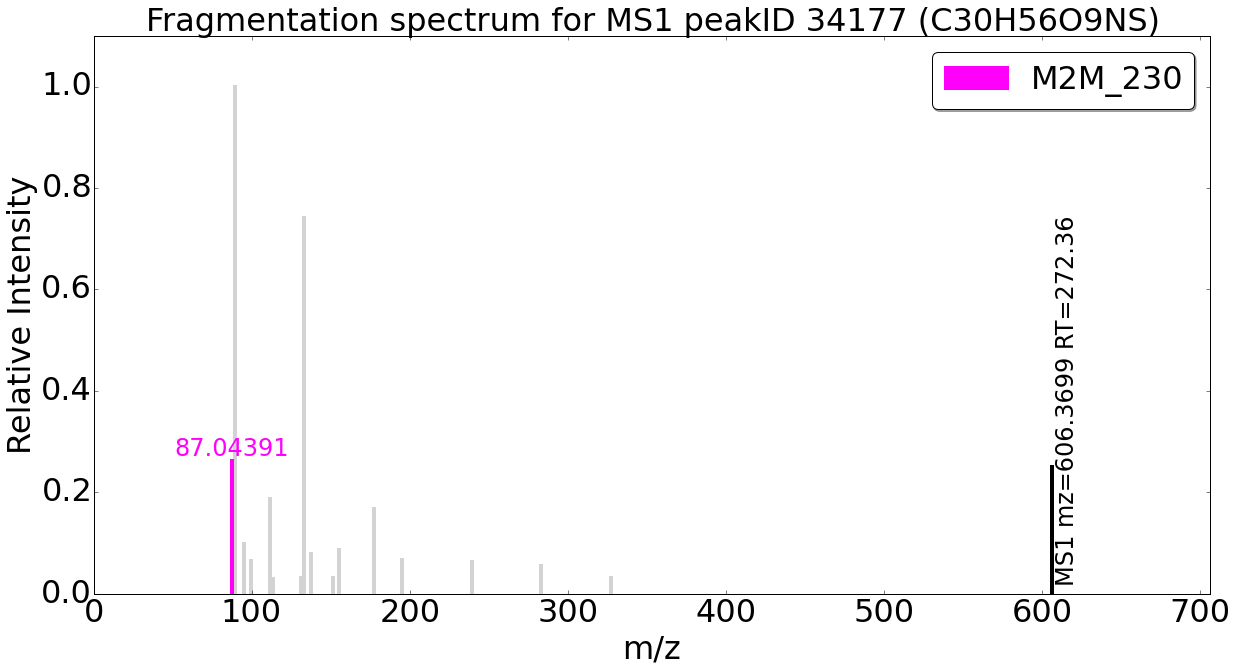

ms2_mz  ms2_intensity       fragment_word  fragment_motif  loss_word  \
0    89.060043       1.000000   fragment_89.06006             NaN        NaN   
1   133.086166       0.741002  fragment_133.08631             NaN        NaN   
2    87.043861       0.260888   fragment_87.04391             230        NaN   
3   111.044342       0.187153  fragment_111.04428             NaN        NaN   
4   177.112381       0.168079  fragment_177.11278             NaN        NaN   
5    95.049339       0.098704   fragment_95.04936             NaN        NaN   
6   155.070053       0.087326  fragment_155.07011             NaN        NaN   
7   137.059860       0.078945  fragment_137.05989             NaN        NaN   
8   195.122406       0.067389  fragment_195.12247             NaN        NaN   
9    99.044540       0.065431   fragment_99.04454             NaN        NaN   
10  239.148117       0.062282  fragment_239.14817             NaN        NaN   
11  283.173523       0.054871  fragment_283.17366             NaN        NaN   
12  131.070740       0.031844  fragment_131.07078             NaN        NaN   
13  151.096664       0.031079  fragment_151.09674             NaN        NaN   
14  327.201447       0.030349  fragment_327.20145             NaN        NaN   
15  113.060204       0.029578   fragment_113.0602             NaN        NaN   

    loss_motif        ef  
0          NaN    C4H9O2  
1          NaN   C6H13O3  
2          NaN    C4H7O2  
3          NaN    C6H7O2  
4          NaN   C8H17O4  
5          NaN     C6H7O  
6          NaN   C8H11O3  
7          NaN    C8H9O2  
8          NaN   C8H19O5  
9          NaN    C5H7O2  
10         NaN  C10H23O6  
11         NaN       NaN  
12         NaN   C6H11O3  
13         NaN   C6H15O4  
14         NaN       NaN  
15         NaN    C6H9O2

 - No M2M for this MS1 peak at the specified thresholding levels



None

 - M2M_241	: Histidine substructure
		  fragment_110.07176 (0.384),fragment_83.06041 (0.112),fragment_93.04509 (0.070),fragment_156.07684 (0.049),loss_167.08599 (0.045),loss_191.06155 (0.035),fragment_363.17581 (0.023),fragment_56.04977 (0.023),loss_27.01101 (0.023),fragment_143.11757 (0.017),fragment_81.04501 (0.017),fragment_95.06076 (0.012),
 - M2M_158	: Leucine substructure
		  fragment_86.09652 (0.794),fragment_132.10154 (0.048),fragment_219.90121 (0.031),fragment_293.3515 (0.031),fragment_189.12428 (0.012),

(33939, 'C25H50O7N2PS')


ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0   110.071709       1.000000  fragment_110.07176             241   
1    83.060333       0.292829   fragment_83.06041             241   
2    93.045029       0.193014   fragment_93.04509             241   
3    86.096527       0.182510   fragment_86.09652             158   
4   290.161011       0.125370    fragment_290.161             NaN   
5   308.172150       0.118050  fragment_308.17215             NaN   
6   383.201019       0.109546  fragment_383.20166             NaN   
7    70.065048       0.104650   fragment_70.06514             NaN   
8   252.108322       0.080984  fragment_252.10822             NaN   
9    56.049774       0.073962   fragment_56.04977             241   
10   95.060623       0.063870   fragment_95.06076             241   
11   81.044922       0.056883   fragment_81.04501             241   
12   69.069977       0.048672   fragment_69.07013             NaN   
13   82.052925       0.040115   fragment_82.05298             NaN   
14  423.202240       0.034500  fragment_423.20224             NaN   
15  246.145142       0.030416   fragment_246.1452             NaN   
16  253.094421       0.028984  fragment_253.09442             NaN   
17  265.083618       0.027217  fragment_265.08376             NaN   
18  422.213074       0.027080  fragment_422.21307             NaN   
19   91.054070       0.026865   fragment_91.05413             NaN   
20  115.054268       0.026436  fragment_115.05435             NaN   
21  270.119781       0.025654  fragment_270.11978             NaN   
22   84.044098       0.024484    fragment_84.0442             NaN   
23  291.063171       0.013662  fragment_291.06354             NaN   

         loss_word  loss_motif             ef  
0              NaN         NaN         C5H8N3  
1              NaN         NaN         C4H7N2  
2              NaN         NaN         C5H5N2  
3              NaN         NaN         C5H12N  
4              NaN         NaN            NaN  
5              NaN         NaN            NaN  
6              NaN         NaN            NaN  
7              NaN         NaN          C4H8N  
8              NaN         NaN       C9H18O7N  
9              NaN         NaN          C3H6N  
10             NaN         NaN         C5H7N2  
11             NaN         NaN         C4H5N2  
12             NaN         NaN           C5H9  
13             NaN         NaN            NaN  
14             NaN         NaN            NaN  
15             NaN         NaN      C12H25NPS  
16             NaN         NaN     C10H23OP2S  
17             NaN         NaN     C13H17N2S2  
18  loss_131.09455         NaN  loss_C6H13O2N  
19             NaN         NaN           C7H7  
20             NaN         NaN           C9H7  
21             NaN         NaN     C12H21N3PS  
22             NaN         NaN         C4H6ON  
23             NaN         NaN            NaN

 - M2M_211	: N-acetylputrescine substructure
		  loss_59.037 (0.567),fragment_114.09123 (0.097),loss_101.04757 (0.042),loss_59.00065 (0.030),fragment_131.11777 (0.029),fragment_425.1355 (0.029),fragment_72.04466 (0.023),fragment_60.04477 (0.014),

(3789, 'C5H11O3N2')


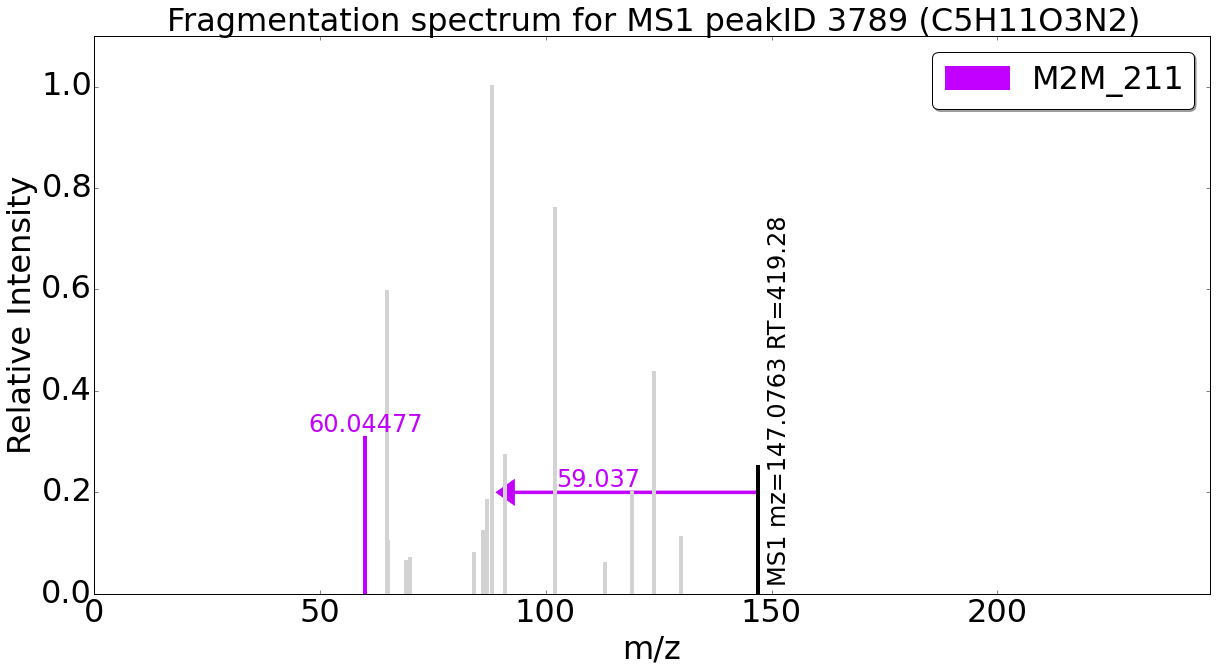

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0    88.039825       1.000000   fragment_88.03986             NaN   
1   102.054741       0.757965   fragment_102.0547             NaN   
2    64.927544       0.595009   fragment_64.92754             NaN   
3   123.965187       0.435354  fragment_123.96513             NaN   
4    60.044868       0.308090   fragment_60.04477             211   
5    91.054253       0.271888   fragment_91.05413             NaN   
6   119.050125       0.198679  fragment_119.04991             NaN   
7    87.063797       0.183130   fragment_87.06381             NaN   
8    87.055435       0.172665   fragment_87.05542             NaN   
9   147.043777       0.162096  fragment_147.04375             NaN   
10   86.060272       0.121038   fragment_86.06016             NaN   
11  130.050507       0.109994  fragment_130.05051             NaN   
12   65.038780       0.101933   fragment_65.03878             NaN   
13   84.044174       0.078270    fragment_84.0442             NaN   
14   70.028984       0.069349   fragment_70.02895             NaN   
15  147.064072       0.065134  fragment_147.06411             NaN   
16   69.033653       0.063535   fragment_69.03368             NaN   
17  113.023781       0.059687   fragment_113.0237             NaN   

        loss_word  loss_motif                   ef  
0     loss_59.037         211          loss_C2H5ON  
1   loss_45.02125         NaN   C4H8O2N,loss_CH3ON  
2             NaN         NaN                  NaN  
3             NaN         NaN                  NaN  
4   loss_87.03196         NaN  C2H6ON,loss_C3H5O2N  
5             NaN         NaN                 C7H7  
6             NaN         NaN                  NaN  
7             NaN         NaN                  NaN  
8   loss_60.02094         NaN  C3H7ON2,loss_C2H4O2  
9             NaN         NaN             C3H8ON4P  
10  loss_61.01619         NaN   C4H8ON,loss_CH3O2N  
11  loss_17.02527         NaN              C5H8O3N  
12            NaN         NaN                 C5H5  
13  loss_63.03191         NaN   C4H6ON,loss_CH5O2N  
14  loss_77.04757         NaN  C3H4ON,loss_C2H7O2N  
15            NaN         NaN                  NaN  
16  loss_78.04263         NaN                C4H5O  
17            NaN         NaN               C5H5O3

 - M2M_260	: Water loss - indicative of a free hydroxyl group
		  loss_18.00923 (0.942),fragment_176.09136 (0.015),
 - M2M_262	: Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure
		  loss_46.00539 (0.854),loss_74.0003 (0.058),loss_47.0087 (0.017),fragment_100.11239 (0.016),

(2254, 'C5H10O3N')


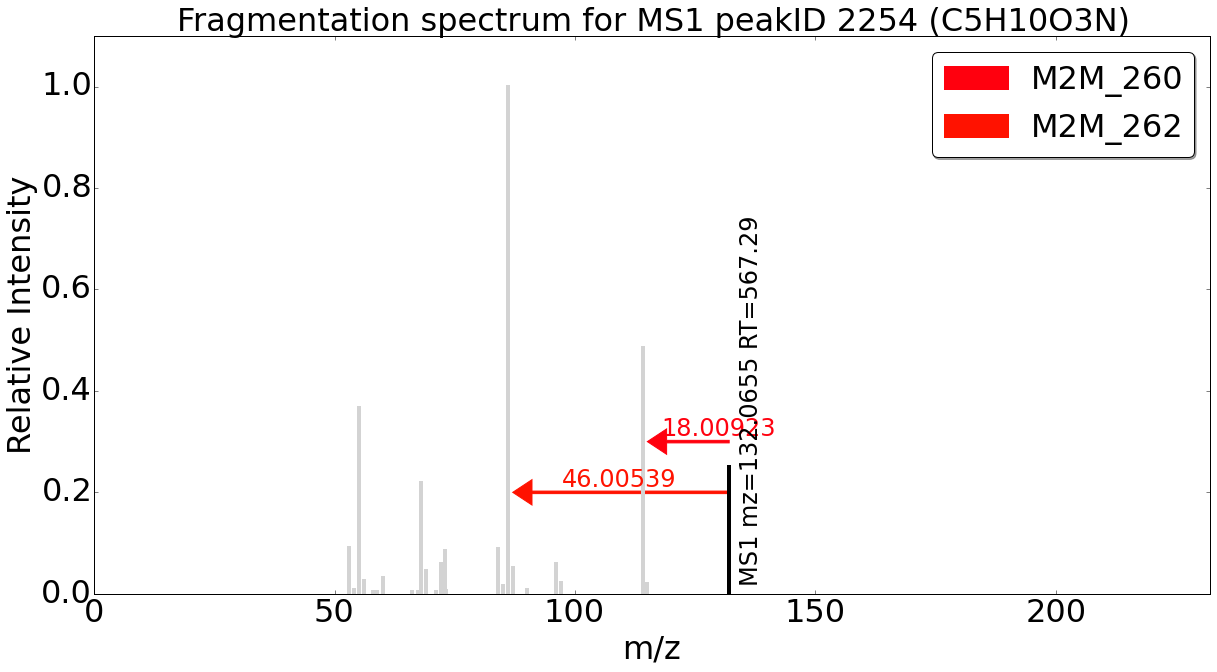

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0    86.060158       1.000000   fragment_86.06016             NaN   
1   114.055367       0.485371   fragment_114.0554             NaN   
2    55.018311       0.367145   fragment_55.01824             NaN   
3    68.049873       0.218850   fragment_68.04977             NaN   
4    53.038918       0.091089   fragment_53.03888             NaN   
5    84.080666       0.088259   fragment_84.08071             NaN   
6    73.028572       0.083616    fragment_73.0285             NaN   
7    72.044762       0.058873   fragment_72.04466             NaN   
8    96.044235       0.058463   fragment_96.04413             NaN   
9    87.044022       0.051343   fragment_87.04391             NaN   
10   69.033615       0.045783   fragment_69.03368             NaN   
11  132.065521       0.040975  fragment_132.06554             NaN   
12  132.112686       0.039251    fragment_132.113             NaN   
13   60.044785       0.031613   fragment_60.04477             NaN   
14   56.049778       0.025660   fragment_56.04977             NaN   
15   73.065140       0.024119   fragment_73.06514             NaN   
16   55.054615       0.022698   fragment_55.05466             NaN   
17   97.028389       0.021554   fragment_97.02839             NaN   
18  115.039131       0.020063  fragment_115.03913             NaN   
19  132.091476       0.017816  fragment_132.09148             NaN   
20   60.055794       0.016446   fragment_60.05587             NaN   
21   85.084114       0.015942   fragment_85.08406             NaN   
22   53.002571       0.012902   fragment_53.00259             NaN   
23   90.091042       0.008465   fragment_90.09115             NaN   
24   72.080658       0.007664    fragment_72.0807             NaN   
25   54.034126       0.007574   fragment_54.03418             NaN   
26  132.102997       0.007117    fragment_132.103             NaN   
27   53.041389       0.006908   fragment_53.04139             NaN   
28   73.084160       0.006310   fragment_73.08418             NaN   
29   53.036625       0.005392   fragment_53.03662             NaN   
30   58.028992       0.004209   fragment_58.02903             NaN   
31   66.203384       0.003282   fragment_66.20338             NaN   
32   71.049385       0.003184   fragment_71.04937             NaN   
33   58.852303       0.003051    fragment_58.8523             NaN   
34   67.267517       0.002949   fragment_67.26752             NaN   

        loss_word  loss_motif                  ef  
0   loss_46.00539         262   C4H8ON,loss_CH2O2  
1   loss_18.00923         260             C5H8O2N  
2   loss_77.04757         NaN  C3H3O,loss_C2H7O2N  
3   loss_64.01595         NaN               C4H6N  
4   loss_79.02659         NaN                C4H5  
5             NaN         NaN              C5H10N  
6     loss_59.037         NaN  C3H5O2,loss_C2H5ON  
7   loss_60.02094         NaN  C3H6ON,loss_C2H4O2  
8   loss_36.01851         NaN              C5H6ON  
9   loss_45.02125         NaN   C4H7O2,loss_CH3ON  
10  loss_63.03191         NaN   C4H5O,loss_CH5O2N  
11            NaN         NaN            C5H10O3N  
12            NaN         NaN            C5H14ON3  
13  loss_72.02092         NaN  C2H6ON,loss_C3H4O2  
14   loss_76.0159         NaN   C3H6N,loss_C2H4O3  
15  loss_59.00065         NaN    C4H9O,loss_CHO2N  
16            NaN         NaN                C4H7  
17  loss_35.03689         NaN              C5H5O2  
18  loss_17.02527         NaN              C5H7O3  
19            NaN         NaN                 NaN  
20  loss_72.00912         NaN               CH6N3  
21            NaN         NaN                 NaN  
22  loss_79.06303         NaN                C3HO  
23  loss_41.97401         NaN             C4H12ON  
24  loss_59.98468         NaN              C4H10N  
25  loss_78.03166         NaN   C3H4N,loss_C2H6O3  
26            NaN         NaN                 NaN  
27            NaN         NaN                 NaN  
28            N

 - M2M_260	: Water loss - indicative of a free hydroxyl group
		  loss_18.00923 (0.942),fragment_176.09136 (0.015),

(6248, 'C3H13N4S2')


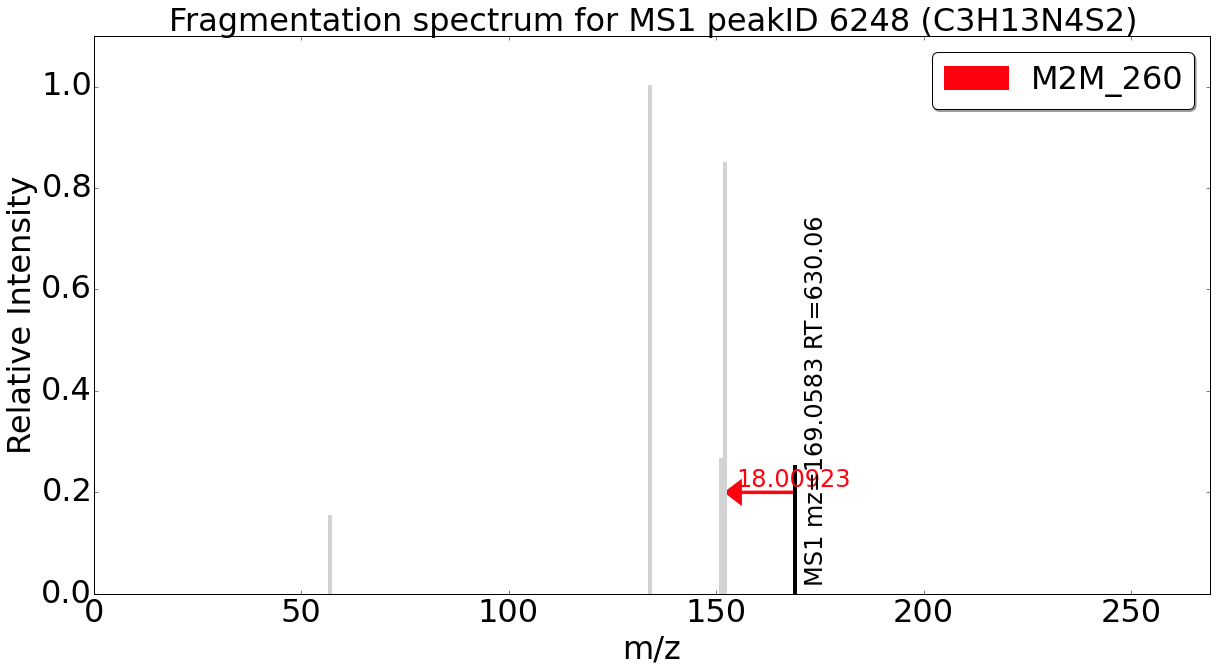

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0  134.059906       1.000000  fragment_134.06003             NaN   
1  152.070084       0.847020  fragment_152.07028             NaN   
2  151.047134       0.263841  fragment_151.04713             NaN   
3   56.965027       0.150842    fragment_56.9651             NaN   
4  169.096741       0.140474  fragment_169.09672             NaN   

       loss_word  loss_motif         ef  
0            NaN         NaN     C8H8ON  
1            NaN         NaN  C2H11ON5P  
2  loss_18.00923         260        NaN  
3            NaN         NaN        NaN  
4            NaN         NaN  C8H13O2N2

 - M2M_98	: Fragments possibly indicative for N-Methyl-oxo-pyrrolidinecarboxylic acid like structure
		  fragment_98.06001 (0.816),fragment_144.0659 (0.022),fragment_381.08163 (0.016),fragment_297.16275 (0.011),
 - M2M_158	: Leucine substructure
		  fragment_86.09652 (0.794),fragment_132.10154 (0.048),fragment_219.90121 (0.031),fragment_293.3515 (0.031),fragment_189.12428 (0.012),
 - M2M_214	: Amine loss - suggests free NH2 group in fragmented molecule
		  loss_17.02527 (0.883),fragment_366.10831 (0.021),

(2443, 'C5H14ON3')


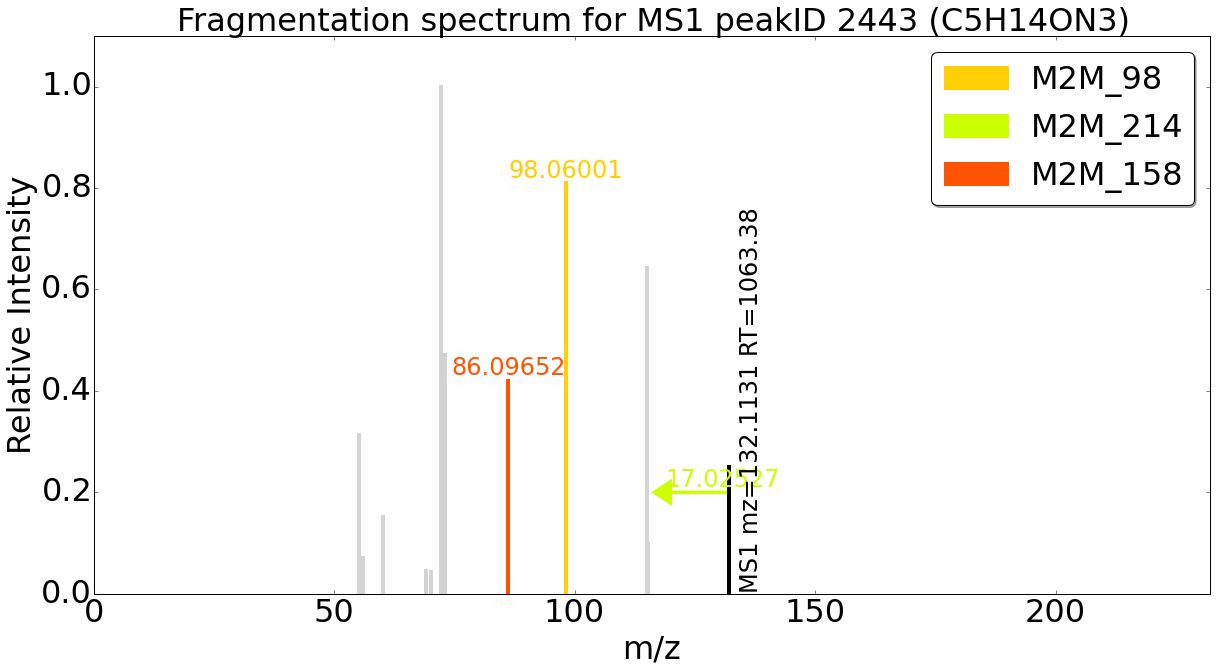

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0    72.080742       1.000000    fragment_72.0807             NaN   
1    98.060013       0.809795   fragment_98.06001              98   
2   115.087135       0.641671  fragment_115.08708             NaN   
3    73.084244       0.470071   fragment_73.08418             NaN   
4    86.096512       0.420301   fragment_86.09652             158   
5    55.054703       0.312518   fragment_55.05466             NaN   
6    60.055866       0.151087   fragment_60.05587             NaN   
7   115.105705       0.098178   fragment_115.1057             NaN   
8    56.013577       0.070337   fragment_56.01352             NaN   
9    73.039703       0.063124   fragment_73.03969             NaN   
10   69.070068       0.045261   fragment_69.07013             NaN   
11   70.065079       0.043604   fragment_70.06514             NaN   
12   86.060112       0.039909   fragment_86.06016             NaN   

        loss_word  loss_motif                  ef  
0   loss_60.03217         NaN  C4H10N,loss_CH4ON2  
1   loss_34.05284         NaN              C5H8ON  
2   loss_17.02527         214            C5H11ON2  
3             NaN         NaN                 NaN  
4   loss_46.01667         NaN   C5H12N,loss_H2ON2  
5   loss_77.05878         NaN                C4H7  
6   loss_72.05724         NaN    CH6N3,loss_C4H8O  
7             NaN         NaN                 NaN  
8             NaN         NaN              C2H2ON  
9   loss_59.07313         NaN  C2H5ON2,loss_C3H9N  
10            NaN         NaN                C5H9  
11  loss_62.04775         NaN               C4H8N  
12   loss_46.0529         NaN              C4H8ON

 - M2M_260	: Water loss - indicative of a free hydroxyl group
		  loss_18.00923 (0.942),fragment_176.09136 (0.015),
 - M2M_262	: Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure
		  loss_46.00539 (0.854),loss_74.0003 (0.058),loss_47.0087 (0.017),fragment_100.11239 (0.016),

(815, 'C4H5O4')


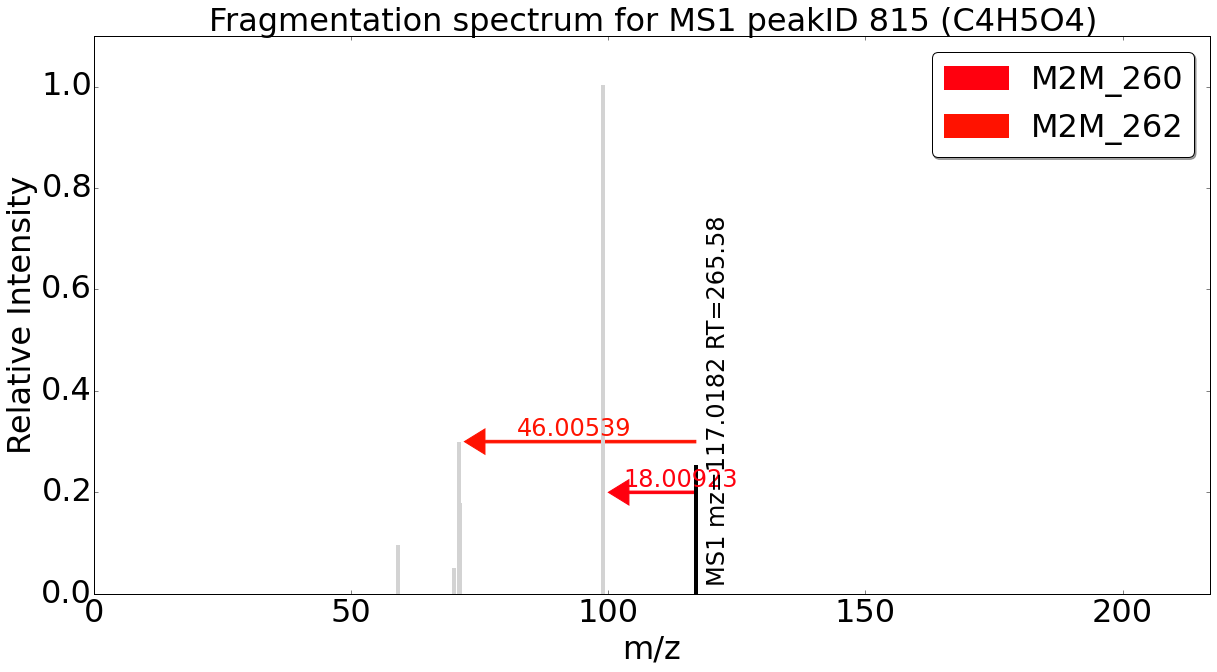

ms2_mz  ms2_intensity      fragment_word  fragment_motif      loss_word  \
0  99.008072       1.000000  fragment_99.00811             NaN  loss_18.00923   
1  71.013039       0.295656  fragment_71.01303             NaN  loss_46.00539   
2  71.068764       0.175453  fragment_71.06872             NaN            NaN   
3  59.049435       0.091511   fragment_59.0494             NaN            NaN   
4  70.065102       0.047146  fragment_70.06514             NaN            NaN   

   loss_motif                 ef  
0         260             C4H3O3  
1         262  C3H3O2,loss_CH2O2  
2         NaN                NaN  
3         NaN              C3H7O  
4         NaN              C4H8N

 - No M2M for this MS1 peak at the specified thresholding levels



None

 - No M2M for this MS1 peak at the specified thresholding levels



None

 - M2M_53	: Losses indicative of a hexose with NH2 group
		  loss_179.07913 (0.423),loss_197.08988 (0.319),fragment_439.13843 (0.027),fragment_107.0708 (0.026),fragment_282.13229 (0.016),

(28638, 'C18H23O2N2P2')


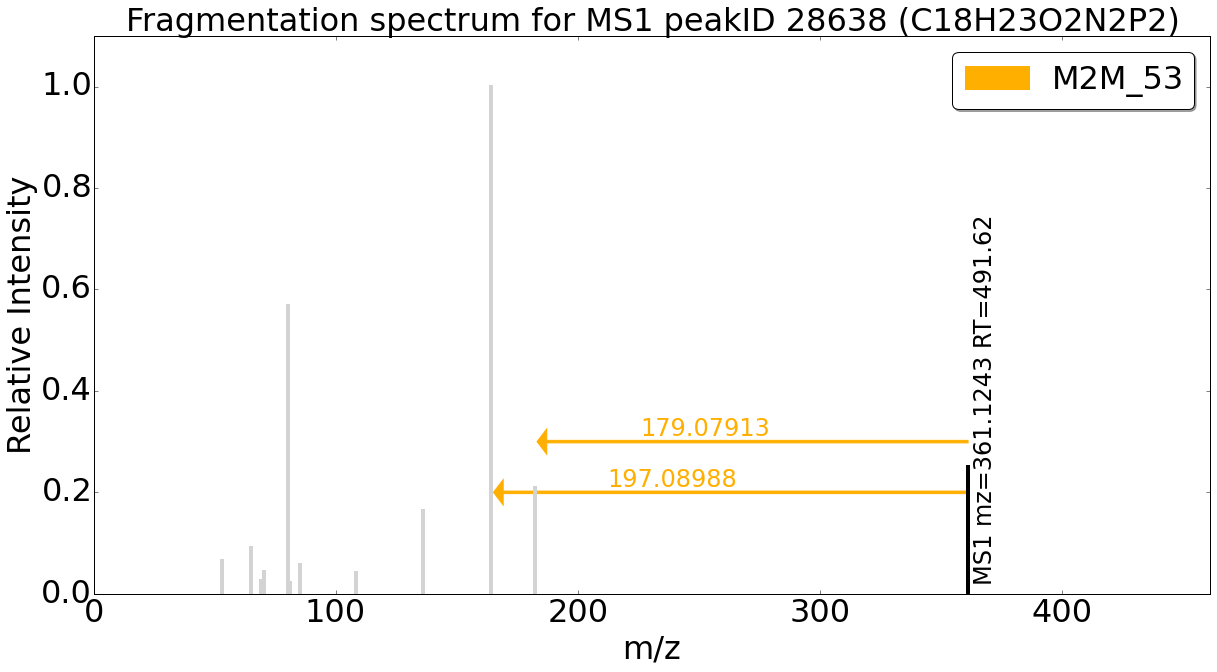

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0   164.034622       1.000000   fragment_164.0346             NaN   
1    80.049477       0.567536   fragment_80.04949             NaN   
2   182.044754       0.209446  fragment_182.04472             NaN   
3   136.039795       0.163906  fragment_136.03971             NaN   
4    65.038780       0.089833   fragment_65.03878             NaN   
5    53.038910       0.063941   fragment_53.03888             NaN   
6    85.028252       0.057275   fragment_85.02832             NaN   
7    70.065201       0.042717   fragment_70.06514             NaN   
8   108.044006       0.041368  fragment_108.04425             NaN   
9    69.033615       0.025207   fragment_69.03368             NaN   
10   81.033295       0.021580   fragment_81.03334             NaN   

         loss_word  loss_motif                     ef  
0   loss_197.08988          53  C8H6O3N,loss_C6H15O6N  
1              NaN         NaN                  C5H6N  
2   loss_179.07913          53  C8H8O4N,loss_C6H13O5N  
3              NaN         NaN                C7H6O2N  
4              NaN         NaN                   C5H5  
5              NaN         NaN                   C4H5  
6              NaN         NaN                 C4H5O2  
7              NaN         NaN                  C4H8N  
8              NaN         NaN                 C6H6ON  
9              NaN         NaN                  C4H5O  
10             NaN         NaN                  C5H5O

 - No M2M for this MS1 peak at the specified thresholding levels



None

 - M2M_2	: Small nitrogen containing fragment ion - often proline or ornithine derived
		  fragment_70.06514 (0.979),
 - M2M_174	: Pyroglutamic acid (pyroglutamate) substructure
		  fragment_84.0442 (0.854),fragment_56.04977 (0.102),
 - M2M_262	: Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure
		  loss_46.00539 (0.854),loss_74.0003 (0.058),loss_47.0087 (0.017),fragment_100.11239 (0.016),

(1771, 'C5H8O3N')


ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0    70.065063       1.000000   fragment_70.06514               2   
1    84.063820       0.558623   fragment_84.06386             NaN   
2    84.044708       0.542326    fragment_84.0442             174   
3    83.060249       0.157396   fragment_83.06041             NaN   
4    56.049774       0.114498   fragment_56.04977             174   
5   130.070114       0.103405  fragment_130.07016             NaN   
6    84.057968       0.102290   fragment_84.05797             NaN   
7   112.086731       0.091804  fragment_112.08704             NaN   
8   130.050110       0.062032  fragment_130.05051             NaN   
9    57.053253       0.057082   fragment_57.05319             NaN   
10  130.097824       0.029904  fragment_130.09798             NaN   
11   71.049286       0.025054   fragment_71.04937             NaN   
12   85.028114       0.020592   fragment_85.02832             NaN   
13   60.055882       0.014055   fragment_60.05587             NaN   
14   53.002594       0.013382   fragment_53.00259             NaN   
15  102.055580       0.007313  fragment_102.05568             NaN   
16   57.046654       0.006079   fragment_57.04668             NaN   
17   67.054466       0.003849   fragment_67.05454             NaN   
18   88.075806       0.003241   fragment_88.07588             NaN   
19   67.037285       0.002923   fragment_67.03728             NaN   
20   68.049728       0.002743   fragment_68.04977             NaN   
21  114.287888       0.001984  fragment_114.28789             NaN   
22   85.084045       0.001916   fragment_85.08406             NaN   

        loss_word  loss_motif                 ef  
0   loss_59.98468         NaN              C4H8N  
1   loss_45.98608         NaN                NaN  
2   loss_46.00539         262  C4H6ON,loss_CH2O2  
3             NaN         NaN             C4H7N2  
4    loss_74.0003         262  C3H6N,loss_C2H2O3  
5             NaN         NaN                NaN  
6   loss_45.99208         NaN                NaN  
7             NaN         NaN            C5H10N3  
8             NaN         NaN            C5H8O3N  
9             NaN         NaN                NaN  
10            NaN         NaN           C5H12ON3  
11  loss_59.00065         NaN   C4H7O,loss_CHO2N  
12  loss_45.02195         NaN             C4H5O2  
13            NaN         NaN              CH6N3  
14  loss_77.04757         NaN  C3HO,loss_C2H7O2N  
15  loss_27.99401         NaN                NaN  
16            NaN         NaN                NaN  
17  loss_62.99542         NaN     C5H7,loss_HO3N  
18  loss_41.97401         NaN            C4H10ON  
19            NaN         NaN                NaN  
20  loss_62.00034         NaN              C4H6N  
21            NaN         NaN                NaN  
22            NaN         NaN                NaN

 - No M2M for this MS1 peak at the specified thresholding levels



None

 - M2M_58	: Ethylphenol substructure (e.g. resulting from Tyramine - MzCloud)
		  fragment_121.06489 (0.412),fragment_103.05448 (0.103),fragment_93.06981 (0.082),fragment_53.03888 (0.080),fragment_91.05413 (0.071),fragment_152.10755 (0.027),loss_68.02601 (0.026),fragment_138.05067 (0.023),fragment_166.12292 (0.023),fragment_95.04936 (0.013),

(34065, 'C20H42O12N3P2')


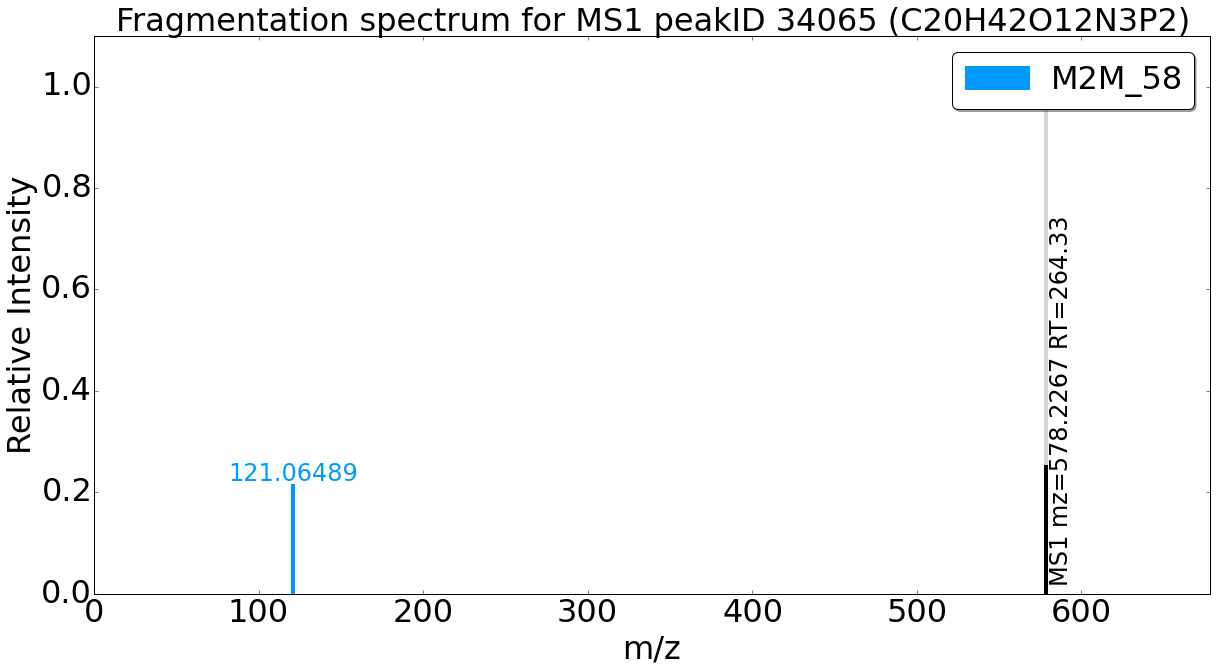

ms2_mz  ms2_intensity       fragment_word  fragment_motif  loss_word  \
0  578.225464       1.000000  fragment_578.22546             NaN        NaN   
1  121.064865       0.212722  fragment_121.06489              58        NaN   

   loss_motif     ef  
0         NaN    NaN  
1         NaN  C8H9O

 - M2M_260	: Water loss - indicative of a free hydroxyl group
		  loss_18.00923 (0.942),fragment_176.09136 (0.015),

(2679, 'C5H13S2')


ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0   137.046188       1.000000  fragment_137.04626             NaN   
1   110.034645       0.172824  fragment_110.03458             NaN   
2   119.035164       0.142227  fragment_119.03518             NaN   
3    94.039665       0.073201    fragment_94.0397             NaN   
4    55.029507       0.061986   fragment_55.02948             NaN   
5    82.040329       0.055204   fragment_82.04025             NaN   
6    92.024315       0.019536   fragment_92.02437             NaN   
7    67.029060       0.018346   fragment_67.02909             NaN   
8   138.029922       0.014060  fragment_138.02992             NaN   
9   112.051094       0.007813  fragment_112.05105             NaN   
10   83.023811       0.004524   fragment_83.02381             NaN   
11  120.037994       0.004253  fragment_120.03799             NaN   
12  128.045547       0.004048  fragment_128.04551             NaN   
13   94.045738       0.003934   fragment_94.04574             NaN   
14   65.013397       0.003198   fragment_65.01338             NaN   
15   92.019348       0.002145   fragment_92.01935             NaN   
16   87.745193       0.001945   fragment_87.74519             NaN   
17  101.505402       0.001826   fragment_101.5054             NaN   
18   59.186031       0.001729   fragment_59.18603             NaN   

        loss_word  loss_motif                   ef  
0             NaN         NaN              C5H5ON4  
1   loss_27.01101         NaN     C4H4ON3,loss_CHN  
2   loss_18.00923         260               C5H3N4  
3   loss_43.00571         NaN     C4H4N3,loss_CHON  
4             NaN         NaN               C2H3N2  
5   loss_55.00558         NaN    C3H4N3,loss_C2HON  
6   loss_45.02125         NaN    C4H2N3,loss_CH3ON  
7   loss_70.01648         NaN  C3H3N2,loss_C2H2ON2  
8             NaN         NaN             C5H4O2N3  
9             NaN         NaN              C4H6ON3  
10  loss_54.02177         NaN  C3H3ON2,loss_C2H2N2  
11            NaN         NaN                  NaN  
12            NaN         NaN             C4H6O2N3  
13            NaN         NaN                  NaN  
14  loss_72.03221         NaN   C3HN2,loss_C2H4ON2  
15            NaN         NaN                  NaN  
16            NaN         NaN                  NaN  
17            NaN         NaN                  NaN  
18            NaN         NaN                  NaN

 - M2M_230	: N/O-acetylation loss
		  fragment_87.04391 (0.782),fragment_187.88232 (0.031),fragment_210.89943 (0.017),

(34103, 'C29H50O9N3')


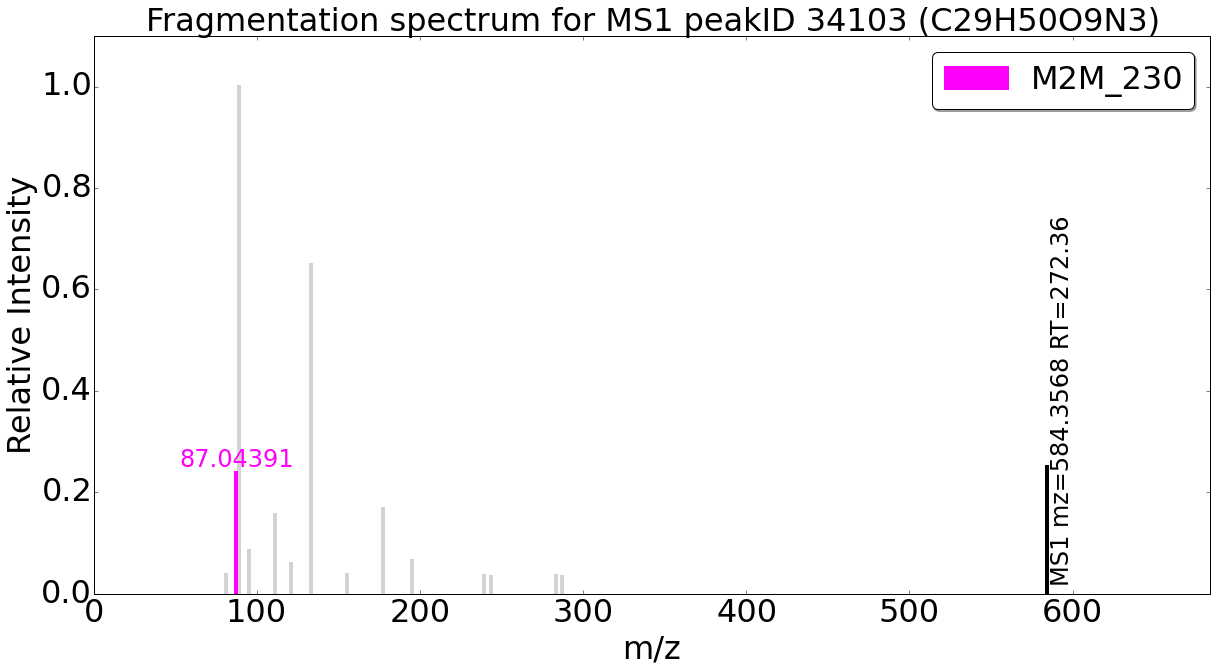

ms2_mz  ms2_intensity       fragment_word  fragment_motif  loss_word  \
0    89.060127       1.000000   fragment_89.06006             NaN        NaN   
1   133.086288       0.648778  fragment_133.08631             NaN        NaN   
2    87.043961       0.238672   fragment_87.04391             230        NaN   
3   177.112350       0.167717  fragment_177.11278             NaN        NaN   
4   111.044228       0.155588  fragment_111.04428             NaN        NaN   
5    95.049339       0.085307   fragment_95.04936             NaN        NaN   
6   195.122406       0.063897  fragment_195.12247             NaN        NaN   
7   121.064873       0.057806  fragment_121.06489             NaN        NaN   
8    81.033302       0.037195   fragment_81.03334             NaN        NaN   
9   155.070053       0.036400  fragment_155.07011             NaN        NaN   
10  283.173523       0.034891  fragment_283.17366             NaN        NaN   
11  239.148117       0.034410  fragment_239.14817             NaN        NaN   
12  243.122238       0.033251  fragment_243.12233             NaN        NaN   
13  287.146973       0.032637  fragment_287.14697             NaN        NaN   

    loss_motif          ef  
0          NaN      C4H9O2  
1          NaN     C6H13O3  
2          NaN      C4H7O2  
3          NaN     C8H17O4  
4          NaN      C6H7O2  
5          NaN       C6H7O  
6          NaN     C8H19O5  
7          NaN       C8H9O  
8          NaN       C5H5O  
9          NaN     C8H11O3  
10         NaN         NaN  
11         NaN    C10H23O6  
12         NaN  C6H20O4N4P  
13         NaN         NaN

 - No M2M for this MS1 peak at the specified thresholding levels



None

 - M2M_158	: Leucine substructure
		  fragment_86.09652 (0.794),fragment_132.10154 (0.048),fragment_219.90121 (0.031),fragment_293.3515 (0.031),fragment_189.12428 (0.012),

(14104, 'C10H19N2S2')


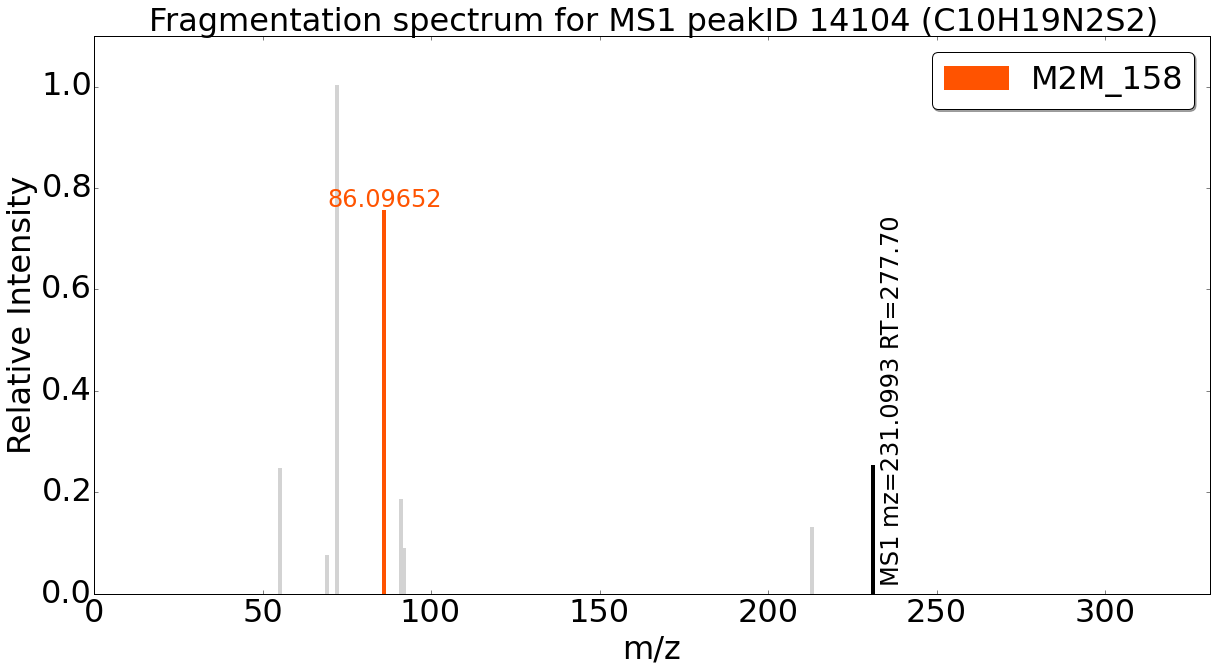

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0   72.080719       1.000000    fragment_72.0807             NaN   
1   86.096558       0.752620   fragment_86.09652             158   
2   55.054665       0.244698   fragment_55.05466             NaN   
3   91.054146       0.182723   fragment_91.05413             NaN   
4  231.099762       0.135952  fragment_231.09976             NaN   
5  213.109665       0.126978  fragment_213.10966             NaN   
6   92.057800       0.085654   fragment_92.05779             NaN   
7   69.070053       0.072779   fragment_69.07013             NaN   

        loss_word  loss_motif                 ef  
0             NaN         NaN             C4H10N  
1             NaN         NaN             C5H12N  
2             NaN         NaN               C4H7  
3  loss_140.04686         NaN   C7H7,loss_C7H8O3  
4             NaN         NaN          C10H11ON6  
5             NaN         NaN          C7H13O2N6  
6             NaN         NaN                NaN  
7  loss_162.02881         NaN  C5H9,loss_C5H2ON6

 - M2M_2	: Small nitrogen containing fragment ion - often proline or ornithine derived
		  fragment_70.06514 (0.979),
 - M2M_214	: Amine loss - suggests free NH2 group in fragmented molecule
		  loss_17.02527 (0.883),fragment_366.10831 (0.021),
 - M2M_151	: [proline-H2O] suggests conjugated proline substructure
		  fragment_116.07116 (0.473),loss_143.05783 (0.166),loss_161.06841 (0.128),loss_115.06303 (0.101),

(2538, 'C5H13O2N2')


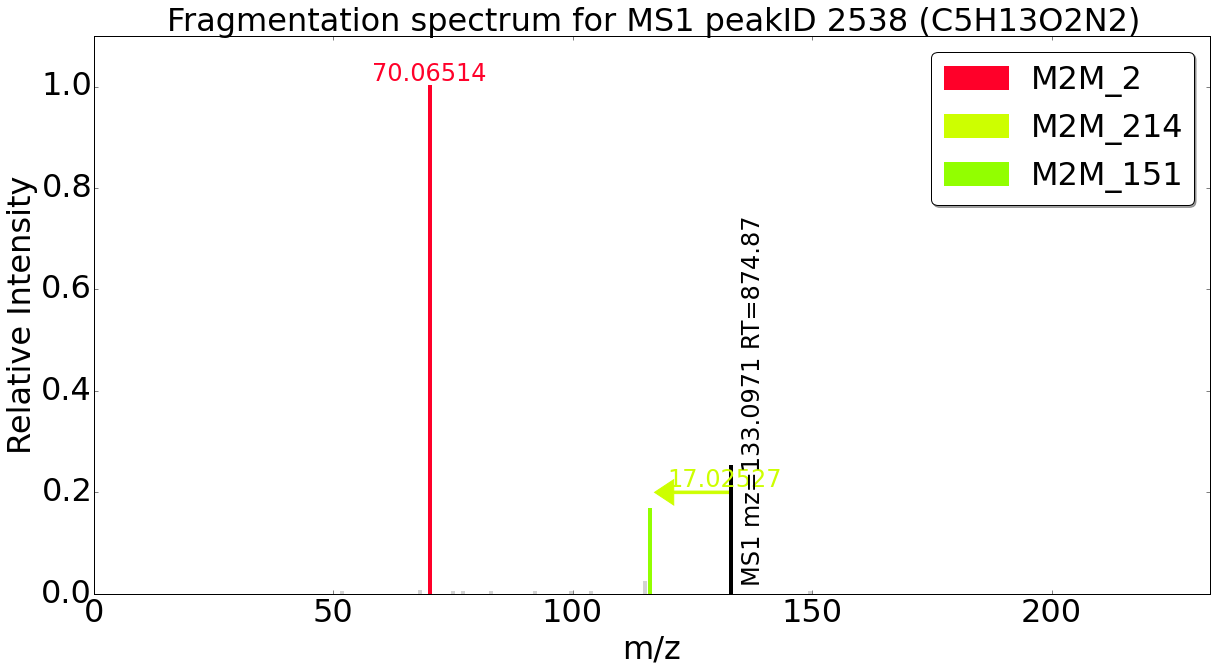

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0    70.065086       1.000000   fragment_70.06514               2   
1   116.071007       0.165084  fragment_116.07116             151   
2   115.086891       0.021284  fragment_115.08708             NaN   
3    68.049767       0.003609   fragment_68.04977             NaN   
4   133.097900       0.003367  fragment_133.09777             NaN   
5    99.635223       0.002193   fragment_99.63522             NaN   
6    92.026001       0.001910   fragment_92.02608             NaN   
7   149.608582       0.001810  fragment_149.60858             NaN   
8    77.039375       0.001747   fragment_77.03938             NaN   
9   103.854904       0.001698  fragment_103.85492             NaN   
10   82.870430       0.001568   fragment_82.87043             NaN   
11   75.048897       0.001450    fragment_75.0489             NaN   
12   51.809437       0.001383   fragment_51.80944             NaN   

        loss_word  loss_motif                 ef  
0   loss_63.03191         NaN  C4H8N,loss_CH5O2N  
1   loss_17.02527         214           C5H10O2N  
2   loss_18.00923         NaN           C5H11ON2  
3   loss_65.04759         NaN              C4H6N  
4             NaN         NaN          C5H13O2N2  
5             NaN         NaN                NaN  
6             NaN         NaN            C2H7ONP  
7             NaN         NaN                NaN  
8             NaN         NaN                NaN  
9             NaN         NaN                NaN  
10            NaN         NaN                NaN  
11            NaN         NaN                NaN  
12            NaN         NaN                NaN

 - M2M_2	: Small nitrogen containing fragment ion - often proline or ornithine derived
		  fragment_70.06514 (0.979),

(34565, 'C32H52O11N4PS2')


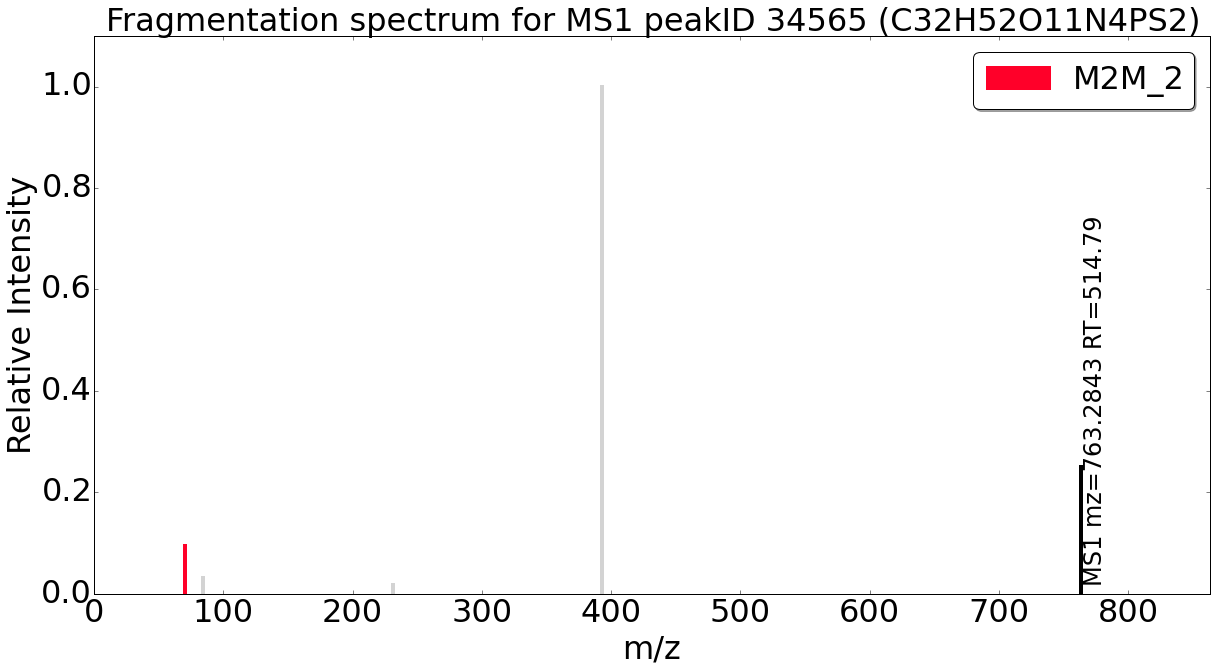

ms2_mz  ms2_intensity       fragment_word  fragment_motif  loss_word  \
0  393.138489       1.000000  fragment_393.13831             NaN        NaN   
1   70.065216       0.094901   fragment_70.06514               2        NaN   
2   84.044167       0.030802    fragment_84.0442             NaN        NaN   
3  231.083298       0.017321  fragment_231.08324             NaN        NaN   

   loss_motif         ef  
0         NaN        NaN  
1         NaN      C4H8N  
2         NaN     C4H6ON  
3         NaN  C5H15O8N2

 - M2M_129	: fragments from [hexose-H2O] substructure (a hexose conjugation, e.g. glucose)
		  fragment_145.04997 (0.260),fragment_127.03868 (0.188),fragment_85.02832 (0.152),fragment_163.06064 (0.079),fragment_97.02839 (0.055),fragment_81.03334 (0.041),fragment_69.03368 (0.037),fragment_103.03863 (0.036),fragment_109.02882 (0.032),fragment_99.04454 (0.021),fragment_99.04377 (0.017),fragment_53.03888 (0.013),fragment_325.11195 (0.011),
 - M2M_131	: fragments from [hexose-H2O] substructure (a hexose conjugation, e.g. glucose)
		  fragment_85.02832 (0.566),fragment_69.03368 (0.105),fragment_97.02839 (0.088),fragment_61.02854 (0.070),fragment_57.0337 (0.045),fragment_91.03925 (0.022),fragment_127.03868 (0.021),fragment_73.0285 (0.019),fragment_55.01824 (0.019),
 - M2M_220	: Adenine substructure
		  fragment_136.06239 (0.688),loss_162.03528 (0.049),fragment_119.03518 (0.039),loss_153.04184 (0.027),fragment_137.04626 (0.020),

(31388, 'C14H30O7NS2')


ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0   137.046066       1.000000  fragment_137.04626             220   
1   136.062286       0.440050  fragment_136.06239             220   
2    85.028275       0.374070   fragment_85.02832             129   
3   145.049942       0.218507  fragment_145.04997             129   
4    70.065102       0.131665   fragment_70.06514             NaN   
5   209.091965       0.105651  fragment_209.09231             NaN   
6    69.033745       0.103755   fragment_69.03368             129   
7   119.034981       0.100408  fragment_119.03518             220   
8    97.028305       0.097602   fragment_97.02839             129   
9   127.038734       0.085458  fragment_127.03868             129   
10  163.060364       0.061469  fragment_163.06064             129   
11   84.044868       0.058696   fragment_84.04486             NaN   
12  110.035591       0.051415  fragment_110.03558             NaN   
13   81.033302       0.034625   fragment_81.03334             129   
14   61.028439       0.032721   fragment_61.02854             131   
15   57.033615       0.030874    fragment_57.0337             131   
16   94.040520       0.024777   fragment_94.04051             NaN   

         loss_word  loss_motif                          ef  
0              NaN         NaN                     C5H5ON4  
1              NaN         NaN                      C5H6N5  
2              NaN         NaN                      C4H5O2  
3              NaN         NaN                      C6H9O4  
4              NaN         NaN                       C4H8N  
5   loss_179.05693         NaN  C10H13O3N2,loss_C3H10O2N5P  
6              NaN         NaN                       C4H5O  
7              NaN         NaN                      C5H3N4  
8              NaN         NaN                      C5H5O2  
9              NaN         NaN                      C6H7O3  
10             NaN         NaN                     C6H11O5  
11             NaN         NaN                         NaN  
12             NaN         NaN                         NaN  
13             NaN         NaN                       C5H5O  
14             NaN         NaN                      C2H5O2  
15             NaN         NaN                       C3H5O  
16             NaN         NaN                         NaN

 - No M2M for this MS1 peak at the specified thresholding levels



None

 - M2M_230	: N/O-acetylation loss
		  fragment_87.04391 (0.782),fragment_187.88232 (0.031),fragment_210.89943 (0.017),

(34244, 'C31H54O10N3')


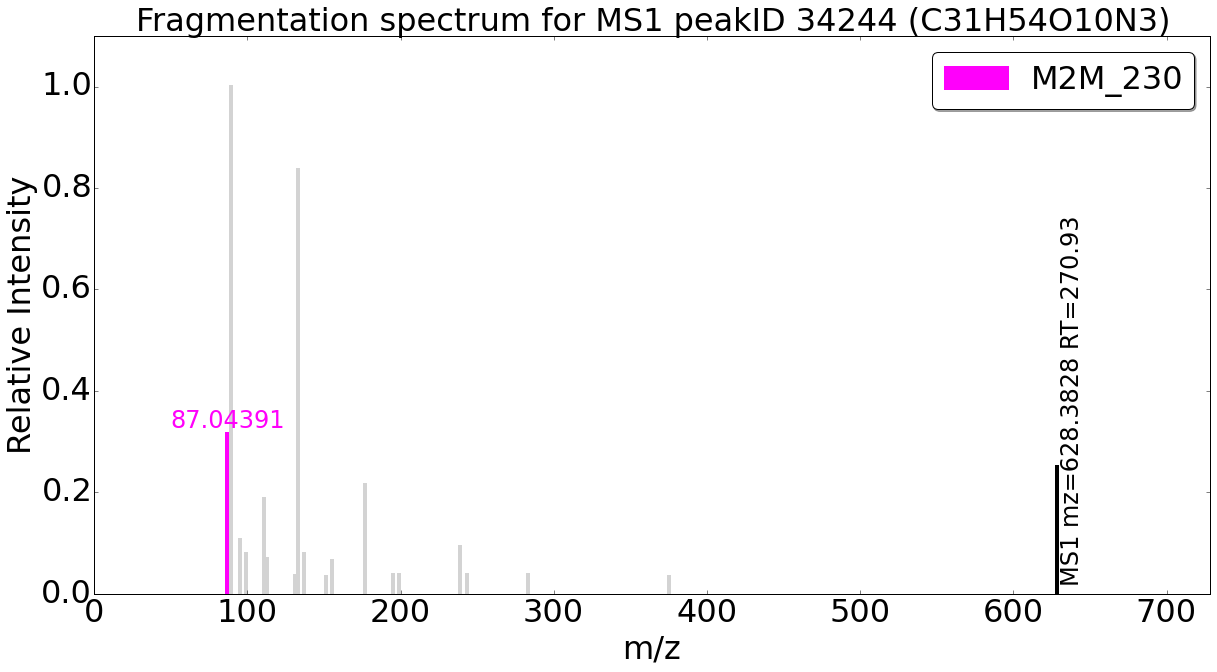

ms2_mz  ms2_intensity       fragment_word  fragment_motif  loss_word  \
0    89.060150       1.000000   fragment_89.06006             NaN        NaN   
1   133.086349       0.834571  fragment_133.08631             NaN        NaN   
2    87.044022       0.315809   fragment_87.04391             230        NaN   
3   177.113281       0.214429  fragment_177.11278             NaN        NaN   
4   111.044289       0.185960  fragment_111.04428             NaN        NaN   
5    95.049408       0.106094   fragment_95.04936             NaN        NaN   
6   239.148300       0.092471  fragment_239.14817             NaN        NaN   
7   137.059952       0.078799  fragment_137.05989             NaN        NaN   
8    99.044617       0.078249   fragment_99.04454             NaN        NaN   
9   113.060287       0.067756   fragment_113.0602             NaN        NaN   
10  155.070175       0.064992  fragment_155.07011             NaN        NaN   
11  243.122421       0.037486  fragment_243.12233             NaN        NaN   
12  195.122559       0.037301  fragment_195.12247             NaN        NaN   
13  199.096191       0.037150  fragment_199.09609             NaN        NaN   
14  283.173737       0.036960  fragment_283.17366             NaN        NaN   
15  131.070831       0.035034  fragment_131.07078             NaN        NaN   
16  151.096786       0.033108  fragment_151.09674             NaN        NaN   
17  375.204285       0.032772  fragment_375.20428             NaN        NaN   

    loss_motif          ef  
0          NaN      C4H9O2  
1          NaN     C6H13O3  
2          NaN      C4H7O2  
3          NaN     C8H17O4  
4          NaN      C6H7O2  
5          NaN       C6H7O  
6          NaN    C10H23O6  
7          NaN      C8H9O2  
8          NaN      C5H7O2  
9          NaN      C6H9O2  
10         NaN     C8H11O3  
11         NaN  C6H20O4N4P  
12         NaN     C8H19O5  
13         NaN  C4H16O3N4P  
14         NaN         NaN  
15         NaN     C6H11O3  
16         NaN     C6H15O4  
17         NaN         NaN

 - M2M_220	: Adenine substructure
		  fragment_136.06239 (0.688),loss_162.03528 (0.049),fragment_119.03518 (0.039),loss_153.04184 (0.027),fragment_137.04626 (0.020),

(29287, nan)


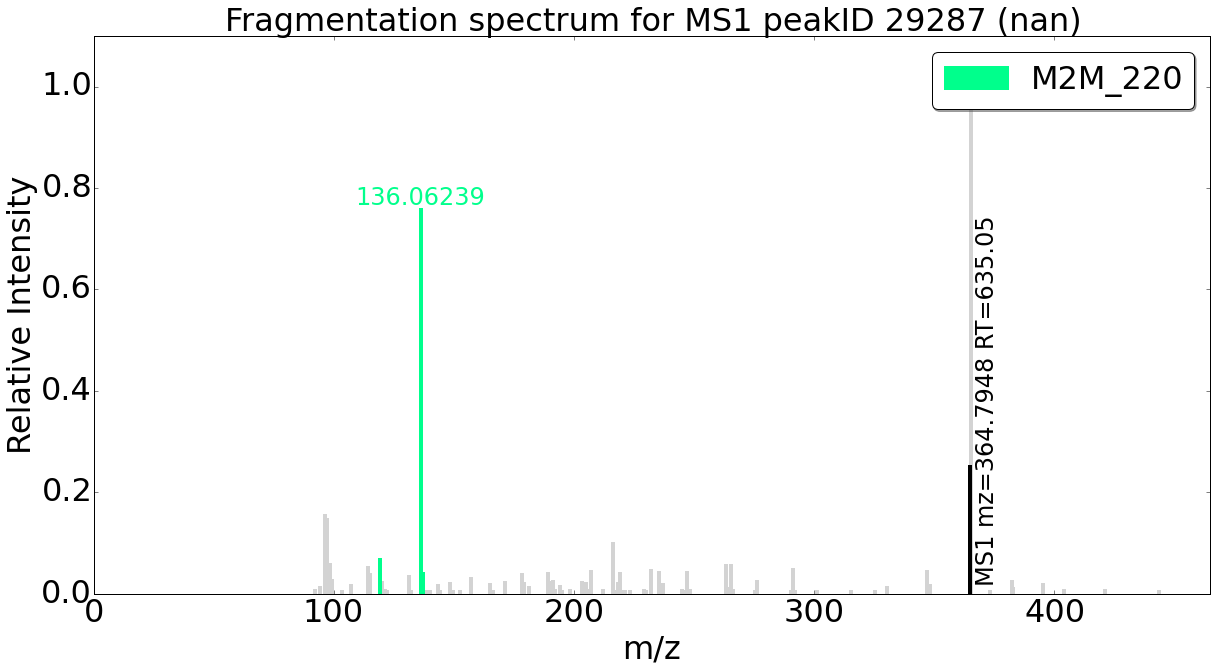

ms2_mz  ms2_intensity       fragment_word  fragment_motif  loss_word  \
0   365.106995       1.000000  fragment_365.10697             NaN        NaN   
1   136.062408       0.756757  fragment_136.06239             220        NaN   
2    96.044128       0.152688   fragment_96.04413             NaN        NaN   
3    97.028366       0.145982   fragment_97.02839             NaN        NaN   
4   216.028198       0.097443   fragment_216.0282             NaN        NaN   
5   119.035240       0.066735  fragment_119.03518             220        NaN   
6   534.278687       0.059468  fragment_534.27864             NaN        NaN   
7    98.059975       0.055982   fragment_98.06001             NaN        NaN   
8   265.083801       0.054731  fragment_265.08376             NaN        NaN   
9   263.069427       0.053979  fragment_263.06912             NaN        NaN   
10  114.102715       0.051211  fragment_114.10279             NaN        NaN   
11  291.063538       0.047363  fragment_291.06354             NaN        NaN   
12  232.083221       0.044436  fragment_232.08279             NaN        NaN   
13  347.095062       0.043649  fragment_347.09548             NaN        NaN   
14  207.080200       0.042239  fragment_207.07981             NaN        NaN   
15  247.074982       0.040632  fragment_247.07445             NaN        NaN   
16  235.075394       0.040547  fragment_235.07587             NaN        NaN   
17  189.070587       0.039084  fragment_189.07017             NaN        NaN   
18  137.046661       0.038940  fragment_137.04626             220        NaN   
19  219.080612       0.038270  fragment_219.08066             NaN        NaN   
20  115.054245       0.037719  fragment_115.05435             NaN        NaN   
21  178.076599       0.037400   fragment_178.0764             NaN        NaN   
22  131.129318       0.033625  fragment_131.12915             NaN        NaN   
23   97.076561       0.029401   fragment_97.07643             NaN        NaN   
24  157.108215       0.028465  fragment_157.10838             NaN        NaN   
25   98.983955       0.024995   fragment_98.98385             NaN        NaN   
26  382.164795       0.023660  fragment_382.16485             NaN        NaN   
27  137.067184       0.022876  fragment_137.06711             NaN        NaN   
28  191.085403       0.022840   fragment_191.0857             NaN        NaN   
29  276.155243       0.022516  fragment_276.15583             NaN        NaN   
..         ...            ...                 ...             ...        ...   
69  373.158325       0.004366  fragment_373.15862             NaN        NaN   
70  246.633224       0.004360  fragment_246.63322             NaN        NaN   
71  144.057663       0.004310  fragment_144.05767             NaN        NaN   
72  220.083969       0.004296  fragment_220.08397             NaN        NaN   
73  132.065598       0.004207  fragment_132.06554             NaN        NaN   
74  195.081131       0.004144  fragment_195.08114             NaN        NaN   
75  139.050720       0.004035  fragment_139.05068             NaN        NaN   
76  131.048019       0.004008  fragment_131.04802             NaN        NaN   
77  325.128784       0.003967  fragment_325.12878             NaN        NaN   
78  517.266724       0.003891  fragment_517.26672             NaN        NaN   
79  954.190247       0.003751  fragment_954.19025             NaN        NaN   
80  778.524292       0.003685  fragment_778.52429             NaN        NaN   
81  230.043961       0.003616  fragment_230.04396             NaN        NaN   
82  301.167572       0.003492  fragment_301.16757             NaN        NaN   
83  236.077255       0.003482  fragment_236.07726             NaN        NaN   
84  221.059601       0.003470  fragment_221.05945             NaN        NaN   
85  290.391083       0.003443  fragment_290.39108             NaN        NaN   
86  223.074646       0.003409  fragment_223.07461             NaN        NaN   
87  166.

 - M2M_174	: Pyroglutamic acid (pyroglutamate) substructure
		  fragment_84.0442 (0.854),fragment_56.04977 (0.102),
 - M2M_158	: Leucine substructure
		  fragment_86.09652 (0.794),fragment_132.10154 (0.048),fragment_219.90121 (0.031),fragment_293.3515 (0.031),fragment_189.12428 (0.012),

(19674, 'C14H28OPS')


ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0   86.096527       1.000000   fragment_86.09652             158   
1   84.044159       0.553680    fragment_84.0442             174   
2  146.117966       0.496133  fragment_146.11798             NaN   
3   69.070160       0.153823   fragment_69.07013             NaN   
4   56.049828       0.112227   fragment_56.04977             174   
5  258.133484       0.077786  fragment_258.13325             NaN   
6  130.050629       0.075698  fragment_130.05051             NaN   
7  212.127640       0.045745  fragment_212.12758             NaN   
8  184.133774       0.031590  fragment_184.13379             NaN   

        loss_word  loss_motif                      ef  
0  loss_189.06327         NaN    C5H12N,loss_C7H11O5N  
1  loss_191.11566         NaN    C4H6ON,loss_C8H17O4N  
2  loss_129.04224         NaN   C7H16O2N,loss_C5H7O3N  
3             NaN         NaN                    C5H9  
4             NaN         NaN                   C3H6N  
5   loss_17.02527         NaN              C6H21O4N5P  
6   loss_145.1099         NaN   C5H8O3N,loss_C7H15O2N  
7   loss_63.03191         NaN  C5H19O2N5P,loss_CH5O2N  
8    loss_91.0268         NaN  C10H18O2N,loss_C2H5O3N

 - No M2M for this MS1 peak at the specified thresholding levels



None

 - M2M_130	: Cytosine and a loss of conjugated deoxyribose substructure
		  fragment_112.05105 (0.273),fragment_113.05456 (0.130),fragment_95.02389 (0.063),loss_133.04527 (0.037),fragment_96.02703 (0.035),fragment_113.04771 (0.026),fragment_125.03493 (0.019),fragment_69.04506 (0.016),fragment_100.03925 (0.015),fragment_191.04568 (0.015),fragment_209.05505 (0.014),loss_43.00571 (0.011),fragment_155.04439 (0.010),

(12427, 'C8H19ON2S2')


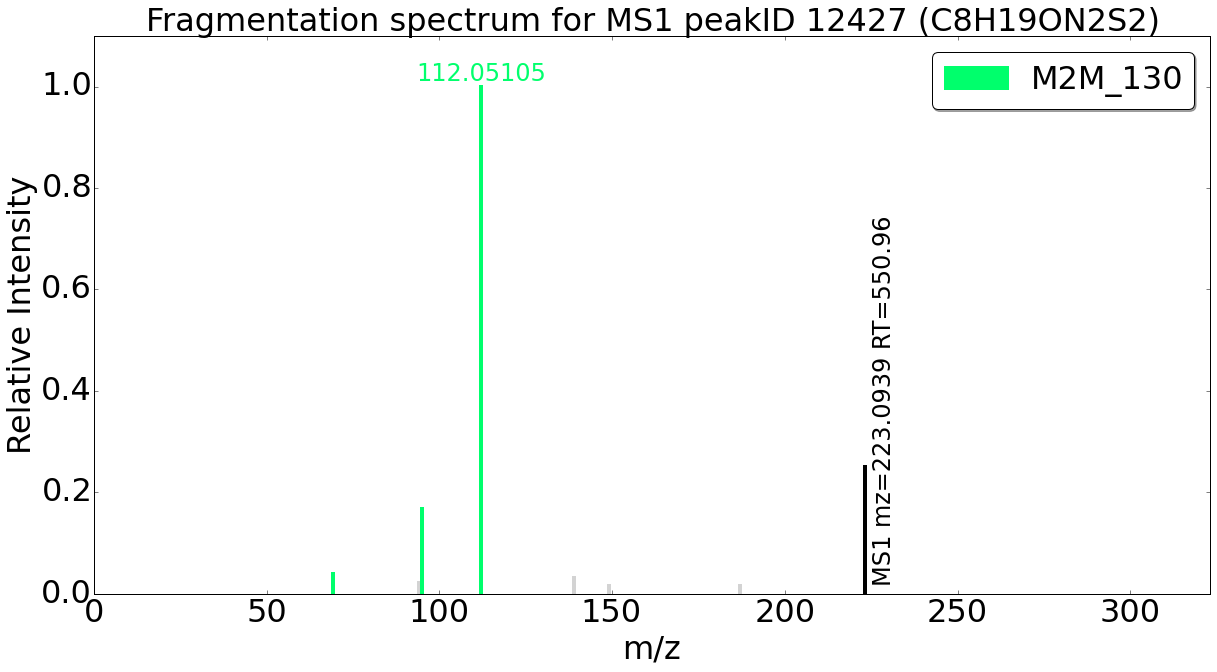

ms2_mz  ms2_intensity       fragment_word  fragment_motif  \
0  112.051140       1.000000  fragment_112.05105             130   
1   95.023941       0.167630   fragment_95.02389             130   
2   69.045174       0.039556   fragment_69.04506             130   
3  139.058487       0.032009  fragment_139.05844             NaN   
4   94.039734       0.020625    fragment_94.0397             NaN   
5  149.023804       0.016242   fragment_149.0237             NaN   
6  187.079010       0.015622  fragment_187.07901             NaN   

        loss_word  loss_motif                   ef  
0             NaN         NaN              C4H6ON3  
1             NaN         NaN              C4H3ON2  
2  loss_154.04768         NaN  C3H5N2,loss_C4H10O6  
3             NaN         NaN                  NaN  
4             NaN         NaN               C4H4N3  
5             NaN         NaN               C8H5O3  
6             NaN         NaN             C9H15O2S

 - M2M_19	: Ferulic acid substructure
		  fragment_177.05475 (0.191),fragment_89.03864 (0.146),fragment_145.02839 (0.137),fragment_117.03316 (0.115),fragment_364.22203 (0.035),fragment_149.05998 (0.028),fragment_307.17496 (0.027),loss_137.08402 (0.024),loss_130.12154 (0.024),loss_193.07267 (0.016),loss_176.10859 (0.016),fragment_100.07536 (0.013),fragment_171.1487 (0.012),fragment_134.03657 (0.012),fragment_78.04655 (0.011),fragment_234.11111 (0.011),

(33815, 'C22H43O10N3P')


ms2_mz  ms2_intensity       fragment_word  fragment_motif  loss_word  \
0    89.038643       1.000000   fragment_89.03864              19        NaN   
1   145.028503       0.976543  fragment_145.02839              19        NaN   
2   177.054794       0.891516  fragment_177.05475              19        NaN   
3   117.033195       0.860990  fragment_117.03316              19        NaN   
4   364.221954       0.816889  fragment_364.22203              19        NaN   
5   100.075363       0.466447  fragment_100.07536              19        NaN   
6   171.148788       0.292284   fragment_171.1487              19        NaN   
7   149.060089       0.216212  fragment_149.05998              19        NaN   
8    89.059341       0.213343   fragment_89.05937             NaN        NaN   
9    72.080727       0.131581    fragment_72.0807             NaN        NaN   
10  134.036682       0.111302  fragment_134.03657              19        NaN   
11  133.086395       0.105377  fragment_133.08631             NaN        NaN   
12   78.046463       0.099781   fragment_78.04655              19        NaN   
13  188.175873       0.090862  fragment_188.17606             NaN        NaN   
14  346.215118       0.078135  fragment_346.21475             NaN        NaN   
15   63.023331       0.074677   fragment_63.02327             NaN        NaN   
16  135.044601       0.066359   fragment_135.0444             NaN        NaN   
17   91.054207       0.053731   fragment_91.05413             NaN        NaN   
18   87.043922       0.053142   fragment_87.04391             NaN        NaN   
19  106.041428       0.052879  fragment_106.04123             NaN        NaN   
20   72.044670       0.035977   fragment_72.04466             NaN        NaN   
21  248.127716       0.034628  fragment_248.12782             NaN        NaN   
22  111.044258       0.033236  fragment_111.04428             NaN        NaN   
23  186.054031       0.032864  fragment_186.05402             NaN        NaN   
24   53.038807       0.031956   fragment_53.03888             NaN        NaN   
25  105.033401       0.031406  fragment_105.03345             NaN        NaN   
26   86.096489       0.031079   fragment_86.09652             NaN        NaN   
27   95.049332       0.028456   fragment_95.04936             NaN        NaN   
28  214.155197       0.020557   fragment_214.1552             NaN        NaN   
29   73.028465       0.013785    fragment_73.0285             NaN        NaN   
30   70.065086       0.013031   fragment_70.06514             NaN        NaN   
31  121.064865       0.012862  fragment_121.06489             NaN        NaN   
32  146.117920       0.012095  fragment_146.11798             NaN        NaN   
33   58.065472       0.011870   fragment_58.06552             NaN        NaN   
34  151.096649       0.011079  fragment_151.09674             NaN        NaN   

    loss_motif          ef  
0          NaN        C7H5  
1          NaN      C9H5O2  
2          NaN     C10H9O3  
3          NaN       C8H5O  
4          NaN         NaN  
5          NaN     C5H10ON  
6          NaN    C9H19ON2  
7          NaN      C9H9O2  
8          NaN      C4H9O2  
9          NaN      C4H10N  
10         NaN    C4H9O2NP  
11         NaN     C6H13O3  
12         NaN      C2H9NP  
13         NaN    C9H22ON3  
14         NaN         NaN  
15         NaN        C5H3  
16         NaN      C8H7O2  
17         NaN        C7H7  
18         NaN      C4H7O2  
19         NaN     C3H9ONP  
20         NaN      C3H6ON  
21         NaN  C8H19O2N5P  
22         NaN      C6H7O2  
23         NaN    C5H9ON5P  
24         NaN        C4H5  
25         NaN       C7H5O  
26         NaN      C5H12N  
27         NaN       C6H7O  
28         NaN  C10H20O2N3  
29         NaN      C3H5O2  
30         NaN       C4H8N  
31         NaN       C8H9O  
32         NaN    C7H16O2N  
33         NaN       C3H8N  
34         NaN     C6H15O4

 - M2M_284	: Fragments indicative for dihydroxylated benzene ring substructure
		  fragment_81.03334 (0.459),fragment_53.03888 (0.133),fragment_109.02882 (0.108),fragment_82.06499 (0.031),fragment_194.11797 (0.025),fragment_55.01824 (0.022),loss_158.0579 (0.021),loss_92.01076 (0.019),fragment_148.1118 (0.013),fragment_94.06475 (0.012),

(32796, 'C29H29ON4')


ms2_mz  ms2_intensity       fragment_word  fragment_motif  loss_word  \
0   261.113342       1.000000  fragment_261.11316             NaN        NaN   
1   205.048660       0.739910  fragment_205.04847             NaN        NaN   
2   195.029556       0.320900   fragment_195.0294             NaN        NaN   
3    81.033455       0.179031   fragment_81.03334             284        NaN   
4   177.055176       0.142958  fragment_177.05475             NaN        NaN   
5   109.028770       0.109398  fragment_109.02882             284        NaN   
6    53.038918       0.088951   fragment_53.03888             284        NaN   
7    91.054314       0.081698   fragment_91.05413             NaN        NaN   
8    55.018211       0.057600   fragment_55.01824             284        NaN   
9   103.054504       0.052552  fragment_103.05448             NaN        NaN   
10   69.070099       0.049458   fragment_69.07013             NaN        NaN   
11  219.102448       0.049275  fragment_219.10184             NaN        NaN   
12  175.038696       0.049104  fragment_175.03865             NaN        NaN   
13   79.054153       0.047221   fragment_79.05416             NaN        NaN   
14  159.044373       0.044643  fragment_159.04442             NaN        NaN   

    loss_motif          ef  
0          NaN    C15H17O4  
1          NaN  C5H10O3N4P  
2          NaN      C9H7O5  
3          NaN       C5H5O  
4          NaN     C10H9O3  
5          NaN      C6H5O2  
6          NaN        C4H5  
7          NaN        C7H7  
8          NaN       C3H3O  
9          NaN        C8H7  
10         NaN        C5H9  
11         NaN    C13H15O3  
12         NaN   C4H8O2N4P  
13         NaN        C6H7  
14         NaN     C10H7O2

In [14]:
m2m_list = motifs_of_interest
word_map, motif_words = ms2lda.print_motif_features(quiet=True)
for i in range(len(ms1_list)):
    
    ms1 = ms1_list[i]
    df = print_report(ms2lda, G, ms1, motif_annotation, motif_words, motif_colour, motif_idx, word_map, xlim_upper=770)
    display(df) # show the table to see the mz, annotations, etc